In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
from torchvision import models, datasets, transforms
import clip

import numpy as np
import time
import sys
import os
import json
import warnings
import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from models import utils, caption
from configuration import Config

In [63]:
class CLIPScore:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.model.eval()

    def __call__(self, predictions, images_root):
        """
        Input:
            predictions: dict of str
            images_root: str
        Return:
            clip_score: float
        """
        total_score = 0.

        for img_name, pred_caption in predictions.items():
            image_path = os.path.join(images_root, f"{img_name}.jpg")
            image = Image.open(image_path).convert("RGB")

            total_score += self.getCLIPScore(image, pred_caption)
        return total_score / len(predictions)

    def getCLIPScore(self, image, caption):
        """
        This function computes CLIPScore based on the pseudocode in the slides.
        Input:
            image: PIL.Image
            caption: str
        Return:
            cilp_score: float
        """
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)
        text_input = clip.tokenize([caption]).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            text_features = self.model.encode_text(text_input)

        cos_sim = torch.nn.functional.cosine_similarity(image_features, text_features).item()
        return 2.5 * max(cos_sim, 0)

In [64]:
MAX_DIM = 224
config = Config()
warnings.filterwarnings("ignore")

class p2Data(Dataset):
    def __init__(self, fnames, transform=None):
        self.transform = transform
        self.fnames = fnames
        self.file_list = [file for file in os.listdir(fnames) if file.endswith('.jpg')]
        self.file_list.sort()
        self.num_samples = len(self.file_list)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        filepath = os.path.join(self.fnames, fname)
        img = Image.open(filepath)
        img = self.transform(img)
        return img, fname
    
class to_dim:
    def __init__(self):
        self.dim = 3

    def __call__(self, x):
        if x.shape[0] == 1:
            x = x.repeat(3,1,1)
        return x

def create_caption_and_mask(start_token, max_length):
    caption_template = torch.zeros((imgs.shape[0], max_length), dtype=torch.long)
    # print('caption_template = ', caption_template)
    mask_template = torch.ones((imgs.shape[0], max_length), dtype=torch.bool)
    # print('mask_template = ', mask_template)
    caption_template[:, 0] = start_token
    mask_template[:, 0] = False

    return caption_template, mask_template

In [65]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    to_dim(),    
    transforms.Resize((MAX_DIM, MAX_DIM)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [80]:
test_image_dir = 'D:/NTU/DLCV/hw3/hw3_data/p2_data/images/val'
test_set = p2Data(test_image_dir, transform=test_transform)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)
device = torch.device(config.device)
print(f'Initializing Device: {device}')

Initializing Device: cuda


In [81]:
seed = config.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)

In [82]:
model, criterion = caption.build_model(config)
model.to(device)
model.eval()

Caption(
  (backbone): Joiner(
    (0): Backbone(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d()
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): FrozenBatchNorm2d()
            )
 

In [83]:
config.checkpoint = 'checkpoint.pth'

In [84]:
if os.path.exists(config.checkpoint):
    print("Loading Checkpoint...")
    # checkpoint = torch.load(config.checkpoint, map_location='cpu')
    checkpoint = torch.load(config.checkpoint)
    model.load_state_dict(checkpoint['model'])

Loading Checkpoint...


In [85]:
tokenizer = Tokenizer.from_file("D:/NTU/DLCV/hw3/hw3_data/caption_tokenizer.json")
total = len(test_dataloader)

In [86]:
start_token = 2
end_token = 3

In [78]:
CLIP = CLIPScore()
transPIL = transforms.ToPILImage()

In [87]:
max_len = 60
scores = []
result_dict = {}
with tqdm.tqdm(total=total) as pbar:
    with torch.no_grad():
        for k, (imgs, fnames) in enumerate(test_dataloader):
            imgs = imgs.to(device)
    #         print(imgs.shape)

            cap, cap_mask = create_caption_and_mask(start_token, config.max_position_embeddings)
            cap = cap.to(device)
            cap_mask = cap_mask.to(device)
    #         print(cap.shape)

            for i in range(max_len):
                predictions = model(imgs, cap, cap_mask)[:, i, :]
                predicted_id = torch.argmax(predictions, axis=-1)
#                 print(f'{i}\t{tokenizer.decode([predicted_id])}\t{model.transformer.decoder.layers[5].attn[:,i].shape}')
                if predicted_id==3:
                    break
                for j in range(imgs.shape[0]):
                    if predicted_id[j] != 3:
                        cap[j, i + 1] = predicted_id[j]
                        cap_mask[j, i + 1] = False

            for r in range(imgs.shape[0]):
                s = tokenizer.decode(cap[r].tolist(), skip_special_tokens=True).capitalize().split('.')[0]
                s = s[:-1]+'.'
                score = CLIP.getCLIPScore(transPIL(imgs[0]),s)
                scores.append(score)
                name = fnames[r][:-4]
                print(f'{score:.4f}, {name}: {s}')
                result_dict[name] = s
                print()
#             input()
            pbar.update(1)

  0%|                                                                                 | 1/1789 [00:00<20:33,  1.45it/s]

0.5948, 000000000368: A group of people playing frisbee in a field.



  0%|                                                                                 | 2/1789 [00:01<20:10,  1.48it/s]

0.4938, 000000000620: A plate with a sandwich and a fork and a fork.



  0%|▏                                                                                | 3/1789 [00:02<19:59,  1.49it/s]

0.7483, 000000001548: A man is standing on a surfboard in the water.



  0%|▏                                                                                | 4/1789 [00:02<19:13,  1.55it/s]

0.5814, 000000001999: A cat is sitting on a bed with a blanket.



  0%|▏                                                                                | 5/1789 [00:03<18:17,  1.63it/s]

0.6750, 000000002982: A train is on a track near a train station.



  0%|▎                                                                                | 6/1789 [00:03<17:57,  1.65it/s]

0.5869, 000000003461: A man and a woman are walking down a sidewalk.



  0%|▎                                                                                | 7/1789 [00:04<16:48,  1.77it/s]

0.6500, 000000003771: A sheep is eating grass in a field.



  0%|▎                                                                                | 8/1789 [00:04<16:41,  1.78it/s]

0.5774, 000000003999: A cat is laying on a bed in a room.



  1%|▍                                                                                | 9/1789 [00:05<17:47,  1.67it/s]

0.7574, 000000004956: An elephant is standing in the grass with a tree in the background.



  1%|▍                                                                               | 10/1789 [00:05<16:39,  1.78it/s]

0.5637, 000000005418: A group of giraffes standing in a field.



  1%|▍                                                                               | 11/1789 [00:06<17:30,  1.69it/s]

0.5173, 000000005434: A dog is sitting on a bench in front of a fence.



  1%|▌                                                                               | 12/1789 [00:07<17:06,  1.73it/s]

0.6476, 000000005757: A train is parked on the side of a road.



  1%|▌                                                                               | 13/1789 [00:07<18:03,  1.64it/s]

0.6268, 000000005811: A red and white bus is parked on the side of the road.



  1%|▋                                                                               | 14/1789 [00:08<19:31,  1.51it/s]

0.3229, 000000006393: A man in a black shirt and a black shirt is standing on a toilet.



  1%|▋                                                                               | 15/1789 [00:09<19:26,  1.52it/s]

0.5615, 000000006789: A large boat is parked on the side of a road.



  1%|▋                                                                               | 16/1789 [00:09<19:20,  1.53it/s]

0.3705, 000000007201: A red and white photo of a red fire hydrant.



  1%|▊                                                                               | 17/1789 [00:10<18:30,  1.60it/s]

0.7458, 000000008320: A group of zebras standing in a fenced in area.



  1%|▊                                                                               | 18/1789 [00:11<18:56,  1.56it/s]

0.6842, 000000009214: A zebra standing in a field of grass with trees in the background.



  1%|▊                                                                               | 19/1789 [00:11<17:47,  1.66it/s]

0.6610, 000000009813: A horse is pulling a cart with a dog.



  1%|▉                                                                               | 20/1789 [00:12<17:25,  1.69it/s]

0.5212, 000000010217: A plate with a sandwich and a knife on it.



  1%|▉                                                                               | 21/1789 [00:12<16:22,  1.80it/s]

0.6384, 000000010496: A man flying a kite in a field.



  1%|▉                                                                               | 22/1789 [00:13<16:31,  1.78it/s]

0.5600, 000000011182: A man is walking down the street with a dog.



  1%|█                                                                               | 23/1789 [00:13<16:57,  1.74it/s]

0.7031, 000000011323: A red umbrella is sitting on a rock in the woods.



  1%|█                                                                               | 24/1789 [00:14<17:01,  1.73it/s]

0.6537, 000000011613: A group of people standing on a snow covered slope.



  1%|█                                                                               | 25/1789 [00:15<16:42,  1.76it/s]

0.6799, 000000012103: A bathroom with a toilet and a sink.



  1%|█▏                                                                              | 26/1789 [00:15<18:31,  1.59it/s]

0.4932, 000000013169: A person holding a piece of pizza on top of a plate.



  2%|█▏                                                                              | 27/1789 [00:16<18:50,  1.56it/s]

0.7111, 000000013414: A parking meter with a sign on the side of it.



  2%|█▎                                                                              | 28/1789 [00:17<18:22,  1.60it/s]

0.4736, 000000013506: A baseball player is swinging a bat on a field.



  2%|█▎                                                                              | 29/1789 [00:17<18:26,  1.59it/s]

0.6094, 000000013844: A man in a suit and tie is holding a tie.



  2%|█▎                                                                              | 30/1789 [00:18<17:57,  1.63it/s]

0.8295, 000000013938: A herd of elephants standing in a field of grass.



  2%|█▍                                                                              | 31/1789 [00:18<16:54,  1.73it/s]

0.7294, 000000014475: A stuffed bear is sitting on a table.



  2%|█▍                                                                              | 32/1789 [00:19<16:57,  1.73it/s]

0.7233, 000000014726: A man is standing in front of a bus.



  2%|█▍                                                                              | 33/1789 [00:19<17:13,  1.70it/s]

0.6390, 000000014941: A woman is sitting on a bed with a stuffed animal.



  2%|█▌                                                                              | 34/1789 [00:20<17:46,  1.65it/s]

0.4443, 000000014985: A man in a blue shirt is walking down the street.



  2%|█▌                                                                              | 35/1789 [00:21<17:32,  1.67it/s]

0.6003, 000000015733: A man is surfing on a surfboard in the ocean.



  2%|█▌                                                                              | 36/1789 [00:21<17:16,  1.69it/s]

0.7306, 000000015797: A person on a snowboard is skiing down a hill.



  2%|█▋                                                                              | 37/1789 [00:22<15:55,  1.83it/s]

0.6226, 000000015984: A dog is running in the grass.



  2%|█▋                                                                              | 38/1789 [00:22<15:32,  1.88it/s]

0.6140, 000000016520: A white dog is running in the grass.



  2%|█▋                                                                              | 39/1789 [00:23<17:31,  1.66it/s]

0.6616, 000000017167: A woman in a blue shirt and blue shorts is holding a surfboard.



  2%|█▊                                                                              | 40/1789 [00:23<16:46,  1.74it/s]

0.5869, 000000018183: A clock is sitting on top of a wall.



  2%|█▊                                                                              | 41/1789 [00:24<16:47,  1.74it/s]

0.6598, 000000018467: A plate of food with a salad and a fork.



  2%|█▉                                                                              | 42/1789 [00:25<16:35,  1.75it/s]

0.6161, 000000019491: A woman holding a hot dog in her hand.



  2%|█▉                                                                              | 43/1789 [00:25<17:22,  1.67it/s]

0.6064, 000000019754: A little girl in a blue shirt is jumping into the air.



  2%|█▉                                                                              | 44/1789 [00:26<17:46,  1.64it/s]

0.5731, 000000019797: A group of people standing on a bench with a kite.



  3%|██                                                                              | 45/1789 [00:27<17:27,  1.67it/s]

0.6799, 000000020147: A zebra and a baby zebra standing in a field.



  3%|██                                                                              | 46/1789 [00:27<17:28,  1.66it/s]

0.6451, 000000020172: A group of people standing on a train track.



  3%|██                                                                              | 47/1789 [00:28<17:35,  1.65it/s]

0.5490, 000000020972: A small child is holding a surfboard in the water.



  3%|██▏                                                                             | 48/1789 [00:29<21:23,  1.36it/s]

0.6046, 000000021374: A red and white train is parked on the side of the road.



  3%|██▏                                                                             | 49/1789 [00:29<20:34,  1.41it/s]

0.6216, 000000022051: A group of people playing a game of frisbee.



  3%|██▏                                                                             | 50/1789 [00:30<19:55,  1.45it/s]

0.5704, 000000022198: A woman and a girl are sitting on a bed.



  3%|██▎                                                                             | 51/1789 [00:31<20:00,  1.45it/s]

0.4819, 000000022440: A bus is parked on the side of the road.



  3%|██▎                                                                             | 52/1789 [00:31<18:54,  1.53it/s]

0.6934, 000000022478: A living room with a couch and a couch.



  3%|██▎                                                                             | 53/1789 [00:32<17:39,  1.64it/s]

0.6372, 000000022979: A group of people walking down a street.



  3%|██▍                                                                             | 54/1789 [00:32<17:41,  1.63it/s]

0.5405, 000000023051: A large red truck is parked in a parking lot.



  3%|██▍                                                                             | 55/1789 [00:33<17:14,  1.68it/s]

0.6104, 000000023603: A group of people playing a game of frisbee.



  3%|██▌                                                                             | 56/1789 [00:34<18:25,  1.57it/s]

0.6506, 000000024100: A man in a blue shirt is doing a trick on a skateboard.



  3%|██▌                                                                             | 57/1789 [00:34<19:25,  1.49it/s]

0.6360, 000000024454: A cow is standing on the water with a dog in the background.



  3%|██▌                                                                             | 58/1789 [00:35<19:02,  1.52it/s]

0.5634, 000000025353: A man is riding a bicycle in the snow.



  3%|██▋                                                                             | 59/1789 [00:36<17:48,  1.62it/s]

0.6763, 000000025516: A bird is flying over a tree branch.



  3%|██▋                                                                             | 60/1789 [00:36<17:39,  1.63it/s]

0.7159, 000000026162: A stop sign is on the side of a road.



  3%|██▋                                                                             | 61/1789 [00:37<17:27,  1.65it/s]

0.4950, 000000026294: A plate with a sandwich and a knife on it.



  3%|██▊                                                                             | 62/1789 [00:38<18:40,  1.54it/s]

0.6836, 000000026501: A red and white bus is on the side of a building.



  4%|██▊                                                                             | 63/1789 [00:38<19:01,  1.51it/s]

0.7202, 000000027675: A red and white bus is parked in front of a building.



  4%|██▊                                                                             | 64/1789 [00:39<17:56,  1.60it/s]

0.8716, 000000028523: A group of motorcycles parked in a room.



  4%|██▉                                                                             | 65/1789 [00:40<19:00,  1.51it/s]

0.6030, 000000028674: A man in a suit and a tie is holding a laptop.



  4%|██▉                                                                             | 66/1789 [00:40<19:03,  1.51it/s]

0.6940, 000000029160: A bird is perched on a branch in the water.



  4%|██▉                                                                             | 67/1789 [00:41<18:43,  1.53it/s]

0.6586, 000000030151: A clock is sitting on a wall in a vase.



  4%|███                                                                             | 68/1789 [00:41<17:16,  1.66it/s]

0.3845, 000000030403: A dog is jumping into a swimming pool.



  4%|███                                                                             | 69/1789 [00:42<16:42,  1.71it/s]

0.7092, 000000030518: A bathroom with a toilet and a sink.



  4%|███▏                                                                            | 70/1789 [00:42<16:53,  1.70it/s]

0.5280, 000000030731: A group of people standing on top of a lake.



  4%|███▏                                                                            | 71/1789 [00:43<16:59,  1.68it/s]

0.5566, 000000030791: A slice of cake with a fork and a fork.



  4%|███▏                                                                            | 72/1789 [00:44<18:31,  1.54it/s]

0.8405, 000000031073: A group of people standing on top of a field flying a kite.



  4%|███▎                                                                            | 73/1789 [00:45<18:39,  1.53it/s]

0.5447, 000000031504: A young boy in a blue shirt is playing a game.



  4%|███▎                                                                            | 74/1789 [00:45<18:37,  1.53it/s]

0.8124, 000000031578: A giraffe standing in the grass with trees in the background.



  4%|███▎                                                                            | 75/1789 [00:46<18:12,  1.57it/s]

0.6274, 000000031865: A giraffe is standing in a window in a window.



  4%|███▍                                                                            | 76/1789 [00:46<17:51,  1.60it/s]

0.6335, 000000032176: A vase filled with white flowers sitting on a table.



  4%|███▍                                                                            | 77/1789 [00:47<17:59,  1.59it/s]

0.5859, 000000032566: A giraffe standing in the sand with a baby giraffe.



  4%|███▍                                                                            | 78/1789 [00:48<18:25,  1.55it/s]

0.5603, 000000032909: A group of people sitting on a blanket in a room.



  4%|███▌                                                                            | 79/1789 [00:48<18:04,  1.58it/s]

0.6696, 000000032960: A train is parked on the side of a road.



  4%|███▌                                                                            | 80/1789 [00:49<19:14,  1.48it/s]

0.5463, 000000033717: A little boy is sitting on a bench in front of a wooden fence.



  5%|███▌                                                                            | 81/1789 [00:50<18:03,  1.58it/s]

0.7159, 000000033721: A man riding a skateboard on a ramp.



  5%|███▋                                                                            | 82/1789 [00:50<17:28,  1.63it/s]

0.5927, 000000033798: A living room with a couch and a couch.



  5%|███▋                                                                            | 83/1789 [00:51<17:27,  1.63it/s]

0.5353, 000000033938: A black and white dog is on a bed.



  5%|███▊                                                                            | 84/1789 [00:51<18:07,  1.57it/s]

0.5780, 000000033991: A man in a hat and a dog sitting on a bench.



  5%|███▊                                                                            | 85/1789 [00:52<18:16,  1.55it/s]

0.5527, 000000033995: A pizza with a fork and cheese on a white plate.



  5%|███▊                                                                            | 86/1789 [00:53<18:01,  1.58it/s]

0.6873, 000000034708: A man and a woman are playing a video game.



  5%|███▉                                                                            | 87/1789 [00:53<17:45,  1.60it/s]

0.6262, 000000034938: A person is sitting on a bed in a room.



  5%|███▉                                                                            | 88/1789 [00:54<17:36,  1.61it/s]

0.7043, 000000034973: A vase filled with flowers and flowers on a table.



  5%|███▉                                                                            | 89/1789 [00:55<18:35,  1.52it/s]

0.5618, 000000035101: A man is standing on a runway with a kite in the background.



  5%|████                                                                            | 90/1789 [00:55<18:08,  1.56it/s]

0.6451, 000000035712: A dog is sitting on a bench in the woods.



  5%|████                                                                            | 91/1789 [00:56<18:20,  1.54it/s]

0.4965, 000000036508: A pizza with a fork and cheese on a white plate.



  5%|████                                                                            | 92/1789 [00:57<18:30,  1.53it/s]

0.6012, 000000038053: A bench sitting on top of a lush green field.



  5%|████▏                                                                           | 93/1789 [00:57<18:27,  1.53it/s]

0.6201, 000000038064: A zebra standing in a field with trees in the background.



  5%|████▏                                                                           | 94/1789 [00:58<19:29,  1.45it/s]

0.6738, 000000038196: Two sheep are sitting on a bench in front of a fence.



  5%|████▏                                                                           | 95/1789 [00:59<18:13,  1.55it/s]

0.5997, 000000038490: A giraffe standing in the grass near a tree.



  5%|████▎                                                                           | 96/1789 [00:59<18:24,  1.53it/s]

0.5560, 000000038722: A man is sitting on a couch with a laptop.



  5%|████▎                                                                           | 97/1789 [01:00<18:17,  1.54it/s]

0.5255, 000000038827: A cat is laying on a bed in a room.



  5%|████▍                                                                           | 98/1789 [01:01<18:43,  1.51it/s]

0.5862, 000000038892: A little boy in a blue shirt is holding a cell phone.



  6%|████▍                                                                           | 99/1789 [01:01<18:14,  1.54it/s]

0.5725, 000000039540: A pizza with a fork and cheese on a plate.



  6%|████▍                                                                          | 100/1789 [01:02<18:31,  1.52it/s]

0.5344, 000000040100: A young boy in a green shirt is jumping into the air.



  6%|████▍                                                                          | 101/1789 [01:03<18:12,  1.55it/s]

0.7874, 000000041413: A man is playing tennis on a tennis court.



  6%|████▌                                                                          | 102/1789 [01:04<21:42,  1.30it/s]

0.5035, 000000041796: A woman in a blue shirt and a white shirt is sitting on a bench with a red and white umbrella.



  6%|████▌                                                                          | 103/1789 [01:04<19:57,  1.41it/s]

0.8154, 000000041962: A woman is playing tennis on a tennis court.



  6%|████▌                                                                          | 104/1789 [01:05<20:57,  1.34it/s]

0.6873, 000000041997: A group of people standing on a beach with a kite flying in the air.



  6%|████▋                                                                          | 105/1789 [01:06<19:40,  1.43it/s]

0.5469, 000000042055: A large bird is sitting on a wooden table.



  6%|████▋                                                                          | 106/1789 [01:06<18:25,  1.52it/s]

0.7275, 000000042288: A man is doing a trick on a skateboard.



  6%|████▋                                                                          | 107/1789 [01:07<18:43,  1.50it/s]

0.6476, 000000042818: A group of people standing on top of a beach flying kites.



  6%|████▊                                                                          | 108/1789 [01:07<18:31,  1.51it/s]

0.7098, 000000043404: A large building with a clock on it ' s side.



  6%|████▊                                                                          | 109/1789 [01:08<18:00,  1.56it/s]

0.6433, 000000044421: A man and a woman are playing a video game.



  6%|████▊                                                                          | 110/1789 [01:09<18:08,  1.54it/s]

0.6262, 000000045923: A man is riding a motorcycle with a man on it.



  6%|████▉                                                                          | 111/1789 [01:09<18:45,  1.49it/s]

0.6818, 000000046171: A teddy bear with a stuffed teddy bear on it ' s head.



  6%|████▉                                                                          | 112/1789 [01:10<19:17,  1.45it/s]

0.5975, 000000046359: A large building with a clock on it ' s sides.



  6%|████▉                                                                          | 113/1789 [01:11<18:46,  1.49it/s]

0.4639, 000000046813: A man is sitting on a bench with a motorcycle.



  6%|█████                                                                          | 114/1789 [01:11<18:12,  1.53it/s]

0.4251, 000000046883: A row of red scissors sitting on a sidewalk.



  6%|█████                                                                          | 115/1789 [01:12<18:29,  1.51it/s]

0.6738, 000000046912: A train is parked on the tracks in a rural area.



  6%|█████                                                                          | 116/1789 [01:13<19:13,  1.45it/s]

0.6378, 000000047016: A group of people standing on top of a cloudy day.



  7%|█████▏                                                                         | 117/1789 [01:14<18:48,  1.48it/s]

0.5597, 000000047611: A clock on a wall with a clock on it.



  7%|█████▏                                                                         | 118/1789 [01:14<18:48,  1.48it/s]

0.6677, 000000047916: A dog is running with a white dog in its mouth.



  7%|█████▎                                                                         | 119/1789 [01:15<18:51,  1.48it/s]

0.5539, 000000047940: A person sitting on a bed with a cup of coffee.



  7%|█████▎                                                                         | 120/1789 [01:16<19:14,  1.45it/s]

0.5664, 000000048474: A bunch of bananas in a tree with a tree in the background.



  7%|█████▎                                                                         | 121/1789 [01:16<18:04,  1.54it/s]

0.7880, 000000049017: A cat sitting on top of a microwave.



  7%|█████▍                                                                         | 122/1789 [01:17<17:46,  1.56it/s]

0.6519, 000000049068: A young boy is riding a horse in a park.



  7%|█████▍                                                                         | 123/1789 [01:17<17:10,  1.62it/s]

0.6104, 000000049234: A living room with a couch and a couch.



  7%|█████▍                                                                         | 124/1789 [01:18<18:57,  1.46it/s]

0.5612, 000000049643: A man is sitting on a bus stop with a man on the back.



  7%|█████▌                                                                         | 125/1789 [01:19<18:52,  1.47it/s]

0.6354, 000000049667: A clock is sitting on a wall in front of a building.



  7%|█████▌                                                                         | 126/1789 [01:20<25:16,  1.10it/s]

0.4803, 000000050034: A person holding a baby in a white and white and white and white and white and white and white striped shirt is holding a piece of ketchup.



  7%|█████▌                                                                         | 127/1789 [01:21<22:28,  1.23it/s]

0.7214, 000000050470: A woman is playing tennis on a tennis court.



  7%|█████▋                                                                         | 128/1789 [01:21<20:32,  1.35it/s]

0.5521, 000000051339: A group of sheep sitting on a wooden table.



  7%|█████▋                                                                         | 129/1789 [01:22<21:14,  1.30it/s]

0.5731, 000000051501: A man in a blue shirt is sitting on a bench with a large banana.



  7%|█████▋                                                                         | 130/1789 [01:23<21:06,  1.31it/s]

0.6003, 000000051530: A man in a blue shirt is playing a game of tennis.



  7%|█████▊                                                                         | 131/1789 [01:24<19:53,  1.39it/s]

0.5499, 000000051862: A man and a woman are sitting on a bench.



  7%|█████▊                                                                         | 132/1789 [01:24<19:00,  1.45it/s]

0.6915, 000000053015: A man in a blue shirt is eating a pizza.



  7%|█████▊                                                                         | 133/1789 [01:25<17:38,  1.56it/s]

0.6812, 000000053232: A bed with a bed and a bed.



  7%|█████▉                                                                         | 134/1789 [01:25<17:38,  1.56it/s]

0.5399, 000000053640: A bird is sitting on a branch in the water.



  8%|█████▉                                                                         | 135/1789 [01:26<17:18,  1.59it/s]

0.7422, 000000053665: A man is flying a kite on the beach.



  8%|██████                                                                         | 136/1789 [01:27<17:19,  1.59it/s]

0.4456, 000000053677: A group of people standing on top of a bench.



  8%|██████                                                                         | 137/1789 [01:27<16:30,  1.67it/s]

0.7336, 000000053800: Two young children are playing a video game.



  8%|██████                                                                         | 138/1789 [01:28<16:22,  1.68it/s]

0.5020, 000000054003: A group of people are sitting on a bench.



  8%|██████▏                                                                        | 139/1789 [01:28<16:57,  1.62it/s]

0.7037, 000000054627: A herd of sheep standing in a field of grass.



  8%|██████▏                                                                        | 140/1789 [01:29<17:04,  1.61it/s]

0.6293, 000000054870: A plate of food with a salad and a salad.



  8%|██████▏                                                                        | 141/1789 [01:30<17:09,  1.60it/s]

0.6396, 000000054924: A couple of luggage sitting on top of a table.



  8%|██████▎                                                                        | 142/1789 [01:30<17:11,  1.60it/s]

0.5453, 000000055033: A person sitting on a desk with a laptop computer.



  8%|██████▎                                                                        | 143/1789 [01:31<16:34,  1.66it/s]

0.6085, 000000055389: A white teddy bear with a pink hat.



  8%|██████▎                                                                        | 144/1789 [01:32<16:44,  1.64it/s]

0.5417, 000000056193: A train is parked on the side of a building.



  8%|██████▍                                                                        | 145/1789 [01:32<16:51,  1.62it/s]

0.5270, 000000056306: A woman and a girl are sitting on a bench.



  8%|██████▍                                                                        | 146/1789 [01:33<16:40,  1.64it/s]

0.6848, 000000056323: A train is on a track near a building.



  8%|██████▍                                                                        | 147/1789 [01:33<16:23,  1.67it/s]

0.5521, 000000056400: A man in a black shirt and a tie.



  8%|██████▌                                                                        | 148/1789 [01:34<18:41,  1.46it/s]

0.6213, 000000056549: A truck with a large car and a car on it ' s side.



  8%|██████▌                                                                        | 149/1789 [01:35<18:31,  1.48it/s]

0.6030, 000000056699: A man in a blue shirt is riding a motorcycle.



  8%|██████▌                                                                        | 150/1789 [01:36<18:17,  1.49it/s]

0.6195, 000000057883: A man riding a wave on top of a surfboard.



  8%|██████▋                                                                        | 151/1789 [01:36<18:05,  1.51it/s]

0.5487, 000000057979: A pair of scissors sitting on top of a table.



  8%|██████▋                                                                        | 152/1789 [01:37<17:16,  1.58it/s]

0.6512, 000000058965: A baseball player is running on the field.



  9%|██████▊                                                                        | 153/1789 [01:37<17:06,  1.59it/s]

0.6335, 000000059267: A man is sitting on a bed with a dog.



  9%|██████▊                                                                        | 154/1789 [01:38<17:20,  1.57it/s]

0.6293, 000000060005: A train is parked on the tracks in a city.



  9%|██████▊                                                                        | 155/1789 [01:39<17:44,  1.54it/s]

0.5795, 000000060602: A man is standing in front of a clock tower.



  9%|██████▉                                                                        | 156/1789 [01:39<17:31,  1.55it/s]

0.7025, 000000060812: A man and a dog are riding a horse.



  9%|██████▉                                                                        | 157/1789 [01:40<17:56,  1.52it/s]

0.6738, 000000062053: A man is sitting on a couch with a laptop computer.



  9%|██████▉                                                                        | 158/1789 [01:41<17:46,  1.53it/s]

0.6146, 000000062622: A man is standing on a beach holding a surfboard.



  9%|███████                                                                        | 159/1789 [01:41<16:43,  1.62it/s]

0.5795, 000000062824: A sign on a pole in a field.



  9%|███████                                                                        | 160/1789 [01:42<17:35,  1.54it/s]

0.6982, 000000063182: A herd of sheep standing on top of a lush green field.



  9%|███████                                                                        | 161/1789 [01:43<17:21,  1.56it/s]

0.6274, 000000063330: A truck is parked on the side of a street.



  9%|███████▏                                                                       | 162/1789 [01:43<17:25,  1.56it/s]

0.6555, 000000063434: A man in a suit and tie with a tie.



  9%|███████▏                                                                       | 163/1789 [01:44<19:30,  1.39it/s]

0.6635, 000000063856: A man is standing in the middle of a boat with a man on a skateboard.



  9%|███████▏                                                                       | 164/1789 [01:45<18:20,  1.48it/s]

0.6909, 000000064032: A train is on a track near a building.



  9%|███████▎                                                                       | 165/1789 [01:45<17:32,  1.54it/s]

0.6088, 000000064036: A group of men playing a game of soccer.



  9%|███████▎                                                                       | 166/1789 [01:46<17:03,  1.59it/s]

0.5563, 000000064149: A living room with a couch and a couch.



  9%|███████▎                                                                       | 167/1789 [01:47<18:14,  1.48it/s]

0.6592, 000000064389: A cat is sitting on a table with a bottle of wine.



  9%|███████▍                                                                       | 168/1789 [01:47<17:51,  1.51it/s]

0.6070, 000000065191: A man and a woman are walking down the street.



  9%|███████▍                                                                       | 169/1789 [01:48<18:20,  1.47it/s]

0.6879, 000000065357: A train is parked on the tracks in a rural area.



 10%|███████▌                                                                       | 170/1789 [01:49<18:03,  1.49it/s]

0.7965, 000000066191: A baseball player is swinging a bat on the field.



 10%|███████▌                                                                       | 171/1789 [01:49<17:27,  1.55it/s]

0.5905, 000000066516: A person sitting on a bed in a room.



 10%|███████▌                                                                       | 172/1789 [01:50<20:34,  1.31it/s]

0.6409, 000000068205: A man in a black shirt and a black shirt is doing a trick on a skateboard.



 10%|███████▋                                                                       | 173/1789 [01:51<20:03,  1.34it/s]

0.6079, 000000068442: A man is sitting on a bed with a laptop.



 10%|███████▋                                                                       | 174/1789 [01:52<20:21,  1.32it/s]

0.4282, 000000068738: A man is sitting on a bench in front of a building.



 10%|███████▋                                                                       | 175/1789 [01:52<19:53,  1.35it/s]

0.4382, 000000069266: A man is sitting on a bus with a laptop computer.



 10%|███████▊                                                                       | 176/1789 [01:53<19:05,  1.41it/s]

0.6970, 000000069320: A baseball player is swinging a bat at a ball.



 10%|███████▊                                                                       | 177/1789 [01:54<19:06,  1.41it/s]

0.5124, 000000069424: A herd of sheep standing on top of a lush green field.



 10%|███████▊                                                                       | 178/1789 [01:55<20:01,  1.34it/s]

0.6100, 000000069501: A man is sitting on a train track with a man on the back.



 10%|███████▉                                                                       | 179/1789 [01:55<19:16,  1.39it/s]

0.4285, 000000070240: A woman in a blue shirt is walking down the sidewalk.



 10%|███████▉                                                                       | 180/1789 [01:56<18:41,  1.44it/s]

0.7550, 000000071095: A baseball player is swinging a bat on the field.



 10%|███████▉                                                                       | 181/1789 [01:57<19:42,  1.36it/s]

0.3552, 000000072396: A woman in a blue shirt and a woman is walking down the sidewalk.



 10%|████████                                                                       | 182/1789 [01:57<19:14,  1.39it/s]

0.4831, 000000072794: A pair of scissors sitting on top of a wooden table.



 10%|████████                                                                       | 183/1789 [01:58<19:31,  1.37it/s]

0.5389, 000000073180: A man in a black shirt is holding a plate of food.



 10%|████████▏                                                                      | 184/1789 [01:59<18:54,  1.41it/s]

0.6860, 000000073981: A group of giraffes standing in a fenced in area.



 10%|████████▏                                                                      | 185/1789 [01:59<18:23,  1.45it/s]

0.3455, 000000074001: A dog is jumping into the air on a playground.



 10%|████████▏                                                                      | 186/1789 [02:00<17:58,  1.49it/s]

0.7599, 000000074312: A group of zebras standing in a field of grass.



 10%|████████▎                                                                      | 187/1789 [02:01<17:01,  1.57it/s]

0.6506, 000000074411: A red bus is parked on the grass.



 11%|████████▎                                                                      | 188/1789 [02:01<17:04,  1.56it/s]

0.4785, 000000075557: A train is parked on the side of a road.



 11%|████████▎                                                                      | 189/1789 [02:02<21:31,  1.24it/s]

0.3784, 000000076081: A man in a blue shirt is holding a large instrument with a woman in a blue shirt and a white shirt.



 11%|████████▍                                                                      | 190/1789 [02:03<20:12,  1.32it/s]

0.6335, 000000077639: A wooden bench sitting on top of a wooden table.



 11%|████████▍                                                                      | 191/1789 [02:04<19:55,  1.34it/s]

0.6836, 000000077667: A toilet with a toilet and a toilet in it.



 11%|████████▍                                                                      | 192/1789 [02:05<19:43,  1.35it/s]

0.6113, 000000077750: A person is holding a hot dog in front of a sandwich.



 11%|████████▌                                                                      | 193/1789 [02:05<18:47,  1.42it/s]

0.2773, 000000078469: A man is riding a motorcycle on a street.



 11%|████████▌                                                                      | 194/1789 [02:06<18:41,  1.42it/s]

0.3787, 000000079831: A black and white dog is sitting on a wooden table.



 11%|████████▌                                                                      | 195/1789 [02:06<17:51,  1.49it/s]

0.4797, 000000079836: A boat is parked on the side of a river.



 11%|████████▋                                                                      | 196/1789 [02:07<18:32,  1.43it/s]

0.5786, 000000079924: A red and white fire hydrant sitting on a grass covered field.



 11%|████████▋                                                                      | 197/1789 [02:08<18:01,  1.47it/s]

0.4932, 000000081206: A street with a bus on the side of it.



 11%|████████▋                                                                      | 198/1789 [02:09<17:33,  1.51it/s]

0.6268, 000000081259: A living room with a couch and a television.



 11%|████████▊                                                                      | 199/1789 [02:09<17:28,  1.52it/s]

0.4840, 000000081357: A woman in a blue shirt is holding a banana.



 11%|████████▊                                                                      | 200/1789 [02:10<16:41,  1.59it/s]

0.7166, 000000081675: A man riding a skateboard down a street.



 11%|████████▉                                                                      | 201/1789 [02:10<16:46,  1.58it/s]

0.5777, 000000081784: A group of people standing on top of a beach.



 11%|████████▉                                                                      | 202/1789 [02:11<17:11,  1.54it/s]

0.6641, 000000081954: A herd of cattle standing on top of a dirt road.



 11%|████████▉                                                                      | 203/1789 [02:12<18:31,  1.43it/s]

0.5493, 000000081971: A woman in a white shirt and a woman is playing a video game.



 11%|█████████                                                                      | 204/1789 [02:12<17:43,  1.49it/s]

0.5637, 000000082312: A horse is pulling a cart with a large flag.



 11%|█████████                                                                      | 205/1789 [02:13<19:02,  1.39it/s]

0.6458, 000000082576: A boat with a large raft and a person on the side of it.



 12%|█████████                                                                      | 206/1789 [02:14<17:56,  1.47it/s]

0.5011, 000000082740: A man is riding a horse in a field.



 12%|█████████▏                                                                     | 207/1789 [02:15<18:24,  1.43it/s]

0.7642, 000000083093: A man and a woman are playing a game of video games.



 12%|█████████▏                                                                     | 208/1789 [02:15<17:50,  1.48it/s]

0.5203, 000000083271: A dog is sitting on a bench in the grass.



 12%|█████████▏                                                                     | 209/1789 [02:16<17:19,  1.52it/s]

0.7019, 000000083601: A person is holding a cell phone on a desk.



 12%|█████████▎                                                                     | 210/1789 [02:17<20:44,  1.27it/s]

0.6039, 000000083873: A woman in a blue shirt and a woman is walking on a bench with a red and white umbrella.



 12%|█████████▎                                                                     | 211/1789 [02:18<20:24,  1.29it/s]

0.6165, 000000084123: A street sign is posted on the side of the road.



 12%|█████████▎                                                                     | 212/1789 [02:18<18:44,  1.40it/s]

0.4971, 000000084157: A young boy is riding a red horse.



 12%|█████████▍                                                                     | 213/1789 [02:19<18:31,  1.42it/s]

0.5524, 000000085852: A woman in a blue shirt is holding a blue umbrella.



 12%|█████████▍                                                                     | 214/1789 [02:20<18:33,  1.41it/s]

0.5463, 000000085960: A close up of a table with a knife and a knif.



 12%|█████████▍                                                                     | 215/1789 [02:20<17:52,  1.47it/s]

0.6567, 000000087113: A man is walking on the street with a dog.



 12%|█████████▌                                                                     | 216/1789 [02:21<17:28,  1.50it/s]

0.7495, 000000087483: A herd of sheep standing in a field of grass.



 12%|█████████▌                                                                     | 217/1789 [02:22<18:30,  1.42it/s]

0.5853, 000000088176: A cow is standing in the grass with a tree in the background.



 12%|█████████▋                                                                     | 218/1789 [02:22<17:57,  1.46it/s]

0.7770, 000000088208: A little girl is flying a kite in a field.



 12%|█████████▋                                                                     | 219/1789 [02:23<18:29,  1.42it/s]

0.5090, 000000088377: A motorcycle parked on a pole with a sign on it.



 12%|█████████▋                                                                     | 220/1789 [02:24<18:17,  1.43it/s]

0.6805, 000000089101: Two sheep are standing in the grass with a baby elephant.



 12%|█████████▊                                                                     | 221/1789 [02:24<17:41,  1.48it/s]

0.4932, 000000089253: A group of people are sitting on a bench.



 12%|█████████▊                                                                     | 222/1789 [02:25<17:49,  1.46it/s]

0.4712, 000000090498: A teddy bear is sitting on a bed in a room.



 12%|█████████▊                                                                     | 223/1789 [02:26<17:41,  1.47it/s]

0.5997, 000000090628: A man is standing on a snowboard in the snow.



 13%|█████████▉                                                                     | 224/1789 [02:26<17:09,  1.52it/s]

0.5789, 000000091604: A group of people playing a game of frisbee.



 13%|█████████▉                                                                     | 225/1789 [02:27<17:10,  1.52it/s]

0.6726, 000000091636: A man is riding a motorcycle with a man on it.



 13%|█████████▉                                                                     | 226/1789 [02:28<16:53,  1.54it/s]

0.4712, 000000091681: A person is holding a large banana in her hand.



 13%|██████████                                                                     | 227/1789 [02:29<18:12,  1.43it/s]

0.4367, 000000091996: A man in a white shirt and a tie is standing in a bathroom.



 13%|██████████                                                                     | 228/1789 [02:29<18:51,  1.38it/s]

0.3574, 000000092338: A group of people standing on a bench in front of a building.



 13%|██████████                                                                     | 229/1789 [02:30<18:05,  1.44it/s]

0.6897, 000000092342: A woman is playing tennis on a tennis court.



 13%|██████████▏                                                                    | 230/1789 [02:31<17:42,  1.47it/s]

0.6293, 000000092415: A man is riding a wave on a surfboard.



 13%|██████████▏                                                                    | 231/1789 [02:31<18:32,  1.40it/s]

0.5807, 000000092815: A group of people sitting on a couch playing a video game.



 13%|██████████▏                                                                    | 232/1789 [02:32<18:25,  1.41it/s]

0.5936, 000000092910: A little girl in a suit is holding a cell phone.



 13%|██████████▎                                                                    | 233/1789 [02:33<18:59,  1.37it/s]

0.4330, 000000093707: A man is sitting on a bench in front of a building.



 13%|██████████▎                                                                    | 234/1789 [02:34<18:28,  1.40it/s]

0.4761, 000000094884: A cat is sitting on a wall in a room.



 13%|██████████▍                                                                    | 235/1789 [02:34<18:18,  1.41it/s]

0.6104, 000000095482: A large building with a clock on it ' s sides.



 13%|██████████▍                                                                    | 236/1789 [02:35<17:47,  1.45it/s]

0.7843, 000000096514: A bird is perched on a branch in the water.



 13%|██████████▍                                                                    | 237/1789 [02:36<17:29,  1.48it/s]

0.6476, 000000096539: A man is sitting on a bed with a laptop.



 13%|██████████▌                                                                    | 238/1789 [02:36<16:34,  1.56it/s]

0.6427, 000000096643: A bathroom with a toilet and a sink.



 13%|██████████▌                                                                    | 239/1789 [02:37<16:23,  1.58it/s]

0.5231, 000000097363: A stop sign is shown on a dirt road.



 13%|██████████▌                                                                    | 240/1789 [02:37<16:11,  1.59it/s]

0.5777, 000000097568: A man is riding a motorcycle on a street.



 13%|██████████▋                                                                    | 241/1789 [02:38<15:38,  1.65it/s]

0.5414, 000000098155: A large building with a clock on it.



 14%|██████████▋                                                                    | 242/1789 [02:39<15:57,  1.62it/s]

0.7410, 000000098187: A man and a girl are standing on the beach.



 14%|██████████▋                                                                    | 243/1789 [02:39<16:36,  1.55it/s]

0.5600, 000000098268: A red and white fire hydrant sitting on a pole.



 14%|██████████▊                                                                    | 244/1789 [02:40<17:46,  1.45it/s]

0.6970, 000000098322: A group of people standing on top of a snow covered slope.



 14%|██████████▊                                                                    | 245/1789 [02:41<17:34,  1.46it/s]

0.5096, 000000098830: A group of people standing in front of a building.



 14%|██████████▊                                                                    | 246/1789 [02:41<17:21,  1.48it/s]

0.7178, 000000099070: A man is sitting on a horse with a dog.



 14%|██████████▉                                                                    | 247/1789 [02:42<17:25,  1.48it/s]

0.7733, 000000099389: A motorcycle parked on a pole in front of a building.



 14%|██████████▉                                                                    | 248/1789 [02:43<17:52,  1.44it/s]

0.5652, 000000099543: A dog is sitting on a bed with a teddy bear.



 14%|██████████▉                                                                    | 249/1789 [02:43<17:04,  1.50it/s]

0.5603, 000000099707: A woman is walking on a snow covered slope.



 14%|███████████                                                                    | 250/1789 [02:44<16:13,  1.58it/s]

0.6348, 000000099747: A bathroom with a toilet and a sink.



 14%|███████████                                                                    | 251/1789 [02:45<16:37,  1.54it/s]

0.8008, 000000100140: A stop sign is shown on the side of a building.



 14%|███████████▏                                                                   | 252/1789 [02:45<16:21,  1.57it/s]

0.5389, 000000100409: A man and a woman are playing a video game.



 14%|███████████▏                                                                   | 253/1789 [02:46<16:52,  1.52it/s]

0.5051, 000000100667: A woman is eating a hot dog with a hot dog.



 14%|███████████▏                                                                   | 254/1789 [02:46<16:04,  1.59it/s]

0.7288, 000000102445: A small elephant is standing in the water.



 14%|███████████▎                                                                   | 255/1789 [02:47<15:50,  1.61it/s]

0.6769, 000000102466: A man is riding a boat in the water.



 14%|███████████▎                                                                   | 256/1789 [02:48<17:24,  1.47it/s]

0.7428, 000000102996: An elephant is standing in the grass with a tree in the background.



 14%|███████████▎                                                                   | 257/1789 [02:49<16:56,  1.51it/s]

0.6689, 000000104410: A toilet with a toilet and a toilet in it.



 14%|███████████▍                                                                   | 258/1789 [02:49<17:02,  1.50it/s]

0.4865, 000000104956: A woman in a blue shirt is holding a banana.



 14%|███████████▍                                                                   | 259/1789 [02:50<16:22,  1.56it/s]

0.7080, 000000105172: A small elephant is standing in the grass.



 15%|███████████▍                                                                   | 260/1789 [02:50<16:08,  1.58it/s]

0.6616, 000000105781: A truck is parked in front of a building.



 15%|███████████▌                                                                   | 261/1789 [02:51<15:51,  1.61it/s]

0.7751, 000000105904: A cat sitting on top of a laptop computer.



 15%|███████████▌                                                                   | 262/1789 [02:52<17:12,  1.48it/s]

0.7104, 000000106096: A man and a woman are sitting on a bench with a dog.



 15%|███████████▌                                                                   | 263/1789 [02:53<19:31,  1.30it/s]

0.3973, 000000106144: A man in a blue shirt is sitting on a bench with a large group of people.



 15%|███████████▋                                                                   | 264/1789 [02:53<18:07,  1.40it/s]

0.6873, 000000106206: A man riding a skateboard down a sidewalk.



 15%|███████████▋                                                                   | 265/1789 [02:54<17:17,  1.47it/s]

0.6750, 000000106688: A motorcycle parked on the side of a road.



 15%|███████████▋                                                                   | 266/1789 [02:55<16:26,  1.54it/s]

0.5460, 000000107511: A group of giraffes standing in a field.



 15%|███████████▊                                                                   | 267/1789 [02:55<16:20,  1.55it/s]

0.7141, 000000110617: A man is throwing a ball on a baseball field.



 15%|███████████▊                                                                   | 268/1789 [02:56<17:47,  1.42it/s]

0.4803, 000000110794: A group of people are sitting on a bench in front of a building.



 15%|███████████▉                                                                   | 269/1789 [02:57<17:31,  1.45it/s]

0.5081, 000000111121: A baseball player is swinging a bat on the field.



 15%|███████████▉                                                                   | 270/1789 [02:57<18:08,  1.40it/s]

0.4529, 000000111188: A teddy bear with a stuffed animal on it ' s head.



 15%|███████████▉                                                                   | 271/1789 [02:58<17:28,  1.45it/s]

0.7172, 000000111277: A man is playing with a frisbee in a field.



 15%|████████████                                                                   | 272/1789 [02:59<17:10,  1.47it/s]

0.5914, 000000111940: A man is riding a motorcycle on a street.



 15%|████████████                                                                   | 273/1789 [02:59<16:56,  1.49it/s]

0.7227, 000000111944: A person on skis in the snow with a snowboard.



 15%|████████████                                                                   | 274/1789 [03:00<16:24,  1.54it/s]

0.6003, 000000112882: A kitchen with a large table and a table.



 15%|████████████▏                                                                  | 275/1789 [03:01<15:47,  1.60it/s]

0.4712, 000000113525: A large building with a clock on it.



 15%|████████████▏                                                                  | 276/1789 [03:01<15:50,  1.59it/s]

0.7098, 000000113724: A large passenger plane on a track near a building.



 15%|████████████▏                                                                  | 277/1789 [03:02<15:59,  1.58it/s]

0.4407, 000000113757: A man is standing in a kitchen with a laptop.



 16%|████████████▎                                                                  | 278/1789 [03:02<16:13,  1.55it/s]

0.5887, 000000113897: A toilet with a toilet and a toilet in it.



 16%|████████████▎                                                                  | 279/1789 [03:03<17:24,  1.45it/s]

0.4520, 000000114229: A woman in a blue shirt and a woman is holding a baby.



 16%|████████████▎                                                                  | 280/1789 [03:04<16:24,  1.53it/s]

0.6812, 000000114616: A sheep is eating a piece of sheep.



 16%|████████████▍                                                                  | 281/1789 [03:04<15:42,  1.60it/s]

0.6836, 000000115636: A horse is pulling a cart of people.



 16%|████████████▍                                                                  | 282/1789 [03:05<16:11,  1.55it/s]

0.7581, 000000115642: A cat is sitting on a suitcase on a bed.



 16%|████████████▍                                                                  | 283/1789 [03:06<16:54,  1.48it/s]

0.6006, 000000116557: A person holding a hot dog with a fork and a fork.



 16%|████████████▌                                                                  | 284/1789 [03:06<16:10,  1.55it/s]

0.6946, 000000116633: A man is doing a trick on a skateboard.



 16%|████████████▌                                                                  | 285/1789 [03:07<17:10,  1.46it/s]

0.6482, 000000117201: A group of people standing on top of a snow covered slope.



 16%|████████████▋                                                                  | 286/1789 [03:08<18:37,  1.35it/s]

0.5176, 000000117691: A man in a blue shirt and a blue shirt is holding a red hat.



 16%|████████████▋                                                                  | 287/1789 [03:09<17:45,  1.41it/s]

0.6525, 000000118432: A group of people standing on top of a park.



 16%|████████████▋                                                                  | 288/1789 [03:09<17:21,  1.44it/s]

0.6885, 000000121503: A group of people standing in front of a bus.



 16%|████████████▊                                                                  | 289/1789 [03:10<16:29,  1.52it/s]

0.5917, 000000121526: A man is riding a wave on a surfboard.



 16%|████████████▊                                                                  | 290/1789 [03:11<17:46,  1.40it/s]

0.7678, 000000122440: A man and a woman standing on top of a field flying a kite.



 16%|████████████▊                                                                  | 291/1789 [03:11<16:33,  1.51it/s]

0.7074, 000000122586: A man is skiing down a snowy hill.



 16%|████████████▉                                                                  | 292/1789 [03:12<16:35,  1.50it/s]

0.6879, 000000122597: A group of stuffed bears sitting on a wooden table.



 16%|████████████▉                                                                  | 293/1789 [03:13<16:36,  1.50it/s]

0.7031, 000000122934: A man and a woman are riding a horse.



 16%|████████████▉                                                                  | 294/1789 [03:13<16:46,  1.48it/s]

0.6671, 000000124132: A bowl of broccoli and broccoli on a white plate.



 16%|█████████████                                                                  | 295/1789 [03:14<17:15,  1.44it/s]

0.5542, 000000124210: A man is sitting on a bench in front of a building.



 17%|█████████████                                                                  | 296/1789 [03:15<17:11,  1.45it/s]

0.3586, 000000124800: A man is standing on a bridge in the snow.



 17%|█████████████                                                                  | 297/1789 [03:15<16:49,  1.48it/s]

0.6720, 000000124836: A close up of a plate of food on a tabl.



 17%|█████████████▏                                                                 | 298/1789 [03:16<17:00,  1.46it/s]

0.7086, 000000124903: A bench sitting on a bench in front of a tree.



 17%|█████████████▏                                                                 | 299/1789 [03:17<16:34,  1.50it/s]

0.7208, 000000125348: A train that is on the tracks in the city.



 17%|█████████████▏                                                                 | 300/1789 [03:17<16:36,  1.49it/s]

0.6366, 000000125351: A man and a woman are walking down the street.



 17%|█████████████▎                                                                 | 301/1789 [03:18<16:37,  1.49it/s]

0.4837, 000000125662: A red bus is parked on the side of the road.



 17%|█████████████▎                                                                 | 302/1789 [03:19<16:10,  1.53it/s]

0.5237, 000000125672: A group of people playing a game of frisbee.



 17%|█████████████▍                                                                 | 303/1789 [03:20<17:18,  1.43it/s]

0.5264, 000000125683: A person holding a cell phone with a fork and a mouse.



 17%|█████████████▍                                                                 | 304/1789 [03:20<17:36,  1.41it/s]

0.7526, 000000125729: A man and a woman are riding a horse in a field.



 17%|█████████████▍                                                                 | 305/1789 [03:21<17:31,  1.41it/s]

0.6250, 000000126263: A man and a dog are sitting on a bench.



 17%|█████████████▌                                                                 | 306/1789 [03:22<16:18,  1.52it/s]

0.8002, 000000126345: A large elephant is standing in the grass.



 17%|█████████████▌                                                                 | 307/1789 [03:22<15:50,  1.56it/s]

0.6027, 000000126540: A cat is sitting on a wooden table.



 17%|█████████████▌                                                                 | 308/1789 [03:23<16:15,  1.52it/s]

0.6921, 000000127119: A man is riding a motorcycle on a dirt road.



 17%|█████████████▋                                                                 | 309/1789 [03:24<16:43,  1.47it/s]

0.4938, 000000127657: A young boy in a suit and tie is holding a toothbrush.



 17%|█████████████▋                                                                 | 310/1789 [03:24<17:57,  1.37it/s]

0.4507, 000000127926: A man in a black shirt and a woman is walking down the street.



 17%|█████████████▋                                                                 | 311/1789 [03:25<17:17,  1.42it/s]

0.6299, 000000128695: A small picture of a mirror with a mirror.



 17%|█████████████▊                                                                 | 312/1789 [03:26<17:33,  1.40it/s]

0.5768, 000000128826: A man and woman are sitting on a couch with a laptop.



 17%|█████████████▊                                                                 | 313/1789 [03:26<17:30,  1.41it/s]

0.4080, 000000130011: A woman in a white shirt is holding a piece of paper.



 18%|█████████████▊                                                                 | 314/1789 [03:27<17:09,  1.43it/s]

0.6030, 000000130973: A group of people standing on top of a tarmac.



 18%|█████████████▉                                                                 | 315/1789 [03:28<17:54,  1.37it/s]

0.4120, 000000131127: A man and woman are sitting on a bench with a large heart.



 18%|█████████████▉                                                                 | 316/1789 [03:29<16:42,  1.47it/s]

0.7751, 000000131696: A black dog is running on the beach.



 18%|█████████████▉                                                                 | 317/1789 [03:29<16:30,  1.49it/s]

0.6085, 000000132654: A cat is laying on a toilet in a bowl.



 18%|██████████████                                                                 | 318/1789 [03:30<16:04,  1.52it/s]

0.6812, 000000133660: A man is flying a kite on the beach.



 18%|██████████████                                                                 | 319/1789 [03:31<17:18,  1.42it/s]

0.6070, 000000135356: A man in a white shirt and a tie is standing in a kitchen.



 18%|██████████████▏                                                                | 320/1789 [03:31<17:37,  1.39it/s]

0.4764, 000000135978: A giraffe standing in a tree with a tree in the background.



 18%|██████████████▏                                                                | 321/1789 [03:32<16:26,  1.49it/s]

0.6781, 000000136154: A large building with a clock on it.



 18%|██████████████▏                                                                | 322/1789 [03:32<15:32,  1.57it/s]

0.6415, 000000136181: A bed with a bed and a bed.



 18%|██████████████▎                                                                | 323/1789 [03:33<15:33,  1.57it/s]

0.6891, 000000136572: A motorcycle parked on the side of a street.



 18%|██████████████▎                                                                | 324/1789 [03:34<15:56,  1.53it/s]

0.7562, 000000136962: A plate with a sandwich and a fork and a fork.



 18%|██████████████▎                                                                | 325/1789 [03:35<16:18,  1.50it/s]

0.5038, 000000137490: A bird is on a red pipe with a red hat.



 18%|██████████████▍                                                                | 326/1789 [03:35<16:24,  1.49it/s]

0.4810, 000000137507: A cat laying on top of a bed with a cat.



 18%|██████████████▍                                                                | 327/1789 [03:36<17:12,  1.42it/s]

0.5521, 000000137573: A man is sitting on a couch in front of a laptop.



 18%|██████████████▍                                                                | 328/1789 [03:37<17:00,  1.43it/s]

0.6848, 000000137836: A giraffe standing in the grass with trees in the background.



 18%|██████████████▌                                                                | 329/1789 [03:37<16:46,  1.45it/s]

0.5362, 000000138022: A red truck is parked in front of a building.



 18%|██████████████▌                                                                | 330/1789 [03:38<15:50,  1.53it/s]

0.6750, 000000138185: A man riding a skateboard on a wall.



 19%|██████████████▌                                                                | 331/1789 [03:39<15:51,  1.53it/s]

0.4782, 000000138514: A pair of scissors sitting on top of a table.



 19%|██████████████▋                                                                | 332/1789 [03:39<16:30,  1.47it/s]

0.4797, 000000139040: A woman in a blue shirt is sitting on a bicycle.



 19%|██████████████▋                                                                | 333/1789 [03:40<16:12,  1.50it/s]

0.6149, 000000139734: A close up of a banana on a plat.



 19%|██████████████▋                                                                | 334/1789 [03:41<16:38,  1.46it/s]

0.6268, 000000140065: A little boy in a red shirt is playing with a frisbee.



 19%|██████████████▊                                                                | 335/1789 [03:41<16:31,  1.47it/s]

0.5856, 000000140197: A man is riding a motorcycle in a parking lot.



 19%|██████████████▊                                                                | 336/1789 [03:42<16:40,  1.45it/s]

0.5121, 000000140758: A truck with a large car on it ' s side.



 19%|██████████████▉                                                                | 337/1789 [03:43<17:06,  1.41it/s]

0.5368, 000000141207: A train traveling down a road with a large bus on it.



 19%|██████████████▉                                                                | 338/1789 [03:43<16:32,  1.46it/s]

0.6635, 000000141240: A cat is sitting on a bed in a room.



 19%|██████████████▉                                                                | 339/1789 [03:44<16:04,  1.50it/s]

0.4849, 000000141426: A group of people are sitting on a bench.



 19%|███████████████                                                                | 340/1789 [03:45<17:48,  1.36it/s]

0.4953, 000000141922: A man in a suit and a man in a suit is holding a skateboard.



 19%|███████████████                                                                | 341/1789 [03:46<16:48,  1.44it/s]

0.7465, 000000141923: A group of people playing frisbee in a field.



 19%|███████████████                                                                | 342/1789 [03:46<16:09,  1.49it/s]

0.7837, 000000142825: A woman and a woman are petting an elephant.



 19%|███████████████▏                                                               | 343/1789 [03:47<15:56,  1.51it/s]

0.7855, 000000143098: A baseball player is swinging a bat at a ball.



 19%|███████████████▏                                                               | 344/1789 [03:47<15:35,  1.55it/s]

0.6696, 000000143192: A man and a girl are playing in the woods.



 19%|███████████████▏                                                               | 345/1789 [03:48<15:57,  1.51it/s]

0.7819, 000000143263: A person on skis is skiing down a snowy hill.



 19%|███████████████▎                                                               | 346/1789 [03:49<17:13,  1.40it/s]

0.4913, 000000143553: A man in a white shirt and a white shirt is holding a microphone.



 19%|███████████████▎                                                               | 347/1789 [03:50<16:48,  1.43it/s]

0.5853, 000000143569: A group of people standing in front of a building.



 19%|███████████████▎                                                               | 348/1789 [03:50<15:49,  1.52it/s]

0.6192, 000000143696: A group of boats are in the water.



 20%|███████████████▍                                                               | 349/1789 [03:51<15:08,  1.58it/s]

0.6543, 000000144088: A cat is sitting on a wooden table.



 20%|███████████████▍                                                               | 350/1789 [03:51<14:38,  1.64it/s]

0.5515, 000000144620: Two men are playing a game of frisbee.



 20%|███████████████▍                                                               | 351/1789 [03:52<15:00,  1.60it/s]

0.4099, 000000144734: A group of people standing in front of a building.



 20%|███████████████▌                                                               | 352/1789 [03:53<15:22,  1.56it/s]

0.6641, 000000144884: A vase with a flower on it sitting on a table.



 20%|███████████████▌                                                               | 353/1789 [03:53<15:28,  1.55it/s]

0.5292, 000000145391: A pair of scissors sitting on top of a table.



 20%|███████████████▋                                                               | 354/1789 [03:54<15:34,  1.54it/s]

0.5698, 000000146640: A woman holding a tennis racket and a tennis racket.



 20%|███████████████▋                                                               | 355/1789 [03:55<15:38,  1.53it/s]

0.5902, 000000146656: A bus is parked on the side of the road.



 20%|███████████████▋                                                               | 356/1789 [03:55<15:27,  1.54it/s]

0.7172, 000000146675: A woman is playing tennis on a tennis court.



 20%|███████████████▊                                                               | 357/1789 [03:56<16:08,  1.48it/s]

0.2556, 000000146773: A dog is sitting on a bed with a stuffed animal.



 20%|███████████████▊                                                               | 358/1789 [03:57<17:12,  1.39it/s]

0.6970, 000000147904: A group of people standing on top of a lush green field.



 20%|███████████████▊                                                               | 359/1789 [03:57<16:46,  1.42it/s]

0.7019, 000000148614: A large clock is on a wall in a room.



 20%|███████████████▉                                                               | 360/1789 [03:58<16:31,  1.44it/s]

0.8008, 000000148924: A baseball player is swinging a bat on a field.



 20%|███████████████▉                                                               | 361/1789 [03:59<15:52,  1.50it/s]

0.5664, 000000149228: A street with a street light and a street ligh.



 20%|███████████████▉                                                               | 362/1789 [04:00<16:55,  1.41it/s]

0.5484, 000000149572: A man in a black shirt and a black shirt is holding a microphone.



 20%|████████████████                                                               | 363/1789 [04:00<15:56,  1.49it/s]

0.6946, 000000150616: A bathroom with a toilet and a toilet.



 20%|████████████████                                                               | 364/1789 [04:01<16:16,  1.46it/s]

0.4883, 000000151432: A group of sheep standing on top of a rocky hillside.



 20%|████████████████                                                               | 365/1789 [04:02<16:25,  1.44it/s]

0.6042, 000000154307: A plate with a knife and a knife on it.



 20%|████████████████▏                                                              | 366/1789 [04:02<16:53,  1.40it/s]

0.5099, 000000154888: A group of people are sitting on a couch with a dog.



 21%|████████████████▏                                                              | 367/1789 [04:03<16:18,  1.45it/s]

0.6409, 000000154955: A man and a woman are sitting on a bed.



 21%|████████████████▎                                                              | 368/1789 [04:04<20:17,  1.17it/s]

0.4892, 000000156202: A man in a black shirt and a woman is holding a microphone while a man is holding a microphone.



 21%|████████████████▎                                                              | 369/1789 [04:05<18:15,  1.30it/s]

0.7288, 000000156282: A man is flying a kite in the sand.



 21%|████████████████▎                                                              | 370/1789 [04:05<17:45,  1.33it/s]

0.6610, 000000156532: A boat is flying over the water on the shore.



 21%|████████████████▍                                                              | 371/1789 [04:06<16:58,  1.39it/s]

0.4413, 000000157238: A slice of pizza with a fork and cheese.



 21%|████████████████▍                                                              | 372/1789 [04:07<17:07,  1.38it/s]

0.7251, 000000157301: A large airplane is parked on the side of a track.



 21%|████████████████▍                                                              | 373/1789 [04:08<17:02,  1.39it/s]

0.7251, 000000157519: A man in a blue shirt is riding a skateboard.



 21%|████████████████▌                                                              | 374/1789 [04:08<16:38,  1.42it/s]

0.6598, 000000158588: A group of people standing in front of a building.



 21%|████████████████▌                                                              | 375/1789 [04:09<16:44,  1.41it/s]

0.6464, 000000158737: A man in a blue shirt is playing with a frisbee.



 21%|████████████████▌                                                              | 376/1789 [04:10<16:19,  1.44it/s]

0.5383, 000000159038: A pair of scissors sitting on top of a table.



 21%|████████████████▋                                                              | 377/1789 [04:10<15:15,  1.54it/s]

0.6915, 000000159151: A bathroom with a toilet and a sink.



 21%|████████████████▋                                                              | 378/1789 [04:11<15:07,  1.55it/s]

0.6229, 000000160014: A living room with a couch and a couch.



 21%|████████████████▋                                                              | 379/1789 [04:12<16:55,  1.39it/s]

0.7391, 000000160137: A sign is posted on a pole in front of a street sign.



 21%|████████████████▊                                                              | 380/1789 [04:12<15:49,  1.48it/s]

0.6287, 000000160509: A living room with a couch and chairs.



 21%|████████████████▊                                                              | 381/1789 [04:13<15:17,  1.53it/s]

0.5255, 000000160886: A close up of a close up of a banan.



 21%|████████████████▊                                                              | 382/1789 [04:14<16:10,  1.45it/s]

0.5026, 000000161121: A man is riding a bicycle with a large bag on it.



 21%|████████████████▉                                                              | 383/1789 [04:14<16:14,  1.44it/s]

0.5682, 000000161539: A large building with a clock on it ' s side.



 21%|████████████████▉                                                              | 384/1789 [04:15<17:03,  1.37it/s]

0.4630, 000000161940: A woman in a black shirt and a girl is holding a baby.



 22%|█████████████████                                                              | 385/1789 [04:16<16:49,  1.39it/s]

0.4233, 000000162087: A man is standing in front of a parking meter.



 22%|█████████████████                                                              | 386/1789 [04:17<16:46,  1.39it/s]

0.5316, 000000162285: A plate with a sandwich and a fork and a fork.



 22%|█████████████████                                                              | 387/1789 [04:17<16:23,  1.42it/s]

0.6775, 000000162855: A young boy in a red shirt is playing frisbee.



 22%|█████████████████▏                                                             | 388/1789 [04:18<15:39,  1.49it/s]

0.5948, 000000162880: A person holding a banana in a blue bowl.



 22%|█████████████████▏                                                             | 389/1789 [04:18<15:26,  1.51it/s]

0.6494, 000000163192: A close up of a piece of bread on a tabl.



 22%|█████████████████▏                                                             | 390/1789 [04:19<16:15,  1.43it/s]

0.5966, 000000163309: A sandwich with a knife and a fork on a plate.



 22%|█████████████████▎                                                             | 391/1789 [04:20<15:26,  1.51it/s]

0.4962, 000000163361: A man is skiing down a snowy hill.



 22%|█████████████████▎                                                             | 392/1789 [04:20<14:52,  1.57it/s]

0.6512, 000000163460: A bird sitting on a branch in a tree.



 22%|█████████████████▎                                                             | 393/1789 [04:21<15:14,  1.53it/s]

0.5466, 000000164594: A woman is sitting on a bench with a baby.



 22%|█████████████████▍                                                             | 394/1789 [04:22<14:52,  1.56it/s]

0.6100, 000000164810: A man is jumping a skateboard on a ramp.



 22%|█████████████████▍                                                             | 395/1789 [04:22<15:22,  1.51it/s]

0.6665, 000000164899: A person sitting at a table with a plate of food.



 22%|█████████████████▍                                                             | 396/1789 [04:23<15:13,  1.52it/s]

0.6567, 000000165064: A man is holding a surfboard on a surfboard.



 22%|█████████████████▌                                                             | 397/1789 [04:24<15:04,  1.54it/s]

0.5453, 000000165547: A living room with a couch and a couch.



 22%|█████████████████▌                                                             | 398/1789 [04:24<15:06,  1.53it/s]

0.5984, 000000166018: A man is sitting on a chair in a room.



 22%|█████████████████▌                                                             | 399/1789 [04:25<14:34,  1.59it/s]

0.8044, 000000166047: A woman is playing tennis on a tennis court.



 22%|█████████████████▋                                                             | 400/1789 [04:26<15:11,  1.52it/s]

0.6598, 000000166297: A young boy is jumping into the air on a skateboard.



 22%|█████████████████▋                                                             | 401/1789 [04:26<14:52,  1.56it/s]

0.6873, 000000166349: A man and a child surfing in the water.



 22%|█████████████████▊                                                             | 402/1789 [04:27<15:23,  1.50it/s]

0.3152, 000000166653: A man is sitting on a bus with a red hat.



 23%|█████████████████▊                                                             | 403/1789 [04:28<14:56,  1.55it/s]

0.6396, 000000167115: A woman is eating a sandwich with a sandwich.



 23%|█████████████████▊                                                             | 404/1789 [04:29<16:59,  1.36it/s]

0.5841, 000000168349: A woman and a woman are sitting on a bench with a woman in a blue shirt.



 23%|█████████████████▉                                                             | 405/1789 [04:29<15:45,  1.46it/s]

0.4425, 000000168618: A large building with a clock on it.



 23%|█████████████████▉                                                             | 406/1789 [04:30<15:35,  1.48it/s]

0.7275, 000000168692: A man and a girl are playing with a frisbee.



 23%|█████████████████▉                                                             | 407/1789 [04:31<18:07,  1.27it/s]

0.4526, 000000168775: A woman in a blue shirt and a white shirt is holding a blue and white teddy bear.



 23%|██████████████████                                                             | 408/1789 [04:32<17:41,  1.30it/s]

0.4968, 000000168805: A man is standing on a bench in front of a building.



 23%|██████████████████                                                             | 409/1789 [04:32<16:39,  1.38it/s]

0.5460, 000000168898: A plate of food with a fork and knife.



 23%|██████████████████                                                             | 410/1789 [04:33<16:20,  1.41it/s]

0.6927, 000000169448: A large white truck is parked in front of a building.



 23%|██████████████████▏                                                            | 411/1789 [04:33<15:41,  1.46it/s]

0.6714, 000000169660: A piece of cake sitting on top of a table.



 23%|██████████████████▏                                                            | 412/1789 [04:34<16:31,  1.39it/s]

0.7288, 000000169683: A sheep is standing in the grass with a tree in the background.



 23%|██████████████████▏                                                            | 413/1789 [04:35<16:40,  1.38it/s]

0.6192, 000000169872: A desk with a laptop , a laptop , and a laptop.



 23%|██████████████████▎                                                            | 414/1789 [04:36<15:51,  1.44it/s]

0.7074, 000000170562: A man is riding a motorcycle down a street.



 23%|██████████████████▎                                                            | 415/1789 [04:36<15:14,  1.50it/s]

0.6744, 000000170662: A train is on a track near a forest.



 23%|██████████████████▎                                                            | 416/1789 [04:37<14:56,  1.53it/s]

0.4929, 000000170980: A bunch of bananas and a banana on a table.



 23%|██████████████████▍                                                            | 417/1789 [04:38<15:47,  1.45it/s]

0.4703, 000000171201: A man in a suit and a tie is holding a knife.



 23%|██████████████████▍                                                            | 418/1789 [04:38<16:30,  1.38it/s]

0.4703, 000000171353: A man in a blue shirt is standing in front of a building.



 23%|██████████████████▌                                                            | 419/1789 [04:39<17:03,  1.34it/s]

0.6512, 000000171536: A man and woman are standing in front of a plate of food.



 23%|██████████████████▌                                                            | 420/1789 [04:40<16:26,  1.39it/s]

0.4712, 000000172673: A couple of luggage sitting on top of a table.



 24%|██████████████████▌                                                            | 421/1789 [04:40<15:48,  1.44it/s]

0.5737, 000000172886: A bathroom with a toilet and a sink.



 24%|██████████████████▋                                                            | 422/1789 [04:41<15:47,  1.44it/s]

0.6155, 000000173997: A man and a woman are playing in the woods.



 24%|██████████████████▋                                                            | 423/1789 [04:42<16:26,  1.39it/s]

0.5426, 000000174496: A person holding a hot dog with a fork and a fork.



 24%|██████████████████▋                                                            | 424/1789 [04:43<16:45,  1.36it/s]

0.5548, 000000175136: A group of people are sitting on a bench in the water.



 24%|██████████████████▊                                                            | 425/1789 [04:44<17:25,  1.30it/s]

0.4590, 000000175142: A woman in a blue shirt is standing in front of a tree.



 24%|██████████████████▊                                                            | 426/1789 [04:44<16:46,  1.35it/s]

0.6787, 000000175180: A man is riding a skateboard on a snowy hill.



 24%|██████████████████▊                                                            | 427/1789 [04:45<16:34,  1.37it/s]

0.3857, 000000175318: A large clock tower is on the side of a building.



 24%|██████████████████▉                                                            | 428/1789 [04:46<16:41,  1.36it/s]

0.4956, 000000175946: A group of people are sitting on a bench with a dog.



 24%|██████████████████▉                                                            | 429/1789 [04:46<16:33,  1.37it/s]

0.4779, 000000176192: A large group of people sitting on top of a bed.



 24%|██████████████████▉                                                            | 430/1789 [04:47<15:49,  1.43it/s]

0.6995, 000000176285: A man and woman are sitting on a bus.



 24%|███████████████████                                                            | 431/1789 [04:48<15:57,  1.42it/s]

0.7330, 000000176392: A group of people sitting around a table with wine glasses.



 24%|███████████████████                                                            | 432/1789 [04:49<16:12,  1.40it/s]

0.5127, 000000176527: A herd of sheep standing on top of a lush green field.



 24%|███████████████████                                                            | 433/1789 [04:49<15:33,  1.45it/s]

0.6879, 000000176871: A microwave oven sitting on top of a wall.



 24%|███████████████████▏                                                           | 434/1789 [04:50<16:11,  1.39it/s]

0.6403, 000000177173: A red and white bus is parked in front of a building.



 24%|███████████████████▏                                                           | 435/1789 [04:51<15:26,  1.46it/s]

0.7202, 000000177990: A woman is playing tennis on a tennis court.



 24%|███████████████████▎                                                           | 436/1789 [04:51<14:53,  1.51it/s]

0.6805, 000000178178: A stuffed bear is sitting on a wooden chair.



 24%|███████████████████▎                                                           | 437/1789 [04:52<16:44,  1.35it/s]

0.7477, 000000178198: A woman in a blue shirt is standing in front of a store of a store.



 24%|███████████████████▎                                                           | 438/1789 [04:53<16:31,  1.36it/s]

0.7452, 000000178361: A polar bear is standing on a rock in the water.



 25%|███████████████████▍                                                           | 439/1789 [04:53<15:40,  1.44it/s]

0.5008, 000000178748: A plate of food with a fork and a fork.



 25%|███████████████████▍                                                           | 440/1789 [04:54<14:44,  1.53it/s]

0.5597, 000000178849: A group of people walking down a street.



 25%|███████████████████▍                                                           | 441/1789 [04:55<14:52,  1.51it/s]

0.4840, 000000179687: A person is sitting on a blue and white bench.



 25%|███████████████████▌                                                           | 442/1789 [04:55<14:51,  1.51it/s]

0.6287, 000000179758: A woman is standing in the grass with a dog.



 25%|███████████████████▌                                                           | 443/1789 [04:56<14:29,  1.55it/s]

0.5933, 000000180123: A plate of food with a fork and knife.



 25%|███████████████████▌                                                           | 444/1789 [04:57<14:18,  1.57it/s]

0.5328, 000000180186: A plate of food with a fork and cheese.



 25%|███████████████████▋                                                           | 445/1789 [04:57<14:29,  1.55it/s]

0.7825, 000000180350: A man is riding a motorcycle on a city street.



 25%|███████████████████▋                                                           | 446/1789 [04:58<14:34,  1.54it/s]

0.5841, 000000180470: A man in a blue shirt is riding a bicycle.



 25%|███████████████████▋                                                           | 447/1789 [04:59<14:37,  1.53it/s]

0.5264, 000000181330: A man is sitting on a bench with a red bag.



 25%|███████████████████▊                                                           | 448/1789 [04:59<15:01,  1.49it/s]

0.4807, 000000181403: A person is sitting on a bed with a red purse.



 25%|███████████████████▊                                                           | 449/1789 [05:00<14:15,  1.57it/s]

0.6439, 000000181519: A bathroom with a toilet and a toilet.



 25%|███████████████████▊                                                           | 450/1789 [05:00<14:25,  1.55it/s]

0.5734, 000000181711: A man in a blue shirt is riding a skateboard.



 25%|███████████████████▉                                                           | 451/1789 [05:01<15:13,  1.47it/s]

0.5869, 000000181850: A person is sitting at a table with a plate of food.



 25%|███████████████████▉                                                           | 452/1789 [05:02<14:31,  1.53it/s]

0.6366, 000000181941: A man is skiing down a snowy hill.



 25%|████████████████████                                                           | 453/1789 [05:02<13:53,  1.60it/s]

0.6726, 000000182295: A living room with a couch and chairs.



 25%|████████████████████                                                           | 454/1789 [05:03<14:41,  1.51it/s]

0.4868, 000000182416: A man is sitting on a bench in front of a building.



 25%|████████████████████                                                           | 455/1789 [05:04<14:16,  1.56it/s]

0.7336, 000000182658: A bathroom with a toilet and a toilet.



 25%|████████████████████▏                                                          | 456/1789 [05:04<14:15,  1.56it/s]

0.6372, 000000182706: A man is riding a horse in a park.



 26%|████████████████████▏                                                          | 457/1789 [05:05<14:23,  1.54it/s]

0.5298, 000000182736: A group of people standing on top of a bench.



 26%|████████████████████▏                                                          | 458/1789 [05:06<14:30,  1.53it/s]

0.6168, 000000183785: A pizza with a fork and cheese on a table.



 26%|████████████████████▎                                                          | 459/1789 [05:06<15:18,  1.45it/s]

0.7074, 000000184282: A train traveling down a track with a building in the background.



 26%|████████████████████▎                                                          | 460/1789 [05:07<14:39,  1.51it/s]

0.7410, 000000184355: A train is on a track near a building.



 26%|████████████████████▎                                                          | 461/1789 [05:08<14:52,  1.49it/s]

0.6940, 000000184397: A man is riding a motorcycle with a man on it.



 26%|████████████████████▍                                                          | 462/1789 [05:09<15:26,  1.43it/s]

0.6769, 000000185360: A cow is sitting on a bench in front of a car.



 26%|████████████████████▍                                                          | 463/1789 [05:09<14:49,  1.49it/s]

0.7117, 000000187262: A cat sitting on top of a toilet seat.



 26%|████████████████████▍                                                          | 464/1789 [05:10<15:17,  1.44it/s]

0.6586, 000000187279: A bunch of vases sitting on top of a table.



 26%|████████████████████▌                                                          | 465/1789 [05:10<14:26,  1.53it/s]

0.7233, 000000187397: A teddy bear with a stuffed teddy bear.



 26%|████████████████████▌                                                          | 466/1789 [05:11<15:20,  1.44it/s]

0.5881, 000000188599: A man is sitting on a bench in front of a laptop.



 26%|████████████████████▌                                                          | 467/1789 [05:12<15:03,  1.46it/s]

0.7178, 000000189153: A baseball player is swinging a bat on a field.



 26%|████████████████████▋                                                          | 468/1789 [05:12<14:07,  1.56it/s]

0.5637, 000000189295: A street sign is shown on a pole.



 26%|████████████████████▋                                                          | 469/1789 [05:13<14:10,  1.55it/s]

0.5682, 000000189351: A street with a sign on the side of it.



 26%|████████████████████▊                                                          | 470/1789 [05:14<14:50,  1.48it/s]

0.7129, 000000189600: Two dogs are sitting on a car looking at the window.



 26%|████████████████████▊                                                          | 471/1789 [05:15<16:30,  1.33it/s]

0.5945, 000000189694: A woman in a white shirt and a black shirt is standing in a bathroom.



 26%|████████████████████▊                                                          | 472/1789 [05:15<15:48,  1.39it/s]

0.5258, 000000190297: A woman is sitting on a bench with a dog.



 26%|████████████████████▉                                                          | 473/1789 [05:16<15:09,  1.45it/s]

0.6155, 000000190334: A group of stuffed bears sitting on a table.



 26%|████████████████████▉                                                          | 474/1789 [05:17<14:56,  1.47it/s]

0.6268, 000000190406: A train is parked on the side of a street.



 27%|████████████████████▉                                                          | 475/1789 [05:17<14:40,  1.49it/s]

0.5301, 000000191078: A man in a blue shirt is holding a banana.



 27%|█████████████████████                                                          | 476/1789 [05:18<13:47,  1.59it/s]

0.6720, 000000191648: A young boy is jumping in the water.



 27%|█████████████████████                                                          | 477/1789 [05:19<14:43,  1.49it/s]

0.7617, 000000191893: A train is parked on the tracks in front of a building.



 27%|█████████████████████                                                          | 478/1789 [05:20<16:10,  1.35it/s]

0.6311, 000000192079: A woman in a blue shirt is holding a knife in front of a computer.



 27%|█████████████████████▏                                                         | 479/1789 [05:20<15:42,  1.39it/s]

0.5502, 000000192233: A man is doing a trick on a skateboard.



 27%|█████████████████████▏                                                         | 480/1789 [05:21<15:16,  1.43it/s]

0.6281, 000000192394: A group of people standing on top of a beach.



 27%|█████████████████████▏                                                         | 481/1789 [05:22<15:26,  1.41it/s]

0.4562, 000000192866: A man is sitting on a bench with a man on it.



 27%|█████████████████████▎                                                         | 482/1789 [05:22<16:30,  1.32it/s]

0.6702, 000000193594: A man in a blue shirt is holding a knife in a bowl of food.



 27%|█████████████████████▎                                                         | 483/1789 [05:23<15:24,  1.41it/s]

0.6946, 000000195267: Two young children are walking down the street.



 27%|█████████████████████▎                                                         | 484/1789 [05:24<14:38,  1.49it/s]

0.6635, 000000195433: A bird is flying over a large boat.



 27%|█████████████████████▍                                                         | 485/1789 [05:24<14:30,  1.50it/s]

0.5939, 000000196379: A man is sitting on a bench with a dog.



 27%|█████████████████████▍                                                         | 486/1789 [05:25<14:34,  1.49it/s]

0.7001, 000000196777: A group of motorcycles parked in the middle of the street.



 27%|█████████████████████▌                                                         | 487/1789 [05:26<15:03,  1.44it/s]

0.4974, 000000196842: A man is sitting on a bench in front of a tree.



 27%|█████████████████████▌                                                         | 488/1789 [05:26<14:47,  1.47it/s]

0.4153, 000000197408: A sign is shown on a pole in a city.



 27%|█████████████████████▌                                                         | 489/1789 [05:27<15:54,  1.36it/s]

0.5200, 000000198289: A woman in a blue shirt and blue shirt is holding a blue shirt.



 27%|█████████████████████▋                                                         | 490/1789 [05:28<17:19,  1.25it/s]

0.5133, 000000198426: A man in a blue shirt is sitting at a table with a variety of wine.



 27%|█████████████████████▋                                                         | 491/1789 [05:29<17:17,  1.25it/s]

0.6592, 000000198495: A man on a motorcycle is parked on the side of a street.



 28%|█████████████████████▋                                                         | 492/1789 [05:30<17:05,  1.27it/s]

0.5740, 000000198704: A man is sitting on a bench in front of a building.



 28%|█████████████████████▊                                                         | 493/1789 [05:31<17:05,  1.26it/s]

0.4599, 000000199244: A man is sitting on a boat in a body of water.



 28%|█████████████████████▊                                                         | 494/1789 [05:31<15:37,  1.38it/s]

0.5450, 000000199268: A cat is sitting on a wooden table.



 28%|█████████████████████▊                                                         | 495/1789 [05:32<14:44,  1.46it/s]

0.5450, 000000199819: A small child holding a banana in his mouth.



 28%|█████████████████████▉                                                         | 496/1789 [05:32<14:06,  1.53it/s]

0.7684, 000000200612: A train traveling down a track near a forest.



 28%|█████████████████████▉                                                         | 497/1789 [05:33<14:00,  1.54it/s]

0.6088, 000000200681: A couple of dogs are playing with a frisbee.



 28%|█████████████████████▉                                                         | 498/1789 [05:34<15:04,  1.43it/s]

0.7202, 000000200727: A herd of elephants standing on top of a rock in the water.



 28%|██████████████████████                                                         | 499/1789 [05:35<15:53,  1.35it/s]

0.5673, 000000201220: A woman in a black shirt and a woman is holding a cell phone.



 28%|██████████████████████                                                         | 500/1789 [05:35<16:34,  1.30it/s]

0.5585, 000000201402: A man in a blue shirt and a white shirt is holding a pizza.



 28%|██████████████████████                                                         | 501/1789 [05:36<15:52,  1.35it/s]

0.5939, 000000201492: A red and white fire hydrant sitting on a sidewalk.



 28%|██████████████████████▏                                                        | 502/1789 [05:37<15:59,  1.34it/s]

0.6732, 000000201859: A street with a car and a man walking down the street.



 28%|██████████████████████▏                                                        | 503/1789 [05:37<15:25,  1.39it/s]

0.6161, 000000201939: A man is doing a trick on a swing.



 28%|██████████████████████▎                                                        | 504/1789 [05:38<15:23,  1.39it/s]

0.6470, 000000202617: A group of people standing on a bench with umbrellas.



 28%|██████████████████████▎                                                        | 505/1789 [05:39<15:14,  1.40it/s]

0.5841, 000000203618: A bunch of bananas and a banana on a table.



 28%|██████████████████████▎                                                        | 506/1789 [05:40<14:49,  1.44it/s]

0.3973, 000000204041: A man is riding a skateboard on a snowy hill.



 28%|██████████████████████▍                                                        | 507/1789 [05:40<15:53,  1.35it/s]

0.5991, 000000204603: A person is walking on a skateboard in the middle of a skate park.



 28%|██████████████████████▍                                                        | 508/1789 [05:41<14:24,  1.48it/s]

0.5057, 000000204777: A man in a suit and a ti.



 28%|██████████████████████▍                                                        | 509/1789 [05:42<14:10,  1.51it/s]

0.7001, 000000205126: A plate of food with a salad and a fork.



 29%|██████████████████████▌                                                        | 510/1789 [05:43<16:47,  1.27it/s]

0.4590, 000000205672: A man in a blue shirt and a woman is sitting on a bench with a hammer.



 29%|██████████████████████▌                                                        | 511/1789 [05:43<16:31,  1.29it/s]

0.7123, 000000205689: A person is holding a cell phone in front of a computer.



 29%|██████████████████████▌                                                        | 512/1789 [05:44<16:08,  1.32it/s]

0.5640, 000000205757: A plate of food with a fork and a fork.



 29%|██████████████████████▋                                                        | 513/1789 [05:45<15:30,  1.37it/s]

0.7343, 000000206587: A train traveling down a dirt road near a forest.



 29%|██████████████████████▋                                                        | 514/1789 [05:45<15:04,  1.41it/s]

0.5469, 000000206622: A train is parked on the side of a road.



 29%|██████████████████████▋                                                        | 515/1789 [05:46<14:27,  1.47it/s]

0.5603, 000000206731: A group of stuffed bears sitting on a table.



 29%|██████████████████████▊                                                        | 516/1789 [05:47<14:57,  1.42it/s]

0.6378, 000000207142: A close up of a piece of bread with a knife on i.



 29%|██████████████████████▊                                                        | 517/1789 [05:47<14:47,  1.43it/s]

0.5902, 000000207458: A man is riding a bike with a dog on it.



 29%|██████████████████████▊                                                        | 518/1789 [05:48<14:15,  1.49it/s]

0.6812, 000000207992: A man and a little girl are playing frisbee.



 29%|██████████████████████▉                                                        | 519/1789 [05:49<14:50,  1.43it/s]

0.7239, 000000208319: A stop sign is on a pole in front of a building.



 29%|██████████████████████▉                                                        | 520/1789 [05:50<14:26,  1.46it/s]

0.5069, 000000208779: A woman is sitting in a park with a dog.



 29%|███████████████████████                                                        | 521/1789 [05:50<14:25,  1.46it/s]

0.8087, 000000209128: A baseball player is swinging a bat at a ball.



 29%|███████████████████████                                                        | 522/1789 [05:51<14:37,  1.44it/s]

0.6104, 000000209292: A large clock is on a wall in a room.



 29%|███████████████████████                                                        | 523/1789 [05:52<14:14,  1.48it/s]

0.5911, 000000209531: A laptop computer sitting on top of a desk.



 29%|███████████████████████▏                                                       | 524/1789 [05:52<13:46,  1.53it/s]

0.7458, 000000210567: A black bear is sitting on a window sill.



 29%|███████████████████████▏                                                       | 525/1789 [05:53<13:13,  1.59it/s]

0.7239, 000000210686: A large building with a clock on it.



 29%|███████████████████████▏                                                       | 526/1789 [05:53<14:05,  1.49it/s]

0.5789, 000000210766: A stop sign is on a pole in front of a building.



 29%|███████████████████████▎                                                       | 527/1789 [05:54<13:22,  1.57it/s]

0.5322, 000000211158: A dog is running in the grass.



 30%|███████████████████████▎                                                       | 528/1789 [05:55<13:35,  1.55it/s]

0.5710, 000000211302: A bed with a bed and a couch in it.



 30%|███████████████████████▎                                                       | 529/1789 [05:55<13:23,  1.57it/s]

0.6046, 000000212321: A living room with a couch and a television.



 30%|███████████████████████▍                                                       | 530/1789 [05:56<14:18,  1.47it/s]

0.4535, 000000212824: A red fire hydrant sitting on a sidewalk next to a building.



 30%|███████████████████████▍                                                       | 531/1789 [05:57<14:07,  1.48it/s]

0.5048, 000000212846: A wooden bench is in the grass near a tree.



 30%|███████████████████████▍                                                       | 532/1789 [05:57<14:19,  1.46it/s]

0.6213, 000000213023: A zebra standing in a field with a tree in the background.



 30%|███████████████████████▌                                                       | 533/1789 [05:58<15:00,  1.40it/s]

0.5902, 000000213537: A man and a woman are standing on a bench in the water.



 30%|███████████████████████▌                                                       | 534/1789 [05:59<15:38,  1.34it/s]

0.5298, 000000213646: A sheep is standing in the grass with a tree in the background.



 30%|███████████████████████▌                                                       | 535/1789 [06:00<15:44,  1.33it/s]

0.6702, 000000213799: A dog is sitting on a bench in front of a window.



 30%|███████████████████████▋                                                       | 536/1789 [06:01<17:15,  1.21it/s]

0.3857, 000000214326: A woman in a blue shirt and a blue shirt is holding a piece of paper.



 30%|███████████████████████▋                                                       | 537/1789 [06:02<17:26,  1.20it/s]

0.4877, 000000214475: A plate with a knife and a knife and a knife on a table.



 30%|███████████████████████▊                                                       | 538/1789 [06:03<17:12,  1.21it/s]

0.6604, 000000214742: A man in a blue shirt is standing in front of a store.



 30%|███████████████████████▊                                                       | 539/1789 [06:03<16:41,  1.25it/s]

0.6744, 000000215024: A boat is parked on the water near a body of water.



 30%|███████████████████████▊                                                       | 540/1789 [06:04<15:47,  1.32it/s]

0.7941, 000000215107: A woman is playing tennis on a tennis court.



 30%|███████████████████████▉                                                       | 541/1789 [06:05<16:41,  1.25it/s]

0.6091, 000000215303: A person is sitting on a wooden table with a bottle of wine.



 30%|███████████████████████▉                                                       | 542/1789 [06:05<15:32,  1.34it/s]

0.6244, 000000215549: A train traveling down a track near a building.



 30%|███████████████████████▉                                                       | 543/1789 [06:06<14:44,  1.41it/s]

0.6091, 000000216206: A stuffed bear is sitting on a white couch.



 30%|████████████████████████                                                       | 544/1789 [06:07<14:11,  1.46it/s]

0.7526, 000000216303: A woman is playing tennis on a tennis court.



 30%|████████████████████████                                                       | 545/1789 [06:07<14:36,  1.42it/s]

0.6671, 000000216820: A plate of food with a knife and a knife on it.



 31%|████████████████████████                                                       | 546/1789 [06:08<14:24,  1.44it/s]

0.6561, 000000217393: A man and a woman are walking in the grass.



 31%|████████████████████████▏                                                      | 547/1789 [06:09<14:05,  1.47it/s]

0.5090, 000000217495: A dog is sitting on a bench with a dog.



 31%|████████████████████████▏                                                      | 548/1789 [06:09<13:49,  1.50it/s]

0.4398, 000000217561: A white toilet sitting on top of a white toilet.



 31%|████████████████████████▏                                                      | 549/1789 [06:10<13:38,  1.51it/s]

0.5347, 000000218964: A person holding a pizza with a fork and knife.



 31%|████████████████████████▎                                                      | 550/1789 [06:11<13:15,  1.56it/s]

0.7336, 000000219196: A bear is sitting on a wooden bench.



 31%|████████████████████████▎                                                      | 551/1789 [06:12<14:36,  1.41it/s]

0.4230, 000000219502: A man in a blue shirt and a black shirt is holding a tennis racket.



 31%|████████████████████████▍                                                      | 552/1789 [06:12<14:44,  1.40it/s]

0.7074, 000000219546: A table with a bunch of cakes and a large candle.



 31%|████████████████████████▍                                                      | 553/1789 [06:13<14:31,  1.42it/s]

0.6769, 000000222866: A plate of food with a salad and a fork.



 31%|████████████████████████▍                                                      | 554/1789 [06:13<13:24,  1.54it/s]

0.6021, 000000223616: A group of people walking down a street.



 31%|████████████████████████▌                                                      | 555/1789 [06:14<13:42,  1.50it/s]

0.5771, 000000223857: A woman in a suit and tie holding a remote control.



 31%|████████████████████████▌                                                      | 556/1789 [06:15<14:09,  1.45it/s]

0.4694, 000000224037: A man is sitting on a bench in front of a tree.



 31%|████████████████████████▌                                                      | 557/1789 [06:16<17:17,  1.19it/s]

0.5988, 000000224166: A woman in a blue shirt and a woman is standing in front of a building with a hammer.



 31%|████████████████████████▋                                                      | 558/1789 [06:17<16:08,  1.27it/s]

0.4602, 000000224247: A boat is parked on the side of the road.



 31%|████████████████████████▋                                                      | 559/1789 [06:17<15:03,  1.36it/s]

0.4379, 000000224541: A person is holding a banana in a bathroom.



 31%|████████████████████████▋                                                      | 560/1789 [06:18<13:56,  1.47it/s]

0.6125, 000000225053: A man is playing a game of frisbee.



 31%|████████████████████████▊                                                      | 561/1789 [06:19<13:52,  1.48it/s]

0.6223, 000000226536: A teddy bear is sitting on a bed in a room.



 31%|████████████████████████▊                                                      | 562/1789 [06:19<13:08,  1.56it/s]

0.5188, 000000226550: A bird is sitting on a wooden bench.



 31%|████████████████████████▊                                                      | 563/1789 [06:20<13:21,  1.53it/s]

0.5457, 000000226874: A plate of food with a salad and a fork.



 32%|████████████████████████▉                                                      | 564/1789 [06:21<13:54,  1.47it/s]

0.5212, 000000227851: A woman in a blue shirt is holding a piece of cake.



 32%|████████████████████████▉                                                      | 565/1789 [06:21<14:11,  1.44it/s]

0.5228, 000000228419: A plate with a sandwich and a fork and a fork.



 32%|████████████████████████▉                                                      | 566/1789 [06:22<13:40,  1.49it/s]

0.6470, 000000228657: A man is doing a trick on a skateboard.



 32%|█████████████████████████                                                      | 567/1789 [06:23<14:05,  1.45it/s]

0.4993, 000000229149: A man is sitting on a motorcycle with a man on it.



 32%|█████████████████████████                                                      | 568/1789 [06:23<14:02,  1.45it/s]

0.5856, 000000229707: A person is holding a cell phone in a room.



 32%|█████████████████████████▏                                                     | 569/1789 [06:24<13:53,  1.46it/s]

0.6451, 000000230038: A person holding a piece of cake with a fork.



 32%|█████████████████████████▏                                                     | 570/1789 [06:25<13:48,  1.47it/s]

0.6683, 000000230503: A young boy is doing a trick on a skateboard.



 32%|█████████████████████████▏                                                     | 571/1789 [06:25<13:44,  1.48it/s]

0.5566, 000000231500: A laptop computer sitting on top of a desk.



 32%|█████████████████████████▎                                                     | 572/1789 [06:26<13:46,  1.47it/s]

0.6757, 000000231667: A man and a woman are standing on the beach.



 32%|█████████████████████████▎                                                     | 573/1789 [06:27<13:42,  1.48it/s]

0.5823, 000000232049: A dog is running on the grass with a frisbee.



 32%|█████████████████████████▎                                                     | 574/1789 [06:27<12:58,  1.56it/s]

0.6567, 000000232076: A street sign is shown on a pole.



 32%|█████████████████████████▍                                                     | 575/1789 [06:28<12:54,  1.57it/s]

0.6299, 000000232627: A bunch of broccoli and broccoli in a bowl.



 32%|█████████████████████████▍                                                     | 576/1789 [06:29<13:04,  1.55it/s]

0.5869, 000000233384: A man and a woman are riding on a horse.



 32%|█████████████████████████▍                                                     | 577/1789 [06:29<13:14,  1.52it/s]

0.5679, 000000233926: A man and a woman are standing next to a cow.



 32%|█████████████████████████▌                                                     | 578/1789 [06:30<12:51,  1.57it/s]

0.5872, 000000234749: A plate of food with a fork and knife.



 32%|█████████████████████████▌                                                     | 579/1789 [06:30<12:58,  1.55it/s]

0.7428, 000000235132: A boat is sitting on the shore of the water.



 32%|█████████████████████████▌                                                     | 580/1789 [06:31<12:37,  1.60it/s]

0.5325, 000000236155: A little boy is holding a white donut.



 32%|█████████████████████████▋                                                     | 581/1789 [06:32<12:49,  1.57it/s]

0.5289, 000000237394: A boat is standing on the side of a river.



 33%|█████████████████████████▋                                                     | 582/1789 [06:32<12:52,  1.56it/s]

0.6427, 000000237762: A close up of a bowl of bananas on a tabl.



 33%|█████████████████████████▋                                                     | 583/1789 [06:33<12:51,  1.56it/s]

0.5569, 000000238114: A bench sitting on top of a wooden bench.



 33%|█████████████████████████▊                                                     | 584/1789 [06:34<13:43,  1.46it/s]

0.4156, 000000238602: A cat is sleeping on a bed with a stuffed animal.



 33%|█████████████████████████▊                                                     | 585/1789 [06:34<13:44,  1.46it/s]

0.7520, 000000239580: A man is doing a trick on a skateboard.



 33%|█████████████████████████▉                                                     | 586/1789 [06:35<13:42,  1.46it/s]

0.6824, 000000239801: A slice of cake with a fork and cheese.



 33%|█████████████████████████▉                                                     | 587/1789 [06:36<13:21,  1.50it/s]

0.7556, 000000240449: A man riding skis down a snow covered slope.



 33%|█████████████████████████▉                                                     | 588/1789 [06:37<14:14,  1.41it/s]

0.5698, 000000240655: A young boy is jumping a skateboard in the air.



 33%|██████████████████████████                                                     | 589/1789 [06:37<13:05,  1.53it/s]

0.5615, 000000240889: A man in a suit and a ti.



 33%|██████████████████████████                                                     | 590/1789 [06:38<12:58,  1.54it/s]

0.6348, 000000241025: A train traveling down the tracks in a city.



 33%|██████████████████████████                                                     | 591/1789 [06:38<13:05,  1.53it/s]

0.6317, 000000241068: A wooden bench sitting on top of a wooden bench.



 33%|██████████████████████████▏                                                    | 592/1789 [06:39<13:06,  1.52it/s]

0.6274, 000000241790: A plane flying over a cloudy sky with a sky backgroun.



 33%|██████████████████████████▏                                                    | 593/1789 [06:40<12:51,  1.55it/s]

0.6274, 000000241821: A bathroom with a toilet and a sink.



 33%|██████████████████████████▏                                                    | 594/1789 [06:41<13:42,  1.45it/s]

0.5508, 000000241860: A kitchen with a large counter top and a large window.



 33%|██████████████████████████▎                                                    | 595/1789 [06:41<15:26,  1.29it/s]

0.7483, 000000241918: A man in a blue jacket and a white shirt is snowboarding down a snowy hill.



 33%|██████████████████████████▎                                                    | 596/1789 [06:42<15:30,  1.28it/s]

0.6488, 000000242029: A red and white bus is parked in front of a building.



 33%|██████████████████████████▎                                                    | 597/1789 [06:43<15:03,  1.32it/s]

0.5389, 000000242325: A herd of sheep standing in a field of grass.



 33%|██████████████████████████▍                                                    | 598/1789 [06:44<14:32,  1.37it/s]

0.6250, 000000243153: A group of people playing tennis on a tennis court.



 33%|██████████████████████████▍                                                    | 599/1789 [06:44<14:04,  1.41it/s]

0.5139, 000000243173: A large group of people are sitting on a table.



 34%|██████████████████████████▍                                                    | 600/1789 [06:45<14:00,  1.41it/s]

0.7861, 000000243324: A person on skis is skiing down a snowy hill.



 34%|██████████████████████████▌                                                    | 601/1789 [06:46<13:10,  1.50it/s]

0.7300, 000000243384: A group of birds flying in the water.



 34%|██████████████████████████▌                                                    | 602/1789 [06:46<12:59,  1.52it/s]

0.6046, 000000243845: A horse is pulling a horse in the dirt.



 34%|██████████████████████████▋                                                    | 603/1789 [06:47<12:54,  1.53it/s]

0.6409, 000000244293: A man riding a motorcycle down a street.



 34%|██████████████████████████▋                                                    | 604/1789 [06:48<13:02,  1.51it/s]

0.7037, 000000244349: A bus is parked on the side of the road.



 34%|██████████████████████████▋                                                    | 605/1789 [06:48<13:24,  1.47it/s]

0.6689, 000000244540: A pair of luggage sitting on top of a wooden table.



 34%|██████████████████████████▊                                                    | 606/1789 [06:49<13:13,  1.49it/s]

0.5957, 000000244582: A pair of scissors sitting on top of a table.



 34%|██████████████████████████▊                                                    | 607/1789 [06:50<13:56,  1.41it/s]

0.2429, 000000244735: A man in a blue shirt is holding a large amount of bananas.



 34%|██████████████████████████▊                                                    | 608/1789 [06:50<13:23,  1.47it/s]

0.6061, 000000247157: A kitchen with a refrigerator and a sink.



 34%|██████████████████████████▉                                                    | 609/1789 [06:51<12:52,  1.53it/s]

0.6757, 000000247394: A large airplane is parked on the tarmac.



 34%|██████████████████████████▉                                                    | 610/1789 [06:52<12:54,  1.52it/s]

0.5365, 000000248009: A toilet with a toilet and a toilet in it.



 34%|██████████████████████████▉                                                    | 611/1789 [06:52<13:05,  1.50it/s]

0.5515, 000000248133: A cat is sitting on a bed in a room.



 34%|███████████████████████████                                                    | 612/1789 [06:53<12:53,  1.52it/s]

0.6445, 000000248391: Two young girls are playing in the grass.



 34%|███████████████████████████                                                    | 613/1789 [06:54<12:49,  1.53it/s]

0.5087, 000000248956: A man is walking down the street with a kite.



 34%|███████████████████████████                                                    | 614/1789 [06:54<12:42,  1.54it/s]

0.6186, 000000249720: A woman in a blue shirt is riding a skateboard.



 34%|███████████████████████████▏                                                   | 615/1789 [06:55<12:48,  1.53it/s]

0.7275, 000000251044: A pair of luggage sitting on top of a table.



 34%|███████████████████████████▏                                                   | 616/1789 [06:56<14:33,  1.34it/s]

0.5377, 000000251835: A man is sitting on a bench with a laptop and a man on a bench.



 34%|███████████████████████████▏                                                   | 617/1789 [06:57<14:10,  1.38it/s]

0.7233, 000000251932: A large airplane flying in the sky with a sky background.



 35%|███████████████████████████▎                                                   | 618/1789 [06:57<13:29,  1.45it/s]

0.6125, 000000252280: A group of people are walking down a street.



 35%|███████████████████████████▎                                                   | 619/1789 [06:58<12:44,  1.53it/s]

0.4236, 000000252617: A black dog is sitting on a bench.



 35%|███████████████████████████▍                                                   | 620/1789 [06:58<12:41,  1.54it/s]

0.7727, 000000253419: A large airplane flying in the sky near a mountain.



 35%|███████████████████████████▍                                                   | 621/1789 [06:59<13:16,  1.47it/s]

0.7123, 000000253474: A group of people standing on top of a snow covered slope.



 35%|███████████████████████████▍                                                   | 622/1789 [07:00<13:24,  1.45it/s]

0.4227, 000000253825: A teddy bear with a red hat and a pink hat.



 35%|███████████████████████████▌                                                   | 623/1789 [07:00<13:06,  1.48it/s]

0.6561, 000000253971: A group of people standing on top of a beach.



 35%|███████████████████████████▌                                                   | 624/1789 [07:01<13:12,  1.47it/s]

0.5978, 000000254198: A truck with a large car on it ' s side.



 35%|███████████████████████████▌                                                   | 625/1789 [07:02<13:27,  1.44it/s]

0.5930, 000000254729: A boat is flying over a lake with a sky background.



 35%|███████████████████████████▋                                                   | 626/1789 [07:02<13:03,  1.48it/s]

0.6714, 000000254778: A train is on a track near a building.



 35%|███████████████████████████▋                                                   | 627/1789 [07:03<13:09,  1.47it/s]

0.4822, 000000254929: A person holding a fork and a fork in a bowl.



 35%|███████████████████████████▋                                                   | 628/1789 [07:04<13:48,  1.40it/s]

0.6223, 000000255069: A man and a woman are sitting on a bench with a dog.



 35%|███████████████████████████▊                                                   | 629/1789 [07:05<13:38,  1.42it/s]

0.5673, 000000255295: A microwave oven with a lot of food on it.



 35%|███████████████████████████▊                                                   | 630/1789 [07:06<15:47,  1.22it/s]

0.6921, 000000255315: A woman in a black shirt and a woman is sitting on a couch with a cell phone.



 35%|███████████████████████████▊                                                   | 631/1789 [07:06<15:10,  1.27it/s]

0.6952, 000000256465: A man and a woman are playing a video game.



 35%|███████████████████████████▉                                                   | 632/1789 [07:07<14:38,  1.32it/s]

0.6488, 000000256664: A plate with a sandwich and a knife on it.



 35%|███████████████████████████▉                                                   | 633/1789 [07:08<14:23,  1.34it/s]

0.4736, 000000257301: A man and a woman are playing with a frisbee.



 35%|███████████████████████████▉                                                   | 634/1789 [07:09<13:59,  1.38it/s]

0.7202, 000000257864: A plate of food with a sandwich and a fork.



 35%|████████████████████████████                                                   | 635/1789 [07:09<13:38,  1.41it/s]

0.6732, 000000258129: A man is playing with a frisbee in a field.



 36%|████████████████████████████                                                   | 636/1789 [07:10<12:55,  1.49it/s]

0.5527, 000000259591: A living room with a couch and chairs.



 36%|████████████████████████████▏                                                  | 637/1789 [07:11<16:06,  1.19it/s]

0.4599, 000000259879: A woman in a white shirt and a white shirt is standing in a room with a large pair of scissors.



 36%|████████████████████████████▏                                                  | 638/1789 [07:12<14:44,  1.30it/s]

0.7330, 000000260034: A bunch of boats docked in a harbor.



 36%|████████████████████████████▏                                                  | 639/1789 [07:12<14:26,  1.33it/s]

0.5273, 000000260099: A large wooden bench sitting in front of a building.



 36%|████████████████████████████▎                                                  | 640/1789 [07:13<14:03,  1.36it/s]

0.5887, 000000260373: A man in a blue shirt is riding a bicycle.



 36%|████████████████████████████▎                                                  | 641/1789 [07:14<14:44,  1.30it/s]

0.5685, 000000261196: A pizza with a fork and cheese on a white plate.



 36%|████████████████████████████▎                                                  | 642/1789 [07:15<13:54,  1.37it/s]

0.5353, 000000261225: A cat is sitting on a white chair.



 36%|████████████████████████████▍                                                  | 643/1789 [07:15<13:10,  1.45it/s]

0.5942, 000000264909: A group of animals standing in the grass.



 36%|████████████████████████████▍                                                  | 644/1789 [07:16<13:02,  1.46it/s]

0.5191, 000000265938: A group of people standing around a large fountain.



 36%|████████████████████████████▍                                                  | 645/1789 [07:17<13:17,  1.43it/s]

0.6555, 000000265971: A tennis player is swinging his racket to hit the ball.



 36%|████████████████████████████▌                                                  | 646/1789 [07:17<12:46,  1.49it/s]

0.4898, 000000266041: A man in a black shirt and a tie.



 36%|████████████████████████████▌                                                  | 647/1789 [07:18<12:44,  1.49it/s]

0.6854, 000000266298: A man riding a wave on top of a surfboard.



 36%|████████████████████████████▌                                                  | 648/1789 [07:18<12:42,  1.50it/s]

0.7385, 000000266437: A young boy is doing a trick on a skateboard.



 36%|████████████████████████████▋                                                  | 649/1789 [07:19<13:10,  1.44it/s]

0.6201, 000000266486: A woman and a girl are sitting on a bed.



 36%|████████████████████████████▋                                                  | 650/1789 [07:20<12:55,  1.47it/s]

0.5646, 000000266853: A person is sitting on a bench with a frisbee.



 36%|████████████████████████████▋                                                  | 651/1789 [07:21<13:13,  1.43it/s]

0.5969, 000000267205: A man is sitting on a bench in front of a tree.



 36%|████████████████████████████▊                                                  | 652/1789 [07:21<13:37,  1.39it/s]

0.7953, 000000267242: A herd of zebra standing in a field of grass.



 37%|████████████████████████████▊                                                  | 653/1789 [07:22<13:18,  1.42it/s]

0.6464, 000000267417: A woman is sitting on a bench with a dog.



 37%|████████████████████████████▉                                                  | 654/1789 [07:23<12:55,  1.46it/s]

0.6317, 000000267802: A group of people riding motorcycles down a street.



 37%|████████████████████████████▉                                                  | 655/1789 [07:23<12:50,  1.47it/s]

0.4254, 000000267840: A red and white fire hydrant sitting on a pole.



 37%|████████████████████████████▉                                                  | 656/1789 [07:24<14:06,  1.34it/s]

0.5673, 000000268036: A group of people are sitting on a bench in front of a building.



 37%|█████████████████████████████                                                  | 657/1789 [07:25<14:19,  1.32it/s]

0.5002, 000000268058: A hot dog is on a bun with a knife and a knife.



 37%|█████████████████████████████                                                  | 658/1789 [07:26<14:41,  1.28it/s]

0.5161, 000000268640: A man in a hat and a dog is sitting on a leash.



 37%|█████████████████████████████                                                  | 659/1789 [07:27<14:12,  1.32it/s]

0.5096, 000000269327: A picture of a pair of scissors and a knife.



 37%|█████████████████████████████▏                                                 | 660/1789 [07:27<13:43,  1.37it/s]

0.7147, 000000269431: A living room with a couch and a couch.



 37%|█████████████████████████████▏                                                 | 661/1789 [07:28<13:18,  1.41it/s]

0.4694, 000000269543: A group of people standing in front of a building.



 37%|█████████████████████████████▏                                                 | 662/1789 [07:29<13:42,  1.37it/s]

0.5588, 000000269958: A man is sitting on a bench in the middle of a forest.



 37%|█████████████████████████████▎                                                 | 663/1789 [07:29<12:45,  1.47it/s]

0.7166, 000000270959: A street sign is shown on a pole.



 37%|█████████████████████████████▎                                                 | 664/1789 [07:30<12:32,  1.49it/s]

0.7233, 000000271373: A man is skiing down a snow covered hill.



 37%|█████████████████████████████▎                                                 | 665/1789 [07:30<12:17,  1.52it/s]

0.5707, 000000272357: A woman is playing a game of frisbee.



 37%|█████████████████████████████▍                                                 | 666/1789 [07:31<12:17,  1.52it/s]

0.6250, 000000272785: A woman is holding a piece of cake.



 37%|█████████████████████████████▍                                                 | 667/1789 [07:32<12:38,  1.48it/s]

0.5728, 000000273196: A clock is on a wall in a building.



 37%|█████████████████████████████▍                                                 | 668/1789 [07:33<12:56,  1.44it/s]

0.4886, 000000274591: A couple of sheep standing in the grass.



 37%|█████████████████████████████▌                                                 | 669/1789 [07:33<12:34,  1.48it/s]

0.6134, 000000274632: A kitchen with a refrigerator and a refrigerator.



 37%|█████████████████████████████▌                                                 | 670/1789 [07:34<13:40,  1.36it/s]

0.5148, 000000275117: A man in a suit and a tie is holding a cell phone.



 38%|█████████████████████████████▋                                                 | 671/1789 [07:35<13:51,  1.34it/s]

0.8160, 000000275658: A horse is pulling a carriage in the street.



 38%|█████████████████████████████▋                                                 | 672/1789 [07:36<13:23,  1.39it/s]

0.6757, 000000275744: A train is on a track near a building.



 38%|█████████████████████████████▋                                                 | 673/1789 [07:36<13:32,  1.37it/s]

0.5203, 000000277503: A group of people standing on top of a beach.



 38%|█████████████████████████████▊                                                 | 674/1789 [07:37<12:46,  1.45it/s]

0.5472, 000000278287: A white dog is swimming in the water.



 38%|█████████████████████████████▊                                                 | 675/1789 [07:38<12:49,  1.45it/s]

0.4617, 000000278335: A large building with a large clock on it.



 38%|█████████████████████████████▊                                                 | 676/1789 [07:38<12:59,  1.43it/s]

0.6085, 000000279104: A plate with a sandwich and a fork and a fork.



 38%|█████████████████████████████▉                                                 | 677/1789 [07:39<12:36,  1.47it/s]

0.4700, 000000279806: A motorcycle parked on the side of a road.



 38%|█████████████████████████████▉                                                 | 678/1789 [07:40<12:42,  1.46it/s]

0.5072, 000000280023: A pizza with a fork and cheese on top of it.



 38%|█████████████████████████████▉                                                 | 679/1789 [07:40<12:31,  1.48it/s]

0.6305, 000000280158: A man riding skis on a snow covered slope.



 38%|██████████████████████████████                                                 | 680/1789 [07:41<13:20,  1.39it/s]

0.4410, 000000280220: A man is sitting on a bench in front of a building.



 38%|██████████████████████████████                                                 | 681/1789 [07:42<13:21,  1.38it/s]

0.6390, 000000280249: A toilet with a toilet and a toilet in it.



 38%|██████████████████████████████                                                 | 682/1789 [07:42<12:54,  1.43it/s]

0.7117, 000000281293: A man is playing tennis on a tennis court.



 38%|██████████████████████████████▏                                                | 683/1789 [07:43<12:44,  1.45it/s]

0.5838, 000000281301: A herd of elephants standing in a field of grass.



 38%|██████████████████████████████▏                                                | 684/1789 [07:44<13:01,  1.41it/s]

0.5786, 000000281676: A motorcycle rider is parked on the side of a road.



 38%|██████████████████████████████▏                                                | 685/1789 [07:45<12:44,  1.44it/s]

0.6421, 000000281855: A group of people standing on top of a beach.



 38%|██████████████████████████████▎                                                | 686/1789 [07:45<13:56,  1.32it/s]

0.5548, 000000282667: A person holding a fork and a fork in front of a bowl of broccoli.



 38%|██████████████████████████████▎                                                | 687/1789 [07:46<13:24,  1.37it/s]

0.5453, 000000282841: A large clock is on a wall in a room.



 38%|██████████████████████████████▍                                                | 688/1789 [07:47<13:14,  1.39it/s]

0.5927, 000000283382: A bathroom with a sink , toilet , and a sink.



 39%|██████████████████████████████▍                                                | 689/1789 [07:47<12:24,  1.48it/s]

0.3922, 000000284144: A large building with a large clock on it.



 39%|██████████████████████████████▍                                                | 690/1789 [07:49<15:33,  1.18it/s]

0.4254, 000000284722: A man in a red shirt and a white shirt is doing a trick on a baseball covered in a red shirt.



 39%|██████████████████████████████▌                                                | 691/1789 [07:49<14:01,  1.30it/s]

0.6506, 000000285018: A bathroom with a toilet and a toilet.



 39%|██████████████████████████████▌                                                | 692/1789 [07:50<13:00,  1.41it/s]

0.6879, 000000285093: A herd of elephants standing in the grass.



 39%|██████████████████████████████▌                                                | 693/1789 [07:50<12:30,  1.46it/s]

0.7697, 000000285250: A man is flying a kite on the beach.



 39%|██████████████████████████████▋                                                | 694/1789 [07:51<12:15,  1.49it/s]

0.6622, 000000285734: A young boy is standing on a lush green field.



 39%|██████████████████████████████▋                                                | 695/1789 [07:52<12:34,  1.45it/s]

0.7306, 000000285893: A man in a blue shirt is holding a white frisbee.



 39%|██████████████████████████████▋                                                | 696/1789 [07:52<12:07,  1.50it/s]

0.6384, 000000285910: A living room with a couch and a couch.



 39%|██████████████████████████████▊                                                | 697/1789 [07:53<11:37,  1.57it/s]

0.4266, 000000286106: A woman in a suit and a tie.



 39%|██████████████████████████████▊                                                | 698/1789 [07:54<12:22,  1.47it/s]

0.5740, 000000286176: A person sitting on a table with a plate of pizza.



 39%|██████████████████████████████▊                                                | 699/1789 [07:55<12:39,  1.44it/s]

0.5948, 000000286673: A pizza with a fork and cheese on top of it.



 39%|██████████████████████████████▉                                                | 700/1789 [07:55<12:45,  1.42it/s]

0.4669, 000000287006: A pizza with a fork and cheese on a white plate.



 39%|██████████████████████████████▉                                                | 701/1789 [07:56<12:23,  1.46it/s]

0.3860, 000000287830: A group of people standing on top of a boat.



 39%|██████████████████████████████▉                                                | 702/1789 [07:56<11:59,  1.51it/s]

0.6396, 000000287846: A dog is standing in the water with a frisbee.



 39%|███████████████████████████████                                                | 703/1789 [07:57<12:38,  1.43it/s]

0.7227, 000000287886: A bed with a bed , a bed , and a window.



 39%|███████████████████████████████                                                | 704/1789 [07:58<13:42,  1.32it/s]

0.6677, 000000288650: A white toilet sitting in a room with a clock on the wall.



 39%|███████████████████████████████▏                                               | 705/1789 [07:59<13:16,  1.36it/s]

0.4276, 000000288770: A brown and white dog is sitting on a bench.



 39%|███████████████████████████████▏                                               | 706/1789 [07:59<12:37,  1.43it/s]

0.6964, 000000289204: A truck is parked in front of a building.



 40%|███████████████████████████████▏                                               | 707/1789 [08:00<13:43,  1.31it/s]

0.5508, 000000289263: A woman in a blue shirt and blue shorts is standing on the beach.



 40%|███████████████████████████████▎                                               | 708/1789 [08:01<14:34,  1.24it/s]

0.5539, 000000289621: A man in a blue shirt is sitting on a bench with a large child.



 40%|███████████████████████████████▎                                               | 709/1789 [08:02<16:19,  1.10it/s]

0.4944, 000000289941: A woman in a blue shirt and a blue shirt is holding a blue and white toothbrush.



 40%|███████████████████████████████▎                                               | 710/1789 [08:03<15:05,  1.19it/s]

0.5087, 000000290110: A red bus is parked on the side of the road.



 40%|███████████████████████████████▍                                               | 711/1789 [08:04<13:52,  1.30it/s]

0.5835, 000000290724: A man is riding a motorcycle on a street.



 40%|███████████████████████████████▍                                               | 712/1789 [08:04<13:12,  1.36it/s]

0.5762, 000000291098: A close up of a piece of cake on a tabl.



 40%|███████████████████████████████▍                                               | 713/1789 [08:05<12:52,  1.39it/s]

0.5441, 000000291144: A pair of scissors sitting on top of a wall.



 40%|███████████████████████████████▌                                               | 714/1789 [08:06<12:23,  1.45it/s]

0.4257, 000000291321: A red and white photo of a red fire hydrant.



 40%|███████████████████████████████▌                                               | 715/1789 [08:06<12:17,  1.46it/s]

0.5627, 000000291889: A man and a woman are walking down the street.



 40%|███████████████████████████████▌                                               | 716/1789 [08:07<12:33,  1.42it/s]

0.5588, 000000292844: A man and a woman are playing a game of frisbee.



 40%|███████████████████████████████▋                                               | 717/1789 [08:08<12:24,  1.44it/s]

0.7721, 000000293233: A baseball player is swinging a bat at a ball.



 40%|███████████████████████████████▋                                               | 718/1789 [08:08<11:46,  1.52it/s]

0.7251, 000000293304: A kitchen with a refrigerator and a sink.



 40%|███████████████████████████████▊                                               | 719/1789 [08:09<13:12,  1.35it/s]

0.3931, 000000293453: A man is sitting on a stool in a chair with a laptop computer.



 40%|███████████████████████████████▊                                               | 720/1789 [08:10<12:52,  1.38it/s]

0.6219, 000000293799: A man is riding a wave on a surfboard.



 40%|███████████████████████████████▊                                               | 721/1789 [08:11<12:33,  1.42it/s]

0.4193, 000000294973: A man is walking down the street with a sign.



 40%|███████████████████████████████▉                                               | 722/1789 [08:11<12:24,  1.43it/s]

0.5829, 000000295257: A group of people standing on top of a field.



 40%|███████████████████████████████▉                                               | 723/1789 [08:12<12:53,  1.38it/s]

0.6720, 000000295476: A man and a woman are on skis in the snow.



 40%|███████████████████████████████▉                                               | 724/1789 [08:13<12:16,  1.45it/s]

0.7178, 000000295642: A train traveling down a track near a building.



 41%|████████████████████████████████                                               | 725/1789 [08:13<12:16,  1.45it/s]

0.5182, 000000296696: A pair of scissors sitting on top of a bed.



 41%|████████████████████████████████                                               | 726/1789 [08:14<11:44,  1.51it/s]

0.6488, 000000296782: A group of people walking down a street.



 41%|████████████████████████████████                                               | 727/1789 [08:15<12:20,  1.43it/s]

0.6036, 000000296871: A cat is sitting on a sidewalk in front of a building.



 41%|████████████████████████████████▏                                              | 728/1789 [08:15<11:51,  1.49it/s]

0.6116, 000000296943: A street with a street sign and a street ligh.



 41%|████████████████████████████████▏                                              | 729/1789 [08:16<12:18,  1.44it/s]

0.4077, 000000297200: A group of people standing on a street next to a building.



 41%|████████████████████████████████▏                                              | 730/1789 [08:17<13:06,  1.35it/s]

0.6409, 000000297414: A kitchen with a large clock on it and a clock on the wall.



 41%|████████████████████████████████▎                                              | 731/1789 [08:18<12:21,  1.43it/s]

0.7599, 000000297570: A group of people flying kites on a beach.



 41%|████████████████████████████████▎                                              | 732/1789 [08:18<11:32,  1.53it/s]

0.7642, 000000297976: A bathroom with a toilet and a sink.



 41%|████████████████████████████████▎                                              | 733/1789 [08:19<11:19,  1.55it/s]

0.7092, 000000298726: A group of people playing a game of frisbee.



 41%|████████████████████████████████▍                                              | 734/1789 [08:19<11:29,  1.53it/s]

0.6427, 000000298793: A boat is parked on the side of a river.



 41%|████████████████████████████████▍                                              | 735/1789 [08:20<12:39,  1.39it/s]

0.7507, 000000299643: A person sitting on a table with a cup of coffee and a knife.



 41%|████████████████████████████████▌                                              | 736/1789 [08:21<12:14,  1.43it/s]

0.3802, 000000300159: A man and a dog are playing with a frisbee.



 41%|████████████████████████████████▌                                              | 737/1789 [08:22<12:36,  1.39it/s]

0.4684, 000000300514: A person holding a hot dog with a fork and a fork.



 41%|████████████████████████████████▌                                              | 738/1789 [08:22<12:17,  1.43it/s]

0.7233, 000000300655: A group of people standing on top of a field.



 41%|████████████████████████████████▋                                              | 739/1789 [08:23<14:05,  1.24it/s]

0.6168, 000000301155: A man in a red shirt and a white jersey is playing a game of baseball.



 41%|████████████████████████████████▋                                              | 740/1789 [08:24<13:54,  1.26it/s]

0.7745, 000000301667: A zebra standing in a field of grass next to a tree.



 41%|████████████████████████████████▋                                              | 741/1789 [08:25<13:17,  1.31it/s]

0.4956, 000000301753: A baseball player is swinging a bat on the field.



 41%|████████████████████████████████▊                                              | 742/1789 [08:25<12:11,  1.43it/s]

0.7562, 000000301755: A man riding a skateboard down a ramp.



 42%|████████████████████████████████▊                                              | 743/1789 [08:26<12:05,  1.44it/s]

0.5942, 000000302141: A couple of boats sitting on top of a road.



 42%|████████████████████████████████▊                                              | 744/1789 [08:27<11:55,  1.46it/s]

0.4321, 000000302219: A person is sitting on a couch with a laptop.



 42%|████████████████████████████████▉                                              | 745/1789 [08:27<11:45,  1.48it/s]

0.6287, 000000302302: A sign is shown on a pole in the woods.



 42%|████████████████████████████████▉                                              | 746/1789 [08:28<11:40,  1.49it/s]

0.7660, 000000302364: A man is riding a horse in a field.



 42%|████████████████████████████████▉                                              | 747/1789 [08:29<11:14,  1.55it/s]

0.5429, 000000302489: A group of people are walking down a street.



 42%|█████████████████████████████████                                              | 748/1789 [08:29<11:18,  1.53it/s]

0.4904, 000000302576: A pair of scissors sitting on top of a table.



 42%|█████████████████████████████████                                              | 749/1789 [08:30<11:07,  1.56it/s]

0.6720, 000000302710: A man is riding a motorcycle on a street.



 42%|█████████████████████████████████                                              | 750/1789 [08:31<11:17,  1.53it/s]

0.5292, 000000302756: A woman is standing in the grass with a dog.



 42%|█████████████████████████████████▏                                             | 751/1789 [08:32<13:23,  1.29it/s]

0.4788, 000000302838: A man in a black shirt and a black shirt is doing a trick on a skateboard.



 42%|█████████████████████████████████▏                                             | 752/1789 [08:32<12:50,  1.35it/s]

0.5505, 000000303215: A teddy bear is sitting on a wooden bench.



 42%|█████████████████████████████████▎                                             | 753/1789 [08:33<14:28,  1.19it/s]

0.5832, 000000303540: A man in a red jacket and a white jacket is snowboarding down a snowy hill.



 42%|█████████████████████████████████▎                                             | 754/1789 [08:34<15:19,  1.13it/s]

0.4733, 000000303593: A man in a blue shirt is holding a knife in front of a glass of wine.



 42%|█████████████████████████████████▎                                             | 755/1789 [08:35<14:52,  1.16it/s]

0.5109, 000000303667: A man and a woman are sitting on a couch with a laptop.



 42%|█████████████████████████████████▍                                             | 756/1789 [08:36<14:50,  1.16it/s]

0.5603, 000000303743: A man is sitting on a bench in front of a building.



 42%|█████████████████████████████████▍                                             | 757/1789 [08:37<13:33,  1.27it/s]

0.6403, 000000303814: A man is holding a surfboard in the sand.



 42%|█████████████████████████████████▍                                             | 758/1789 [08:37<12:30,  1.37it/s]

0.7892, 000000304040: A train traveling down a track near a forest.



 42%|█████████████████████████████████▌                                             | 759/1789 [08:38<11:42,  1.47it/s]

0.6580, 000000304355: A bathroom with a toilet and a sink.



 42%|█████████████████████████████████▌                                             | 760/1789 [08:39<11:54,  1.44it/s]

0.5438, 000000304584: A group of people standing in front of a building.



 43%|█████████████████████████████████▌                                             | 761/1789 [08:39<11:42,  1.46it/s]

0.5890, 000000305267: A man holding a hot dog with a tooth brush.



 43%|█████████████████████████████████▋                                             | 762/1789 [08:40<11:50,  1.45it/s]

0.4269, 000000305451: A woman is sitting in a chair with a stuffed animal.



 43%|█████████████████████████████████▋                                             | 763/1789 [08:41<11:32,  1.48it/s]

0.6781, 000000306313: A large clock is on a wall in a kitchen.



 43%|█████████████████████████████████▋                                             | 764/1789 [08:41<10:54,  1.57it/s]

0.6525, 000000306627: A man is eating a slice of pizza.



 43%|█████████████████████████████████▊                                             | 765/1789 [08:42<11:37,  1.47it/s]

0.5338, 000000307020: A group of stuffed bears sitting on top of a wooden table.



 43%|█████████████████████████████████▊                                             | 766/1789 [08:42<10:59,  1.55it/s]

0.6470, 000000307048: A vase with a vase of flowers in i.



 43%|█████████████████████████████████▊                                             | 767/1789 [08:43<11:40,  1.46it/s]

0.4642, 000000307989: A cat sitting on top of a table with a cup of wine.



 43%|█████████████████████████████████▉                                             | 768/1789 [08:44<11:40,  1.46it/s]

0.6830, 000000308405: A herd of sheep standing in a field of grass.



 43%|█████████████████████████████████▉                                             | 769/1789 [08:45<12:15,  1.39it/s]

0.6348, 000000308687: A woman and a child are sitting on a couch with a cake.



 43%|██████████████████████████████████                                             | 770/1789 [08:46<12:56,  1.31it/s]

0.3387, 000000308766: A woman in a blue shirt and a white shirt is holding a large banana.



 43%|██████████████████████████████████                                             | 771/1789 [08:46<12:04,  1.40it/s]

0.7758, 000000308825: A computer mouse sitting on top of a desk.



 43%|██████████████████████████████████                                             | 772/1789 [08:47<11:56,  1.42it/s]

0.5798, 000000308838: A man and a woman are on skis in the snow.



 43%|██████████████████████████████████▏                                            | 773/1789 [08:48<11:42,  1.45it/s]

0.6293, 000000309100: A group of zebras standing in a field of grass.



 43%|██████████████████████████████████▏                                            | 774/1789 [08:48<11:33,  1.46it/s]

0.3839, 000000309222: A bird is sitting on a toilet in a bathroom.



 43%|██████████████████████████████████▏                                            | 775/1789 [08:49<12:14,  1.38it/s]

0.4288, 000000310085: A red and white fire hydrant sitting on the side of the shore.



 43%|██████████████████████████████████▎                                            | 776/1789 [08:50<12:18,  1.37it/s]

0.7770, 000000310136: A baseball player is swinging a bat on the field.



 43%|██████████████████████████████████▎                                            | 777/1789 [08:51<12:53,  1.31it/s]

0.4980, 000000310558: A man and a woman are sitting on a bench with a dog.



 43%|██████████████████████████████████▎                                            | 778/1789 [08:51<12:22,  1.36it/s]

0.6348, 000000310757: A dog is sitting on a bench with a bottle.



 44%|██████████████████████████████████▍                                            | 779/1789 [08:52<11:52,  1.42it/s]

0.6738, 000000311475: A large airplane is parked on the tarmac.



 44%|██████████████████████████████████▍                                            | 780/1789 [08:53<11:21,  1.48it/s]

0.5621, 000000311773: A young boy is eating a piece of pizza.



 44%|██████████████████████████████████▍                                            | 781/1789 [08:53<10:55,  1.54it/s]

0.5649, 000000311904: A woman is playing tennis on a tennis court.



 44%|██████████████████████████████████▌                                            | 782/1789 [08:54<10:53,  1.54it/s]

0.6384, 000000312220: A dog is standing in the grass with a frisbee.



 44%|██████████████████████████████████▌                                            | 783/1789 [08:54<11:10,  1.50it/s]

0.7288, 000000312282: A plate with a sandwich and a fork and a fork.



 44%|██████████████████████████████████▌                                            | 784/1789 [08:55<12:01,  1.39it/s]

0.6580, 000000312446: A cow standing in the grass with a herd of sheep in the background.



 44%|██████████████████████████████████▋                                            | 785/1789 [08:56<11:41,  1.43it/s]

0.5161, 000000313113: A plate of food with a salad and a knife.



 44%|██████████████████████████████████▋                                            | 786/1789 [08:57<12:05,  1.38it/s]

0.6482, 000000313280: A man is riding a bike with a man on his skateboard.



 44%|██████████████████████████████████▊                                            | 787/1789 [08:57<11:33,  1.44it/s]

0.6152, 000000313345: A man is flying a kite in the sky.



 44%|██████████████████████████████████▊                                            | 788/1789 [08:58<11:32,  1.45it/s]

0.4700, 000000313609: A man in a blue shirt is holding a large doll.



 44%|██████████████████████████████████▊                                            | 789/1789 [08:59<12:17,  1.36it/s]

0.4657, 000000314788: A man is walking down the street with a large tree in the background.



 44%|██████████████████████████████████▉                                            | 790/1789 [08:59<11:25,  1.46it/s]

0.6726, 000000315013: A bed with a bed and a bed.



 44%|██████████████████████████████████▉                                            | 791/1789 [09:00<11:24,  1.46it/s]

0.4553, 000000315474: A large clock on a wall with a clock on it.



 44%|██████████████████████████████████▉                                            | 792/1789 [09:01<11:21,  1.46it/s]

0.5569, 000000316336: A sign is shown on a pole in a room.



 44%|███████████████████████████████████                                            | 793/1789 [09:02<11:25,  1.45it/s]

0.5701, 000000317896: A person holding a pizza with a fork and a fork.



 44%|███████████████████████████████████                                            | 794/1789 [09:02<10:55,  1.52it/s]

0.7190, 000000318736: A laptop computer sitting on top of a desk.



 44%|███████████████████████████████████                                            | 795/1789 [09:03<10:42,  1.55it/s]

0.6824, 000000318825: A man is playing tennis on a tennis court.



 44%|███████████████████████████████████▏                                           | 796/1789 [09:03<11:01,  1.50it/s]

0.5426, 000000319121: A man is sitting on a boat in a parking lot.



 45%|███████████████████████████████████▏                                           | 797/1789 [09:04<10:53,  1.52it/s]

0.5478, 000000319690: A group of people are sitting on a bench.



 45%|███████████████████████████████████▏                                           | 798/1789 [09:05<10:42,  1.54it/s]

0.4562, 000000319781: A man in a black shirt and a tie.



 45%|███████████████████████████████████▎                                           | 799/1789 [09:05<10:18,  1.60it/s]

0.6390, 000000320039: A man is eating a slice of pizza.



 45%|███████████████████████████████████▎                                           | 800/1789 [09:06<10:44,  1.53it/s]

0.5746, 000000320203: A stop sign is posted on the side of a building.



 45%|███████████████████████████████████▎                                           | 801/1789 [09:07<10:38,  1.55it/s]

0.5902, 000000320429: A group of people standing on top of a beach.



 45%|███████████████████████████████████▍                                           | 802/1789 [09:07<11:27,  1.44it/s]

0.6323, 000000321196: Two people are standing on a beach with a kite in the background.



 45%|███████████████████████████████████▍                                           | 803/1789 [09:08<11:14,  1.46it/s]

0.5759, 000000321603: A clock is sitting on a table in a room.



 45%|███████████████████████████████████▌                                           | 804/1789 [09:09<10:55,  1.50it/s]

0.6396, 000000321679: A truck is parked in front of a truck.



 45%|███████████████████████████████████▌                                           | 805/1789 [09:09<10:33,  1.55it/s]

0.6299, 000000322630: A baby elephant is standing in the grass.



 45%|███████████████████████████████████▌                                           | 806/1789 [09:10<10:26,  1.57it/s]

0.6174, 000000322769: A bathroom with a toilet and a sink.



 45%|███████████████████████████████████▋                                           | 807/1789 [09:11<10:26,  1.57it/s]

0.5692, 000000323462: A computer mouse sitting on top of a keyboard.



 45%|███████████████████████████████████▋                                           | 808/1789 [09:11<10:06,  1.62it/s]

0.6580, 000000323612: Two dogs are sitting on a laptop computer.



 45%|███████████████████████████████████▋                                           | 809/1789 [09:12<10:08,  1.61it/s]

0.4791, 000000323790: A piece of bread with a fork and cheese.



 45%|███████████████████████████████████▊                                           | 810/1789 [09:13<11:02,  1.48it/s]

0.5994, 000000323964: A woman is eating a hot dog with a bunch of bananas.



 45%|███████████████████████████████████▊                                           | 811/1789 [09:13<11:23,  1.43it/s]

0.6940, 000000324413: A double decker bus is parked on the side of the road.



 45%|███████████████████████████████████▊                                           | 812/1789 [09:14<11:05,  1.47it/s]

0.6439, 000000324455: A man is riding a motorcycle on a street.



 45%|███████████████████████████████████▉                                           | 813/1789 [09:15<11:10,  1.46it/s]

0.5493, 000000324710: A dog is sitting on a bench in the woods.



 46%|███████████████████████████████████▉                                           | 814/1789 [09:15<11:03,  1.47it/s]

0.5356, 000000325079: A group of people standing in front of a building.



 46%|███████████████████████████████████▉                                           | 815/1789 [09:16<10:58,  1.48it/s]

0.7104, 000000325287: A man and a woman are playing a video game.



 46%|████████████████████████████████████                                           | 816/1789 [09:17<11:18,  1.43it/s]

0.5640, 000000325955: A man and a woman are riding a horse in a field.



 46%|████████████████████████████████████                                           | 817/1789 [09:18<11:35,  1.40it/s]

0.5511, 000000326021: A woman is sitting on a bench with a teddy bear.



 46%|████████████████████████████████████                                           | 818/1789 [09:19<13:45,  1.18it/s]

0.5530, 000000326496: A man in a blue shirt is playing a guitar while a man in a black shirt is holding a microphone.



 46%|████████████████████████████████████▏                                          | 819/1789 [09:20<14:36,  1.11it/s]

0.5905, 000000326555: A man in a blue jacket and a white shirt is standing on a snowboard in the snow.



 46%|████████████████████████████████████▏                                          | 820/1789 [09:20<12:39,  1.28it/s]

0.5573, 000000326592: Two dogs are playing tug - war.



 46%|████████████████████████████████████▎                                          | 821/1789 [09:21<12:17,  1.31it/s]

0.5069, 000000326853: A woman is sitting on a couch with a teddy bear.



 46%|████████████████████████████████████▎                                          | 822/1789 [09:22<11:26,  1.41it/s]

0.7684, 000000327063: A group of people standing on a tennis court.



 46%|████████████████████████████████████▎                                          | 823/1789 [09:22<11:01,  1.46it/s]

0.5856, 000000327271: A truck is parked in front of a bus.



 46%|████████████████████████████████████▍                                          | 824/1789 [09:23<10:46,  1.49it/s]

0.4694, 000000329133: A large building with a clock on it.



 46%|████████████████████████████████████▍                                          | 825/1789 [09:23<10:18,  1.56it/s]

0.6311, 000000329175: A man is doing a trick on a skateboard.



 46%|████████████████████████████████████▍                                          | 826/1789 [09:24<10:38,  1.51it/s]

0.6451, 000000329797: A flock of birds flying over a large body of water.



 46%|████████████████████████████████████▌                                          | 827/1789 [09:25<11:02,  1.45it/s]

0.5585, 000000329806: A street sign is posted on the side of a building.



 46%|████████████████████████████████████▌                                          | 828/1789 [09:25<10:46,  1.49it/s]

0.8771, 000000330356: A herd of giraffe standing in a field of grass.



 46%|████████████████████████████████████▌                                          | 829/1789 [09:26<10:27,  1.53it/s]

0.7147, 000000330400: A skateboarder is doing a trick on a ramp.



 46%|████████████████████████████████████▋                                          | 830/1789 [09:27<11:00,  1.45it/s]

0.7648, 000000330419: A zebra standing in front of a fence in front of a fence.



 46%|████████████████████████████████████▋                                          | 831/1789 [09:28<10:57,  1.46it/s]

0.5319, 000000330916: A bathroom with a sink , sink , and a sink.



 47%|████████████████████████████████████▋                                          | 832/1789 [09:28<10:44,  1.49it/s]

0.5106, 000000331223: A red and white fire hydrant sitting on a sidewalk.



 47%|████████████████████████████████████▊                                          | 833/1789 [09:29<10:54,  1.46it/s]

0.5344, 000000331314: A plate with a sandwich and a fork and a fork.



 47%|████████████████████████████████████▊                                          | 834/1789 [09:30<12:14,  1.30it/s]

0.4910, 000000331544: A man in a blue shirt is sitting on a bench in front of a building.



 47%|████████████████████████████████████▊                                          | 835/1789 [09:31<11:48,  1.35it/s]

0.6226, 000000331907: A man is playing with a frisbee in a field.



 47%|████████████████████████████████████▉                                          | 836/1789 [09:31<11:52,  1.34it/s]

0.6476, 000000332074: A group of people standing on top of a snow covered slope.



 47%|████████████████████████████████████▉                                          | 837/1789 [09:32<11:24,  1.39it/s]

0.5856, 000000332271: A bus is parked on the side of the road.



 47%|█████████████████████████████████████                                          | 838/1789 [09:33<12:37,  1.26it/s]

0.3247, 000000332623: A man in a white shirt is holding a knife in front of a glass of wine.



 47%|█████████████████████████████████████                                          | 839/1789 [09:34<12:35,  1.26it/s]

0.6470, 000000333156: A person holding a piece of cheesecake with a fork and a fork.



 47%|█████████████████████████████████████                                          | 840/1789 [09:34<11:34,  1.37it/s]

0.5542, 000000333621: A computer mouse sitting on top of a desk.



 47%|█████████████████████████████████████▏                                         | 841/1789 [09:35<11:16,  1.40it/s]

0.3723, 000000333704: A young boy in a black shirt and a tie.



 47%|█████████████████████████████████████▏                                         | 842/1789 [09:36<10:44,  1.47it/s]

0.6293, 000000334939: A plate of food with a fork and knife.



 47%|█████████████████████████████████████▏                                         | 843/1789 [09:36<11:06,  1.42it/s]

0.5420, 000000335967: A man is sitting on a bench in front of a clock.



 47%|█████████████████████████████████████▎                                         | 844/1789 [09:37<10:38,  1.48it/s]

0.7117, 000000336015: A person on skis and a woman on skis.



 47%|█████████████████████████████████████▎                                         | 845/1789 [09:38<10:21,  1.52it/s]

0.5029, 000000336937: A bunch of different colored balls in a row.



 47%|█████████████████████████████████████▎                                         | 846/1789 [09:38<10:44,  1.46it/s]

0.6323, 000000338579: A herd of sheep standing on top of a lush green field.



 47%|█████████████████████████████████████▍                                         | 847/1789 [09:39<10:35,  1.48it/s]

0.6512, 000000339019: A group of people standing on top of a beach.



 47%|█████████████████████████████████████▍                                         | 848/1789 [09:40<11:14,  1.40it/s]

0.6580, 000000339031: A group of people standing on top of a snow covered slope.



 47%|█████████████████████████████████████▍                                         | 849/1789 [09:40<11:02,  1.42it/s]

0.7861, 000000339307: A woman is playing tennis on a tennis court.



 48%|█████████████████████████████████████▌                                         | 850/1789 [09:41<10:39,  1.47it/s]

0.5032, 000000339687: A man and woman are sitting on a bed.



 48%|█████████████████████████████████████▌                                         | 851/1789 [09:42<10:36,  1.47it/s]

0.6235, 000000339815: A piece of cheesecake with a fork and a fork.



 48%|█████████████████████████████████████▌                                         | 852/1789 [09:42<10:19,  1.51it/s]

0.6427, 000000340181: A man holding a hot dog in his mouth.



 48%|█████████████████████████████████████▋                                         | 853/1789 [09:43<10:17,  1.52it/s]

0.7190, 000000340285: A baseball player is swinging a bat on the field.



 48%|█████████████████████████████████████▋                                         | 854/1789 [09:44<10:00,  1.56it/s]

0.7385, 000000341219: A little girl is eating a piece of cake.



 48%|█████████████████████████████████████▊                                         | 855/1789 [09:44<09:54,  1.57it/s]

0.7117, 000000341639: A stop sign is on the side of a road.



 48%|█████████████████████████████████████▊                                         | 856/1789 [09:45<10:03,  1.55it/s]

0.6348, 000000341736: A city street with a city light on the side.



 48%|█████████████████████████████████████▊                                         | 857/1789 [09:46<10:28,  1.48it/s]

0.5066, 000000342060: A man is sitting on a bench in front of a building.



 48%|█████████████████████████████████████▉                                         | 858/1789 [09:47<11:54,  1.30it/s]

0.4672, 000000342387: A man in a white shirt and a woman is holding a knife in a kitchen.



 48%|█████████████████████████████████████▉                                         | 859/1789 [09:47<11:23,  1.36it/s]

0.6799, 000000343503: A living room with a couch and a laptop computer.



 48%|█████████████████████████████████████▉                                         | 860/1789 [09:48<11:05,  1.40it/s]

0.5432, 000000344025: A person is holding a hot dog in a bun.



 48%|██████████████████████████████████████                                         | 861/1789 [09:49<10:48,  1.43it/s]

0.6561, 000000344368: A black cat laying on a suitcase on a car.



 48%|██████████████████████████████████████                                         | 862/1789 [09:49<10:49,  1.43it/s]

0.6128, 000000344521: A plate of food with a salad and a salad.



 48%|██████████████████████████████████████                                         | 863/1789 [09:50<10:12,  1.51it/s]

0.6329, 000000344765: A bathroom with a toilet and a sink.



 48%|██████████████████████████████████████▏                                        | 864/1789 [09:51<10:06,  1.53it/s]

0.7635, 000000345160: Two girls are riding a motorcycle in a park.



 48%|██████████████████████████████████████▏                                        | 865/1789 [09:51<10:35,  1.45it/s]

0.7678, 000000345590: A herd of sheep standing on top of a lush green field.



 48%|██████████████████████████████████████▏                                        | 866/1789 [09:52<10:36,  1.45it/s]

0.4361, 000000346041: A large boat is parked on the side of the road.



 48%|██████████████████████████████████████▎                                        | 867/1789 [09:53<10:25,  1.47it/s]

0.6088, 000000346160: A living room with a bed and a television.



 49%|██████████████████████████████████████▎                                        | 868/1789 [09:53<10:21,  1.48it/s]

0.6860, 000000346702: A kitchen with a refrigerator and a refrigerator.



 49%|██████████████████████████████████████▎                                        | 869/1789 [09:54<10:29,  1.46it/s]

0.6842, 000000347131: A little girl is eating a piece of pizza.



 49%|██████████████████████████████████████▍                                        | 870/1789 [09:55<10:45,  1.42it/s]

0.6143, 000000347235: A sign on a pole in front of a building.



 49%|██████████████████████████████████████▍                                        | 871/1789 [09:55<10:41,  1.43it/s]

0.7471, 000000347267: A plate of food with a salad and a fork.



 49%|██████████████████████████████████████▌                                        | 872/1789 [09:56<10:54,  1.40it/s]

0.5807, 000000347648: A close up of a plate of food with a knif.



 49%|██████████████████████████████████████▌                                        | 873/1789 [09:57<10:45,  1.42it/s]

0.5139, 000000348504: A large boat is parked on the water.



 49%|██████████████████████████████████████▌                                        | 874/1789 [09:58<10:22,  1.47it/s]

0.6989, 000000349552: Two people are standing on a snow covered slope.



 49%|██████████████████████████████████████▋                                        | 875/1789 [09:58<10:43,  1.42it/s]

0.6165, 000000349566: A giraffe standing in a field with a tree in the background.



 49%|██████████████████████████████████████▋                                        | 876/1789 [09:59<11:03,  1.38it/s]

0.6073, 000000349590: A woman in a black shirt and a woman is holding a banana.



 49%|██████████████████████████████████████▋                                        | 877/1789 [10:00<10:49,  1.40it/s]

0.7880, 000000349896: A herd of elephants standing in a field of grass.



 49%|██████████████████████████████████████▊                                        | 878/1789 [10:00<10:09,  1.50it/s]

0.6360, 000000350491: A brown cow is standing in the grass.



 49%|██████████████████████████████████████▊                                        | 879/1789 [10:01<10:22,  1.46it/s]

0.7330, 000000350549: A pair of scissors sitting on top of a white couch.



 49%|██████████████████████████████████████▊                                        | 880/1789 [10:02<10:27,  1.45it/s]

0.3418, 000000350966: A parking meter with a sign on the side of it.



 49%|██████████████████████████████████████▉                                        | 881/1789 [10:02<10:19,  1.47it/s]

0.7336, 000000351013: A man and a woman are standing on the beach.



 49%|██████████████████████████████████████▉                                        | 882/1789 [10:03<10:23,  1.46it/s]

0.7141, 000000351141: A baseball player is swinging a bat on a field.



 49%|██████████████████████████████████████▉                                        | 883/1789 [10:04<09:56,  1.52it/s]

0.5386, 000000351288: A group of people on skis and ski poles.



 49%|███████████████████████████████████████                                        | 884/1789 [10:04<09:29,  1.59it/s]

0.7068, 000000352041: A man riding a skateboard down a ramp.



 49%|███████████████████████████████████████                                        | 885/1789 [10:05<10:13,  1.47it/s]

0.7104, 000000352129: A bear is standing in the grass with a stick in its mouth.



 50%|███████████████████████████████████████                                        | 886/1789 [10:06<10:10,  1.48it/s]

0.5084, 000000352176: A close up of a bowl of bananas on a tabl.



 50%|███████████████████████████████████████▏                                       | 887/1789 [10:06<09:56,  1.51it/s]

0.5887, 000000352476: A truck is parked in front of a car.



 50%|███████████████████████████████████████▏                                       | 888/1789 [10:07<09:57,  1.51it/s]

0.6146, 000000352735: A woman in a blue shirt and white shorts playing tennis.



 50%|███████████████████████████████████████▎                                       | 889/1789 [10:08<09:45,  1.54it/s]

0.6104, 000000353130: A bowl of fruit and a bunch of vegetables.



 50%|███████████████████████████████████████▎                                       | 890/1789 [10:08<09:46,  1.53it/s]

0.6549, 000000353652: A woman and a girl are sitting on a bench.



 50%|███████████████████████████████████████▎                                       | 891/1789 [10:09<09:49,  1.52it/s]

0.5884, 000000353836: A man is sitting on a bus in the street.



 50%|███████████████████████████████████████▍                                       | 892/1789 [10:10<09:35,  1.56it/s]

0.4730, 000000353937: A fire hydrant sitting on top of a window.



 50%|███████████████████████████████████████▍                                       | 893/1789 [10:10<09:25,  1.58it/s]

0.6335, 000000354027: A bus is parked in front of a bus.



 50%|███████████████████████████████████████▍                                       | 894/1789 [10:11<10:24,  1.43it/s]

0.6171, 000000354368: A man is standing on a bench in front of a tree.



 50%|███████████████████████████████████████▌                                       | 895/1789 [10:12<10:13,  1.46it/s]

0.5081, 000000354608: A sign is shown with a large sign on it.



 50%|███████████████████████████████████████▌                                       | 896/1789 [10:12<10:13,  1.46it/s]

0.7263, 000000354878: A group of people riding skis on a snow covered slope.



 50%|███████████████████████████████████████▌                                       | 897/1789 [10:13<10:03,  1.48it/s]

0.6915, 000000357089: A baseball player is swinging a bat on the field.



 50%|███████████████████████████████████████▋                                       | 898/1789 [10:14<10:13,  1.45it/s]

0.8276, 000000357402: A tennis player is swinging his racket to hit a ball.



 50%|███████████████████████████████████████▋                                       | 899/1789 [10:15<10:53,  1.36it/s]

0.4590, 000000358247: A man is sitting on a bench with a large tree in the background.



 50%|███████████████████████████████████████▋                                       | 900/1789 [10:15<10:21,  1.43it/s]

0.7080, 000000359141: A group of people riding horses in a field.



 50%|███████████████████████████████████████▊                                       | 901/1789 [10:16<10:10,  1.45it/s]

0.4736, 000000361253: A red and white photo of a fire hydrant.



 50%|███████████████████████████████████████▊                                       | 902/1789 [10:16<10:01,  1.47it/s]

0.6287, 000000361376: A plate of food with a salad and a knife.



 50%|███████████████████████████████████████▉                                       | 903/1789 [10:17<09:36,  1.54it/s]

0.5957, 000000361519: A person is skiing down a snowy hill.



 51%|███████████████████████████████████████▉                                       | 904/1789 [10:18<09:04,  1.62it/s]

0.6433, 000000361638: A bathroom with a toilet and a sink.



 51%|███████████████████████████████████████▉                                       | 905/1789 [10:18<09:41,  1.52it/s]

0.6897, 000000361751: A wooden bench sitting on a bench in front of a fence.



 51%|████████████████████████████████████████                                       | 906/1789 [10:19<09:10,  1.60it/s]

0.5573, 000000362198: A kitchen with a refrigerator and a refrigerator.



 51%|████████████████████████████████████████                                       | 907/1789 [10:20<09:35,  1.53it/s]

0.6476, 000000362811: A vase with a flower on it sitting on a table.



 51%|████████████████████████████████████████                                       | 908/1789 [10:20<09:34,  1.53it/s]

0.5301, 000000363880: A pizza with a fork and cheese on a table.



 51%|████████████████████████████████████████▏                                      | 909/1789 [10:21<09:04,  1.62it/s]

0.7837, 000000365008: A group of zebras standing in the grass.



 51%|████████████████████████████████████████▏                                      | 910/1789 [10:22<09:27,  1.55it/s]

0.6061, 000000365205: A cat is sitting on a toilet in a bathroom.



 51%|████████████████████████████████████████▏                                      | 911/1789 [10:22<09:12,  1.59it/s]

0.6427, 000000365631: A street sign is shown on a pole.



 51%|████████████████████████████████████████▎                                      | 912/1789 [10:23<09:48,  1.49it/s]

0.6372, 000000365819: A young boy is sitting on a bed with a laptop.



 51%|████████████████████████████████████████▎                                      | 913/1789 [10:24<09:44,  1.50it/s]

0.5817, 000000365833: A man and a dog are standing on the beach.



 51%|████████████████████████████████████████▎                                      | 914/1789 [10:24<09:18,  1.57it/s]

0.6116, 000000366421: A bed with a bed and a window.



 51%|████████████████████████████████████████▍                                      | 915/1789 [10:25<09:12,  1.58it/s]

0.4071, 000000366683: A pair of scissors sitting on top of a table.



 51%|████████████████████████████████████████▍                                      | 916/1789 [10:25<08:45,  1.66it/s]

0.7227, 000000367881: A bear is eating a piece of leaves.



 51%|████████████████████████████████████████▍                                      | 917/1789 [10:26<09:02,  1.61it/s]

0.6995, 000000368040: A man is walking on the beach with a surfboard.



 51%|████████████████████████████████████████▌                                      | 918/1789 [10:27<09:39,  1.50it/s]

0.5612, 000000368505: A large clock tower is on the side of a building.



 51%|████████████████████████████████████████▌                                      | 919/1789 [10:28<10:15,  1.41it/s]

0.6787, 000000368956: A group of people standing on top of a snow covered slope.



 51%|████████████████████████████████████████▋                                      | 920/1789 [10:28<10:32,  1.37it/s]

0.5655, 000000369140: A group of people standing on top of a snow covered slope.



 51%|████████████████████████████████████████▋                                      | 921/1789 [10:29<10:52,  1.33it/s]

0.4446, 000000369568: A giraffe standing in a grassy field with a tree in the background.



 52%|████████████████████████████████████████▋                                      | 922/1789 [10:30<10:54,  1.32it/s]

0.6720, 000000369598: A man flying a kite on a beach with a kite.



 52%|████████████████████████████████████████▊                                      | 923/1789 [10:31<10:31,  1.37it/s]

0.5618, 000000369601: A cat is sitting on a table with a laptop.



 52%|████████████████████████████████████████▊                                      | 924/1789 [10:31<10:28,  1.38it/s]

0.5896, 000000369969: A truck with a large flag on it ' s side.



 52%|████████████████████████████████████████▊                                      | 925/1789 [10:32<10:16,  1.40it/s]

0.4645, 000000370038: A woman in a blue shirt is holding a hot dog.



 52%|████████████████████████████████████████▉                                      | 926/1789 [10:33<10:28,  1.37it/s]

0.6854, 000000370095: A sign is posted on a pole in front of a building.



 52%|████████████████████████████████████████▉                                      | 927/1789 [10:33<10:14,  1.40it/s]

0.5927, 000000370399: A bowl of broccoli and a banana on a table.



 52%|████████████████████████████████████████▉                                      | 928/1789 [10:34<11:04,  1.30it/s]

0.5991, 000000370729: A man in a black shirt and a black shirt is jumping into the air.



 52%|█████████████████████████████████████████                                      | 929/1789 [10:35<11:56,  1.20it/s]

0.4996, 000000370819: A man in a blue shirt is sitting on a bench with a large amount of bananas.



 52%|█████████████████████████████████████████                                      | 930/1789 [10:36<11:21,  1.26it/s]

0.7117, 000000371092: A group of people sitting at a table with a cake.



 52%|█████████████████████████████████████████                                      | 931/1789 [10:37<11:26,  1.25it/s]

0.4199, 000000371166: A giraffe standing in the grass with a herd of sheep in the background.



 52%|█████████████████████████████████████████▏                                     | 932/1789 [10:37<10:57,  1.30it/s]

0.5600, 000000372660: A man in a blue shirt is holding a hot dog.



 52%|█████████████████████████████████████████▏                                     | 933/1789 [10:38<10:41,  1.34it/s]

0.6482, 000000373033: A double decker bus is parked in front of a building.



 52%|█████████████████████████████████████████▏                                     | 934/1789 [10:39<09:45,  1.46it/s]

0.5664, 000000373218: Two black bears are playing in the grass.



 52%|█████████████████████████████████████████▎                                     | 935/1789 [10:39<09:54,  1.44it/s]

0.7007, 000000373578: A giraffe standing in the grass with trees in the background.



 52%|█████████████████████████████████████████▎                                     | 936/1789 [10:40<09:51,  1.44it/s]

0.6476, 000000373792: A herd of giraffe standing in a field of grass.



 52%|█████████████████████████████████████████▍                                     | 937/1789 [10:41<09:31,  1.49it/s]

0.6366, 000000373857: A living room with a couch and a couch.



 52%|█████████████████████████████████████████▍                                     | 938/1789 [10:41<09:16,  1.53it/s]

0.6812, 000000373923: A person on skis and a woman on skis.



 52%|█████████████████████████████████████████▍                                     | 939/1789 [10:42<09:32,  1.49it/s]

0.6580, 000000376362: A young boy is standing on a surfboard in the water.



 53%|█████████████████████████████████████████▌                                     | 940/1789 [10:43<09:11,  1.54it/s]

0.6696, 000000376405: A person sitting on a bed in a room.



 53%|█████████████████████████████████████████▌                                     | 941/1789 [10:43<09:55,  1.42it/s]

0.5579, 000000376410: A giraffe standing in a field with a herd of sheep in the background.



 53%|█████████████████████████████████████████▌                                     | 942/1789 [10:44<09:33,  1.48it/s]

0.4913, 000000376422: A group of people are sitting at a table.



 53%|█████████████████████████████████████████▋                                     | 943/1789 [10:45<09:04,  1.55it/s]

0.6915, 000000377326: A group of giraffes standing in the water.



 53%|█████████████████████████████████████████▋                                     | 944/1789 [10:45<09:35,  1.47it/s]

0.4871, 000000377911: A herd of sheep standing on top of a lush green field.



 53%|█████████████████████████████████████████▋                                     | 945/1789 [10:46<09:07,  1.54it/s]

0.5405, 000000378012: A train is sitting on a stone platform.



 53%|█████████████████████████████████████████▊                                     | 946/1789 [10:47<08:44,  1.61it/s]

0.5121, 000000378311: A kitchen with a large clock on it.



 53%|█████████████████████████████████████████▊                                     | 947/1789 [10:47<08:48,  1.59it/s]

0.6482, 000000378778: A baseball player is swinging a bat at a ball.



 53%|█████████████████████████████████████████▊                                     | 948/1789 [10:48<08:45,  1.60it/s]

0.5911, 000000378823: A group of elephants standing next to a building.



 53%|█████████████████████████████████████████▉                                     | 949/1789 [10:49<09:31,  1.47it/s]

0.6134, 000000379165: A cat is sitting on a book with its paws on the keyboard.



 53%|█████████████████████████████████████████▉                                     | 950/1789 [10:49<09:28,  1.48it/s]

0.6598, 000000379567: A large city with a sky background with a sky backgroun.



 53%|█████████████████████████████████████████▉                                     | 951/1789 [10:50<09:25,  1.48it/s]

0.7208, 000000380128: A laptop computer sitting on top of a wooden table.



 53%|██████████████████████████████████████████                                     | 952/1789 [10:51<09:23,  1.49it/s]

0.5368, 000000380828: A man and a dog are playing with a frisbee.



 53%|██████████████████████████████████████████                                     | 953/1789 [10:51<09:24,  1.48it/s]

0.6982, 000000381037: A cat is sitting on a window in a room.



 53%|██████████████████████████████████████████▏                                    | 954/1789 [10:52<09:55,  1.40it/s]

0.6250, 000000381301: A red and white bus is parked on the side of the road.



 53%|██████████████████████████████████████████▏                                    | 955/1789 [10:53<09:35,  1.45it/s]

0.5823, 000000381318: A plate with a sandwich and a sandwich on it.



 53%|██████████████████████████████████████████▏                                    | 956/1789 [10:53<09:12,  1.51it/s]

0.6543, 000000382171: A dog is running in the grass.



 53%|██████████████████████████████████████████▎                                    | 957/1789 [10:54<09:00,  1.54it/s]

0.5328, 000000382447: A living room with a couch and a couch.



 54%|██████████████████████████████████████████▎                                    | 958/1789 [10:55<09:00,  1.54it/s]

0.6000, 000000382557: A group of people standing in front of a building.



 54%|██████████████████████████████████████████▎                                    | 959/1789 [10:55<09:00,  1.54it/s]

0.4623, 000000382873: A dog is jumping into the air with a dog.



 54%|██████████████████████████████████████████▍                                    | 960/1789 [10:56<09:29,  1.45it/s]

0.7159, 000000383209: A black and white cat sitting on top of a tv.



 54%|██████████████████████████████████████████▍                                    | 961/1789 [10:57<09:04,  1.52it/s]

0.5096, 000000383329: A man in a suit and a tie.



 54%|██████████████████████████████████████████▍                                    | 962/1789 [10:57<09:19,  1.48it/s]

0.6598, 000000383432: A stop sign is on a pole in front of a building.



 54%|██████████████████████████████████████████▌                                    | 963/1789 [10:58<09:11,  1.50it/s]

0.7068, 000000383605: A man is throwing a ball on a field.



 54%|██████████████████████████████████████████▌                                    | 964/1789 [10:59<09:11,  1.50it/s]

0.6384, 000000383760: A boat is sitting on the beach near the water.



 54%|██████████████████████████████████████████▌                                    | 965/1789 [10:59<09:41,  1.42it/s]

0.5518, 000000383923: A man is sitting on a bench with a bag on it.



 54%|██████████████████████████████████████████▋                                    | 966/1789 [11:00<09:50,  1.39it/s]

0.6543, 000000385485: A living room with a vase of wine and a vase.



 54%|██████████████████████████████████████████▋                                    | 967/1789 [11:01<09:54,  1.38it/s]

0.4242, 000000385672: A man is walking down the street with a large umbrella.



 54%|██████████████████████████████████████████▋                                    | 968/1789 [11:02<09:28,  1.44it/s]

0.5594, 000000387105: A bird sitting on a branch in a tree.



 54%|██████████████████████████████████████████▊                                    | 969/1789 [11:02<08:52,  1.54it/s]

0.5444, 000000387153: A kitchen with a refrigerator and a sink.



 54%|██████████████████████████████████████████▊                                    | 970/1789 [11:03<08:55,  1.53it/s]

0.6482, 000000387181: A man in a suit and tie with a tie.



 54%|██████████████████████████████████████████▉                                    | 971/1789 [11:03<08:49,  1.55it/s]

0.5933, 000000387506: A couple of boats sitting on top of a beach.



 54%|██████████████████████████████████████████▉                                    | 972/1789 [11:04<09:18,  1.46it/s]

0.5298, 000000388417: A group of people standing on top of a lush green field.



 54%|██████████████████████████████████████████▉                                    | 973/1789 [11:05<09:37,  1.41it/s]

0.4742, 000000388469: A person holding a surfboard in a white and white tiled bathroom.



 54%|███████████████████████████████████████████                                    | 974/1789 [11:06<09:33,  1.42it/s]

0.4617, 000000388714: A person on skis is skiing down a snowy hill.



 54%|███████████████████████████████████████████                                    | 975/1789 [11:06<09:00,  1.51it/s]

0.6198, 000000389753: A kitchen with a refrigerator and a refrigerator.



 55%|███████████████████████████████████████████                                    | 976/1789 [11:07<09:15,  1.46it/s]

0.5878, 000000390769: A woman in a blue shirt is walking down the street.



 55%|███████████████████████████████████████████▏                                   | 977/1789 [11:08<09:21,  1.45it/s]

0.5768, 000000390969: A woman in a blue shirt is walking down the street.



 55%|███████████████████████████████████████████▏                                   | 978/1789 [11:08<09:14,  1.46it/s]

0.6061, 000000391496: A man is riding a skateboard on a concrete rail.



 55%|███████████████████████████████████████████▏                                   | 979/1789 [11:09<09:23,  1.44it/s]

0.7550, 000000391657: A large building with a clock on it ' s sides.



 55%|███████████████████████████████████████████▎                                   | 980/1789 [11:10<09:18,  1.45it/s]

0.6769, 000000392105: A train is parked on the side of a building.



 55%|███████████████████████████████████████████▎                                   | 981/1789 [11:10<09:20,  1.44it/s]

0.6262, 000000392315: A red fire hydrant is on the side of the road.



 55%|███████████████████████████████████████████▎                                   | 982/1789 [11:11<09:10,  1.47it/s]

0.6958, 000000392723: A giraffe standing next to a tree in a field.



 55%|███████████████████████████████████████████▍                                   | 983/1789 [11:12<08:42,  1.54it/s]

0.5963, 000000392914: A bathroom with a toilet and a sink.



 55%|███████████████████████████████████████████▍                                   | 984/1789 [11:12<08:32,  1.57it/s]

0.5734, 000000393108: A person is holding a skateboard in a bathroom.



 55%|███████████████████████████████████████████▍                                   | 985/1789 [11:13<08:56,  1.50it/s]

0.5746, 000000393258: A man is sitting on a bed with a dog.



 55%|███████████████████████████████████████████▌                                   | 986/1789 [11:14<08:44,  1.53it/s]

0.5487, 000000393394: A living room with a couch and a couch.



 55%|███████████████████████████████████████████▌                                   | 987/1789 [11:14<09:08,  1.46it/s]

0.5466, 000000393480: A woman and a child are standing on a snow covered slope.



 55%|███████████████████████████████████████████▋                                   | 988/1789 [11:15<09:14,  1.44it/s]

0.7306, 000000393777: A man is sitting on a couch with a laptop computer.



 55%|███████████████████████████████████████████▋                                   | 989/1789 [11:16<09:27,  1.41it/s]

0.7312, 000000394132: A teddy bear with a teddy bear on it ' s side.



 55%|███████████████████████████████████████████▋                                   | 990/1789 [11:16<09:07,  1.46it/s]

0.5588, 000000394322: A group of people standing in front of a building.



 55%|███████████████████████████████████████████▊                                   | 991/1789 [11:17<09:17,  1.43it/s]

0.4358, 000000395096: A man is sitting on a bench with a large umbrella.



 55%|███████████████████████████████████████████▊                                   | 992/1789 [11:18<09:09,  1.45it/s]

0.4575, 000000395678: A bench is sitting on a rock in the water.



 56%|███████████████████████████████████████████▊                                   | 993/1789 [11:18<08:50,  1.50it/s]

0.6647, 000000396167: A man is throwing a ball with a bat.



 56%|███████████████████████████████████████████▉                                   | 994/1789 [11:20<10:31,  1.26it/s]

0.3067, 000000397658: A man in a blue shirt and a woman is sitting on a bench with a dog on it.



 56%|███████████████████████████████████████████▉                                   | 995/1789 [11:20<09:59,  1.32it/s]

0.7672, 000000397717: A microwave oven sitting on top of a kitchen counter.



 56%|███████████████████████████████████████████▉                                   | 996/1789 [11:21<09:57,  1.33it/s]

0.6909, 000000397903: A man sitting on a car with a dog on his head.



 56%|████████████████████████████████████████████                                   | 997/1789 [11:22<09:59,  1.32it/s]

0.5728, 000000397950: A man is sitting on a bench in front of a fence.



 56%|████████████████████████████████████████████                                   | 998/1789 [11:22<09:47,  1.35it/s]

0.5374, 000000397980: A man in a red shirt is playing with a frisbee.



 56%|████████████████████████████████████████████                                   | 999/1789 [11:23<09:24,  1.40it/s]

0.6360, 000000398729: A living room with a couch and a couch.



 56%|███████████████████████████████████████████▌                                  | 1000/1789 [11:24<08:50,  1.49it/s]

0.7874, 000000399241: A person flying a kite on a beach.



 56%|███████████████████████████████████████████▋                                  | 1001/1789 [11:24<08:45,  1.50it/s]

0.4697, 000000399472: A pizza with a fork and cheese on a table.



 56%|███████████████████████████████████████████▋                                  | 1002/1789 [11:25<08:29,  1.54it/s]

0.7123, 000000399932: A group of people flying kites on a beach.



 56%|███████████████████████████████████████████▋                                  | 1003/1789 [11:26<08:47,  1.49it/s]

0.5240, 000000400064: A man in a suit and tie is holding a laptop.



 56%|███████████████████████████████████████████▊                                  | 1004/1789 [11:26<08:42,  1.50it/s]

0.6458, 000000400241: A man sitting on a couch with a laptop computer.



 56%|███████████████████████████████████████████▊                                  | 1005/1789 [11:27<08:43,  1.50it/s]

0.4898, 000000400265: A man is walking down the sidewalk with a skateboard.



 56%|███████████████████████████████████████████▊                                  | 1006/1789 [11:28<08:54,  1.46it/s]

0.6805, 000000401458: A bathroom with a sink , mirror , and a sink.



 56%|███████████████████████████████████████████▉                                  | 1007/1789 [11:28<08:55,  1.46it/s]

0.5399, 000000401528: A bunch of bananas sitting on top of a table.



 56%|███████████████████████████████████████████▉                                  | 1008/1789 [11:29<08:44,  1.49it/s]

0.6140, 000000401758: Two dogs are playing with a frisbee in the grass.



 56%|███████████████████████████████████████████▉                                  | 1009/1789 [11:30<08:42,  1.49it/s]

0.5884, 000000401969: A man is sitting on a chair in a room.



 56%|████████████████████████████████████████████                                  | 1010/1789 [11:30<08:36,  1.51it/s]

0.6281, 000000402095: A man in a blue shirt is holding a microphone.



 57%|████████████████████████████████████████████                                  | 1011/1789 [11:31<08:22,  1.55it/s]

0.5377, 000000402115: A woman holding a hot dog in her hand.



 57%|████████████████████████████████████████████                                  | 1012/1789 [11:31<07:55,  1.64it/s]

0.6403, 000000402243: A bathroom with a toilet and a sink.



 57%|████████████████████████████████████████████▏                                 | 1013/1789 [11:32<08:06,  1.60it/s]

0.5853, 000000402297: A dog is sitting on a couch with a dog.



 57%|████████████████████████████████████████████▏                                 | 1014/1789 [11:33<08:33,  1.51it/s]

0.5161, 000000402708: A man in a suit and tie holding a wii controller.



 57%|████████████████████████████████████████████▎                                 | 1015/1789 [11:34<08:48,  1.46it/s]

0.5112, 000000403464: A group of people standing in front of a building.



 57%|████████████████████████████████████████████▎                                 | 1016/1789 [11:34<08:19,  1.55it/s]

0.6210, 000000403506: A person riding a motorcycle down a street.



 57%|████████████████████████████████████████████▎                                 | 1017/1789 [11:35<08:05,  1.59it/s]

0.8008, 000000403535: Two elephants standing in a field of grass.



 57%|████████████████████████████████████████████▍                                 | 1018/1789 [11:35<07:57,  1.62it/s]

0.5344, 000000404027: A man is riding a skateboard on a sidewalk.



 57%|████████████████████████████████████████████▍                                 | 1019/1789 [11:36<07:42,  1.66it/s]

0.4620, 000000404163: A couple of cats sitting on a table.



 57%|████████████████████████████████████████████▍                                 | 1020/1789 [11:37<08:05,  1.58it/s]

0.4230, 000000405334: A pizza with a fork and cheese on top of it.



 57%|████████████████████████████████████████████▌                                 | 1021/1789 [11:37<08:14,  1.55it/s]

0.4855, 000000405662: A person is sitting on a bench with a flower.



 57%|████████████████████████████████████████████▌                                 | 1022/1789 [11:38<08:29,  1.51it/s]

0.7715, 000000405675: A fire hydrant sitting on a sidewalk next to a tree.



 57%|████████████████████████████████████████████▌                                 | 1023/1789 [11:39<08:42,  1.47it/s]

0.6781, 000000406050: A street sign is posted on the side of a building.



 57%|████████████████████████████████████████████▋                                 | 1024/1789 [11:39<08:14,  1.55it/s]

0.4718, 000000406155: A large bird is perched on a branch.



 57%|████████████████████████████████████████████▋                                 | 1025/1789 [11:40<08:28,  1.50it/s]

0.5530, 000000406201: A toilet with a blue seat on the side of it.



 57%|████████████████████████████████████████████▋                                 | 1026/1789 [11:41<08:25,  1.51it/s]

0.5750, 000000406326: A cat is sitting on a bed in a room.



 57%|████████████████████████████████████████████▊                                 | 1027/1789 [11:41<08:42,  1.46it/s]

0.5304, 000000406452: A large clock on a wall with a clock on it.



 57%|████████████████████████████████████████████▊                                 | 1028/1789 [11:42<09:00,  1.41it/s]

0.6561, 000000406595: A red truck is parked on the side of a road.



 58%|████████████████████████████████████████████▊                                 | 1029/1789 [11:43<08:26,  1.50it/s]

0.8203, 000000406755: A group of people playing a video game.



 58%|████████████████████████████████████████████▉                                 | 1030/1789 [11:43<08:24,  1.50it/s]

0.5185, 000000406760: A street with a large building and a street sign.



 58%|████████████████████████████████████████████▉                                 | 1031/1789 [11:44<08:56,  1.41it/s]

0.3873, 000000407487: A man is sitting on a bench in the middle of the road.



 58%|████████████████████████████████████████████▉                                 | 1032/1789 [11:45<08:51,  1.43it/s]

0.6781, 000000408143: A vase with a flower on it sitting on a table.



 58%|█████████████████████████████████████████████                                 | 1033/1789 [11:45<08:13,  1.53it/s]

0.7556, 000000408263: A street sign is shown on a pole.



 58%|█████████████████████████████████████████████                                 | 1034/1789 [11:46<08:49,  1.43it/s]

0.4916, 000000408363: A man in a blue shirt is standing in front of a sign.



 58%|█████████████████████████████████████████████▏                                | 1035/1789 [11:47<08:41,  1.44it/s]

0.5490, 000000408425: A living room with a couch and a couch.



 58%|█████████████████████████████████████████████▏                                | 1036/1789 [11:48<08:36,  1.46it/s]

0.6317, 000000408484: A group of people standing on top of a field.



 58%|█████████████████████████████████████████████▏                                | 1037/1789 [11:49<09:31,  1.32it/s]

0.4581, 000000409374: A group of people standing on a bench with a large tree in the background.



 58%|█████████████████████████████████████████████▎                                | 1038/1789 [11:49<09:28,  1.32it/s]

0.5768, 000000409678: A plate of pizza with a fork and knife on a table.



 58%|█████████████████████████████████████████████▎                                | 1039/1789 [11:50<08:56,  1.40it/s]

0.6873, 000000410320: A train is on a track near a building.



 58%|█████████████████████████████████████████████▎                                | 1040/1789 [11:51<09:23,  1.33it/s]

0.6006, 000000411043: An elephant standing in the grass with a tree in the background.



 58%|█████████████████████████████████████████████▍                                | 1041/1789 [11:51<09:23,  1.33it/s]

0.7336, 000000411177: A living room with a couch , chair , and a chair.



 58%|█████████████████████████████████████████████▍                                | 1042/1789 [11:52<09:27,  1.32it/s]

0.7654, 000000411225: An elephant standing in the water with a tree in the background.



 58%|█████████████████████████████████████████████▍                                | 1043/1789 [11:53<09:38,  1.29it/s]

0.4556, 000000411327: A man in a black shirt and a woman is holding a cake.



 58%|█████████████████████████████████████████████▌                                | 1044/1789 [11:54<09:03,  1.37it/s]

0.4675, 000000411445: A woman in a black shirt and a tie.



 58%|█████████████████████████████████████████████▌                                | 1045/1789 [11:55<10:25,  1.19it/s]

0.4352, 000000411517: A woman in a black shirt and a young girl in a black shirt is holding a white toothbrush.



 58%|█████████████████████████████████████████████▌                                | 1046/1789 [11:55<09:37,  1.29it/s]

0.4657, 000000411913: A woman and a girl are sitting on a bench.



 59%|█████████████████████████████████████████████▋                                | 1047/1789 [11:56<09:29,  1.30it/s]

0.6476, 000000412296: A man and a child are riding a wave on a beach.



 59%|█████████████████████████████████████████████▋                                | 1048/1789 [11:57<08:41,  1.42it/s]

0.7648, 000000412880: A group of giraffes standing in a field.



 59%|█████████████████████████████████████████████▋                                | 1049/1789 [11:58<08:58,  1.37it/s]

0.6805, 000000413248: A man in a blue shirt and a woman is riding a motorcycle.



 59%|█████████████████████████████████████████████▊                                | 1050/1789 [11:58<08:37,  1.43it/s]

0.6995, 000000414495: A cat is sitting on a toilet in a bathroom.



 59%|█████████████████████████████████████████████▊                                | 1051/1789 [11:59<08:41,  1.42it/s]

0.5887, 000000415153: A woman in a blue shirt is walking down the street.



 59%|█████████████████████████████████████████████▊                                | 1052/1789 [12:00<08:50,  1.39it/s]

0.6946, 000000415201: A bathroom with a sink , toilet and a sink.



 59%|█████████████████████████████████████████████▉                                | 1053/1789 [12:00<08:41,  1.41it/s]

0.7281, 000000415714: A street sign is posted on the side of a building.



 59%|█████████████████████████████████████████████▉                                | 1054/1789 [12:01<08:06,  1.51it/s]

0.5988, 000000416165: A large building with a clock on it.



 59%|█████████████████████████████████████████████▉                                | 1055/1789 [12:02<08:13,  1.49it/s]

0.6058, 000000416622: A man is eating a sandwich with a fork and knife.



 59%|██████████████████████████████████████████████                                | 1056/1789 [12:02<07:57,  1.53it/s]

0.5884, 000000417248: A group of people are walking down the street.



 59%|██████████████████████████████████████████████                                | 1057/1789 [12:03<07:54,  1.54it/s]

0.5692, 000000417303: A group of people walking down a street.



 59%|██████████████████████████████████████████████▏                               | 1058/1789 [12:04<08:36,  1.41it/s]

0.6946, 000000417471: Two elephants are standing in the grass with a tree in the background.



 59%|██████████████████████████████████████████████▏                               | 1059/1789 [12:04<08:24,  1.45it/s]

0.7007, 000000417590: A man is swinging a baseball bat on a field.



 59%|██████████████████████████████████████████████▏                               | 1060/1789 [12:05<08:12,  1.48it/s]

0.5524, 000000417595: A baseball player is swinging a bat on the field.



 59%|██████████████████████████████████████████████▎                               | 1061/1789 [12:06<08:49,  1.37it/s]

0.4340, 000000418226: A living room with a couch , chair , and a vase of wine.



 59%|██████████████████████████████████████████████▎                               | 1062/1789 [12:06<08:31,  1.42it/s]

0.6616, 000000418505: A man is sitting on a bench in a room.



 59%|██████████████████████████████████████████████▎                               | 1063/1789 [12:07<08:25,  1.44it/s]

0.5777, 000000419656: A clock on a wall with a clock on it.



 59%|██████████████████████████████████████████████▍                               | 1064/1789 [12:08<08:28,  1.43it/s]

0.5206, 000000419678: A woman is sitting on a bed with a dog.



 60%|██████████████████████████████████████████████▍                               | 1065/1789 [12:09<08:25,  1.43it/s]

0.7056, 000000419723: A close up of a plate of food with a for.



 60%|██████████████████████████████████████████████▍                               | 1066/1789 [12:09<08:05,  1.49it/s]

0.4422, 000000420013: A man in a black shirt and a tie.



 60%|██████████████████████████████████████████████▌                               | 1067/1789 [12:10<08:28,  1.42it/s]

0.6149, 000000420610: A person is sitting at a table with a plate of food.



 60%|██████████████████████████████████████████████▌                               | 1068/1789 [12:11<08:20,  1.44it/s]

0.6506, 000000421534: A city street with a large building and a street ligh.



 60%|██████████████████████████████████████████████▌                               | 1069/1789 [12:11<08:11,  1.47it/s]

0.7452, 000000421759: A woman is sitting on a couch with a laptop.



 60%|██████████████████████████████████████████████▋                               | 1070/1789 [12:12<08:15,  1.45it/s]

0.6354, 000000422100: A man in a blue shirt is riding a skateboard trick.



 60%|██████████████████████████████████████████████▋                               | 1071/1789 [12:12<07:32,  1.59it/s]

0.6683, 000000422185: A dog is running in the grass.



 60%|██████████████████████████████████████████████▋                               | 1072/1789 [12:13<07:34,  1.58it/s]

0.5765, 000000422608: A large elephant is standing in the grass.



 60%|██████████████████████████████████████████████▊                               | 1073/1789 [12:14<07:41,  1.55it/s]

0.7684, 000000423588: A group of people on skis in the snow.



 60%|██████████████████████████████████████████████▊                               | 1074/1789 [12:15<08:15,  1.44it/s]

0.5255, 000000423919: A man in a suit and a tie is holding a cell phone.



 60%|██████████████████████████████████████████████▊                               | 1075/1789 [12:15<08:27,  1.41it/s]

0.7574, 000000424429: A double decker bus is parked on the side of the road.



 60%|██████████████████████████████████████████████▉                               | 1076/1789 [12:16<08:22,  1.42it/s]

0.5170, 000000424665: A person holding a bunch of bananas in a bowl.



 60%|██████████████████████████████████████████████▉                               | 1077/1789 [12:17<07:52,  1.51it/s]

0.7404, 000000425066: A man riding a horse down a street.



 60%|███████████████████████████████████████████████                               | 1078/1789 [12:17<08:01,  1.48it/s]

0.7202, 000000425461: A giraffe standing in a field with trees in the background.



 60%|███████████████████████████████████████████████                               | 1079/1789 [12:18<08:03,  1.47it/s]

0.6335, 000000425470: A dog is laying on a bed with a cat.



 60%|███████████████████████████████████████████████                               | 1080/1789 [12:19<08:05,  1.46it/s]

0.4312, 000000425522: A man is sitting on a couch with a laptop.



 60%|███████████████████████████████████████████████▏                              | 1081/1789 [12:19<07:55,  1.49it/s]

0.6989, 000000425676: A baseball player is running to catch a ball.



 60%|███████████████████████████████████████████████▏                              | 1082/1789 [12:20<07:57,  1.48it/s]

0.5679, 000000425772: A man is sitting on a bench in the water.



 61%|███████████████████████████████████████████████▏                              | 1083/1789 [12:21<07:52,  1.50it/s]

0.6342, 000000426342: A man is running with a frisbee in its mouth.



 61%|███████████████████████████████████████████████▎                              | 1084/1789 [12:21<08:15,  1.42it/s]

0.5280, 000000427975: A table with a laptop , a large candle and a large candle.



 61%|███████████████████████████████████████████████▎                              | 1085/1789 [12:22<08:03,  1.45it/s]

0.5954, 000000428039: A group of people standing on a grass covered field.



 61%|███████████████████████████████████████████████▎                              | 1086/1789 [12:23<08:22,  1.40it/s]

0.5377, 000000428093: A man in a suit and tie is standing on a bed.



 61%|███████████████████████████████████████████████▍                              | 1087/1789 [12:23<07:51,  1.49it/s]

0.7672, 000000428508: A man is playing tennis on a field.



 61%|███████████████████████████████████████████████▍                              | 1088/1789 [12:24<07:56,  1.47it/s]

0.5737, 000000429160: A bathroom with a white and white couch and a mirror.



 61%|███████████████████████████████████████████████▍                              | 1089/1789 [12:25<07:52,  1.48it/s]

0.6226, 000000429170: A dog is running on a surfboard in the water.



 61%|███████████████████████████████████████████████▌                              | 1090/1789 [12:25<07:49,  1.49it/s]

0.7104, 000000429321: A man is riding a skateboard on a snowy surfac.



 61%|███████████████████████████████████████████████▌                              | 1091/1789 [12:26<07:49,  1.49it/s]

0.4080, 000000429559: A pair of scissors sitting on top of a table.



 61%|███████████████████████████████████████████████▌                              | 1092/1789 [12:27<08:23,  1.38it/s]

0.6787, 000000429908: A woman is eating a hot dog in front of a bowl of food.



 61%|███████████████████████████████████████████████▋                              | 1093/1789 [12:28<08:11,  1.42it/s]

0.6775, 000000432798: A boat is sitting on the water near a lake.



 61%|███████████████████████████████████████████████▋                              | 1094/1789 [12:28<08:23,  1.38it/s]

0.4977, 000000433825: A group of people standing on a bench in front of a building.



 61%|███████████████████████████████████████████████▋                              | 1095/1789 [12:29<08:29,  1.36it/s]

0.5536, 000000434129: A pair of scissors sitting on top of a white plate.



 61%|███████████████████████████████████████████████▊                              | 1096/1789 [12:30<08:35,  1.34it/s]

0.5551, 000000435139: A giraffe standing in a field with a tree in the background.



 61%|███████████████████████████████████████████████▊                              | 1097/1789 [12:31<08:37,  1.34it/s]

0.4330, 000000435187: A man is sitting on a bench in front of a building.



 61%|███████████████████████████████████████████████▊                              | 1098/1789 [12:31<07:59,  1.44it/s]

0.6396, 000000436508: A bed with a bed and a bed.



 61%|███████████████████████████████████████████████▉                              | 1099/1789 [12:32<07:41,  1.49it/s]

0.5450, 000000437618: A living room with a couch and a television.



 61%|███████████████████████████████████████████████▉                              | 1100/1789 [12:32<07:24,  1.55it/s]

0.6250, 000000438046: A bed with a bed and a bed.



 62%|████████████████████████████████████████████████                              | 1101/1789 [12:33<07:52,  1.46it/s]

0.7898, 000000438810: A zebra standing in the grass with a tree in the background.



 62%|████████████████████████████████████████████████                              | 1102/1789 [12:34<08:27,  1.35it/s]

0.4483, 000000438848: A man in a suit and tie is holding a cell phone.



 62%|████████████████████████████████████████████████                              | 1103/1789 [12:35<08:16,  1.38it/s]

0.6427, 000000438932: A living room with a couch and a couch.



 62%|████████████████████████████████████████████████▏                             | 1104/1789 [12:36<09:13,  1.24it/s]

0.5295, 000000439902: A woman in a blue shirt and a black shirt is holding a banana.



 62%|████████████████████████████████████████████████▏                             | 1105/1789 [12:36<08:51,  1.29it/s]

0.5820, 000000440273: A man is riding a horse in a city.



 62%|████████████████████████████████████████████████▏                             | 1106/1789 [12:37<09:02,  1.26it/s]

0.6287, 000000441054: A polar bear is standing on a rock in the woods.



 62%|████████████████████████████████████████████████▎                             | 1107/1789 [12:38<08:52,  1.28it/s]

0.4868, 000000441095: A man is sitting on a toilet in a room.



 62%|████████████████████████████████████████████████▎                             | 1108/1789 [12:39<08:56,  1.27it/s]

0.6653, 000000442819: A bed with a bed and a couch in it.



 62%|████████████████████████████████████████████████▎                             | 1109/1789 [12:40<09:09,  1.24it/s]

0.5679, 000000443165: A person holding a hot dog with a fork and a fork.



 62%|████████████████████████████████████████████████▍                             | 1110/1789 [12:41<09:30,  1.19it/s]

0.4874, 000000443519: A man is sitting on a bed with a knife in his mouth.



 62%|████████████████████████████████████████████████▍                             | 1111/1789 [12:41<08:44,  1.29it/s]

0.6512, 000000443652: A bathroom with a toilet and a toilet.



 62%|████████████████████████████████████████████████▍                             | 1112/1789 [12:42<08:52,  1.27it/s]

0.5972, 000000445006: A red and white bus is parked on the side of the road.



 62%|████████████████████████████████████████████████▌                             | 1113/1789 [12:43<08:14,  1.37it/s]

0.7141, 000000445192: A man is riding a motorcycle on a road.



 62%|████████████████████████████████████████████████▌                             | 1114/1789 [12:43<08:11,  1.37it/s]

0.5276, 000000445267: A person is sitting on a bed with a stuffed animal.



 62%|████████████████████████████████████████████████▌                             | 1115/1789 [12:44<07:43,  1.46it/s]

0.6335, 000000445668: A bunch of kites flying in the sky.



 62%|████████████████████████████████████████████████▋                             | 1116/1789 [12:45<07:51,  1.43it/s]

0.6174, 000000446033: A man is sitting on a bench in front of a building.



 62%|████████████████████████████████████████████████▋                             | 1117/1789 [12:45<07:31,  1.49it/s]

0.5911, 000000447557: A woman is riding a skateboard on a skateboard.



 62%|████████████████████████████████████████████████▋                             | 1118/1789 [12:46<07:26,  1.50it/s]

0.6100, 000000447726: A train is parked on the side of a road.



 63%|████████████████████████████████████████████████▊                             | 1119/1789 [12:47<07:17,  1.53it/s]

0.5249, 000000447879: A bird sitting on a branch in a tree.



 63%|████████████████████████████████████████████████▊                             | 1120/1789 [12:47<07:19,  1.52it/s]

0.5539, 000000448139: A herd of sheep standing in a field of grass.



 63%|████████████████████████████████████████████████▉                             | 1121/1789 [12:48<07:25,  1.50it/s]

0.6958, 000000448275: A person sitting at a table with a plate of food.



 63%|████████████████████████████████████████████████▉                             | 1122/1789 [12:49<07:43,  1.44it/s]

0.4266, 000000451131: A man is sitting on a bench in front of a building.



 63%|████████████████████████████████████████████████▉                             | 1123/1789 [12:49<07:21,  1.51it/s]

0.7159, 000000451305: A zebra standing in the grass with a camera.



 63%|█████████████████████████████████████████████████                             | 1124/1789 [12:50<07:20,  1.51it/s]

0.6250, 000000451336: A man holding a cell phone and a cell phone.



 63%|█████████████████████████████████████████████████                             | 1125/1789 [12:51<07:29,  1.48it/s]

0.7037, 000000451960: A clock tower with a clock on it ' s sides.



 63%|█████████████████████████████████████████████████                             | 1126/1789 [12:52<08:00,  1.38it/s]

0.6415, 000000452058: A group of people are sitting on a boat in the water.



 63%|█████████████████████████████████████████████████▏                            | 1127/1789 [12:52<08:10,  1.35it/s]

0.5057, 000000452088: A man is sitting on a bench in front of a building.



 63%|█████████████████████████████████████████████████▏                            | 1128/1789 [12:53<07:59,  1.38it/s]

0.4919, 000000452279: A group of people sitting on a bench with a umbrella.



 63%|█████████████████████████████████████████████████▏                            | 1129/1789 [12:54<07:48,  1.41it/s]

0.5380, 000000452297: A plate with a sandwich and a knife on it.



 63%|█████████████████████████████████████████████████▎                            | 1130/1789 [12:54<07:21,  1.49it/s]

0.5585, 000000452737: A man in a suit and a tie.



 63%|█████████████████████████████████████████████████▎                            | 1131/1789 [12:55<07:11,  1.52it/s]

0.5179, 000000453586: A bench sitting on top of a wooden bench.



 63%|█████████████████████████████████████████████████▎                            | 1132/1789 [12:55<06:52,  1.59it/s]

0.5856, 000000454810: A kitchen with a sink and a sink.



 63%|█████████████████████████████████████████████████▍                            | 1133/1789 [12:56<06:58,  1.57it/s]

0.5045, 000000455549: A pair of scissors sitting on top of a table.



 63%|█████████████████████████████████████████████████▍                            | 1134/1789 [12:57<07:39,  1.43it/s]

0.4309, 000000456201: A woman in a blue shirt and a black shirt is holding a blue umbrella.



 63%|█████████████████████████████████████████████████▍                            | 1135/1789 [12:58<08:07,  1.34it/s]

0.6329, 000000456574: A man and woman are sitting on a bench in front of a building.



 63%|█████████████████████████████████████████████████▌                            | 1136/1789 [12:58<07:49,  1.39it/s]

0.4309, 000000456873: A man in a blue shirt is holding a banana.



 64%|█████████████████████████████████████████████████▌                            | 1137/1789 [12:59<07:35,  1.43it/s]

0.6873, 000000457453: A city street with a traffic light on the side.



 64%|█████████████████████████████████████████████████▌                            | 1138/1789 [13:00<07:36,  1.43it/s]

0.7806, 000000457726: A street sign is posted on the side of a road.



 64%|█████████████████████████████████████████████████▋                            | 1139/1789 [13:00<07:26,  1.46it/s]

0.6586, 000000457948: A bus is parked on the side of a road.



 64%|█████████████████████████████████████████████████▋                            | 1140/1789 [13:01<07:20,  1.47it/s]

0.6598, 000000458339: A toilet with a toilet and a toilet in it.



 64%|█████████████████████████████████████████████████▋                            | 1141/1789 [13:02<06:57,  1.55it/s]

0.7373, 000000458603: A herd of elephants standing in a field.



 64%|█████████████████████████████████████████████████▊                            | 1142/1789 [13:02<06:58,  1.55it/s]

0.6934, 000000458629: A bathroom with a sink , mirror and a window.



 64%|█████████████████████████████████████████████████▊                            | 1143/1789 [13:03<07:24,  1.45it/s]

0.6934, 000000459347: A group of people standing on top of a lush green field.



 64%|█████████████████████████████████████████████████▉                            | 1144/1789 [13:04<07:30,  1.43it/s]

0.6812, 000000459465: A group of animals sitting on top of a wooden bench.



 64%|█████████████████████████████████████████████████▉                            | 1145/1789 [13:05<07:28,  1.44it/s]

0.6915, 000000459755: A train is on a track near a building.



 64%|█████████████████████████████████████████████████▉                            | 1146/1789 [13:05<07:10,  1.49it/s]

0.5844, 000000459794: A living room with a couch and chairs.



 64%|██████████████████████████████████████████████████                            | 1147/1789 [13:06<07:27,  1.43it/s]

0.7959, 000000460234: A group of people standing on top of a snow covered slope.



 64%|██████████████████████████████████████████████████                            | 1148/1789 [13:07<07:19,  1.46it/s]

0.6329, 000000460972: A dog is standing on a rock in the water.



 64%|██████████████████████████████████████████████████                            | 1149/1789 [13:07<07:23,  1.44it/s]

0.7800, 000000461883: A man is swinging a baseball bat on a tennis court.



 64%|██████████████████████████████████████████████████▏                           | 1150/1789 [13:08<07:11,  1.48it/s]

0.6390, 000000462632: A laptop computer sitting on top of a desk.



 64%|██████████████████████████████████████████████████▏                           | 1151/1789 [13:08<06:49,  1.56it/s]

0.6628, 000000462993: A living room with a couch and chairs.



 64%|██████████████████████████████████████████████████▏                           | 1152/1789 [13:09<06:35,  1.61it/s]

0.6403, 000000463883: A cat is laying on a wooden table.



 64%|██████████████████████████████████████████████████▎                           | 1153/1789 [13:10<06:36,  1.60it/s]

0.7166, 000000464694: A man is surfing on a surfboard in the water.



 65%|██████████████████████████████████████████████████▎                           | 1154/1789 [13:10<06:24,  1.65it/s]

0.5991, 000000465080: A large elephant is standing in the woods.



 65%|██████████████████████████████████████████████████▎                           | 1155/1789 [13:11<06:17,  1.68it/s]

0.4449, 000000465414: A bear is sitting on a wooden table.



 65%|██████████████████████████████████████████████████▍                           | 1156/1789 [13:11<06:20,  1.66it/s]

0.5881, 000000465495: A cat sitting on top of a wooden table.



 65%|██████████████████████████████████████████████████▍                           | 1157/1789 [13:12<07:08,  1.48it/s]

0.4645, 000000465969: A man in a hat and a dog is standing next to a woman.



 65%|██████████████████████████████████████████████████▍                           | 1158/1789 [13:13<07:00,  1.50it/s]

0.6274, 000000466097: A living room with a couch and a couch.



 65%|██████████████████████████████████████████████████▌                           | 1159/1789 [13:14<08:39,  1.21it/s]

0.3381, 000000466519: A man in a blue shirt is sitting on a bench with a large amount of water in the background.



 65%|██████████████████████████████████████████████████▌                           | 1160/1789 [13:15<08:06,  1.29it/s]

0.5600, 000000466745: A man and a woman are sitting on a bench.



 65%|██████████████████████████████████████████████████▌                           | 1161/1789 [13:15<07:32,  1.39it/s]

0.6836, 000000466839: A zebra and baby zebra standing in the grass.



 65%|██████████████████████████████████████████████████▋                           | 1162/1789 [13:16<07:08,  1.46it/s]

0.7428, 000000467027: A man is riding a horse in a field.



 65%|██████████████████████████████████████████████████▋                           | 1163/1789 [13:17<06:53,  1.51it/s]

0.8221, 000000467137: A stop sign is shown on a cloudy day.



 65%|██████████████████████████████████████████████████▊                           | 1164/1789 [13:17<06:46,  1.54it/s]

0.6641, 000000467646: A group of people are standing in the sand.



 65%|██████████████████████████████████████████████████▊                           | 1165/1789 [13:18<06:32,  1.59it/s]

0.4425, 000000468132: A bear is sitting on a wooden chair.



 65%|██████████████████████████████████████████████████▊                           | 1166/1789 [13:18<06:51,  1.51it/s]

0.4742, 000000468972: A sandwich with a fork and a knife on a table.



 65%|██████████████████████████████████████████████████▉                           | 1167/1789 [13:19<06:55,  1.50it/s]

0.4538, 000000469130: A boat is parked on the side of the road.



 65%|██████████████████████████████████████████████████▉                           | 1168/1789 [13:20<06:51,  1.51it/s]

0.7831, 000000469515: A man is flying a kite on a dirt road.



 65%|██████████████████████████████████████████████████▉                           | 1169/1789 [13:20<06:43,  1.54it/s]

0.6287, 000000469731: A young boy is skiing down a snowy hill.



 65%|███████████████████████████████████████████████████                           | 1170/1789 [13:21<06:22,  1.62it/s]

0.7086, 000000469762: A close up of a microwave on a tabl.



 65%|███████████████████████████████████████████████████                           | 1171/1789 [13:22<06:23,  1.61it/s]

0.7855, 000000470114: A train traveling down a track near a forest.



 66%|███████████████████████████████████████████████████                           | 1172/1789 [13:22<06:47,  1.51it/s]

0.5872, 000000470115: A table with a bunch of sandwiches and a man on it.



 66%|███████████████████████████████████████████████████▏                          | 1173/1789 [13:23<07:11,  1.43it/s]

0.5103, 000000470267: A group of people are sitting on a bench with a dog.



 66%|███████████████████████████████████████████████████▏                          | 1174/1789 [13:24<07:46,  1.32it/s]

0.5380, 000000470313: A woman in a white shirt and a black shirt is standing in a bathroom.



 66%|███████████████████████████████████████████████████▏                          | 1175/1789 [13:25<07:36,  1.35it/s]

0.5704, 000000470398: A large airplane is parked on the side of a street.



 66%|███████████████████████████████████████████████████▎                          | 1176/1789 [13:25<07:28,  1.37it/s]

0.6293, 000000470718: A teddy bear with a red hat and a teddy bear.



 66%|███████████████████████████████████████████████████▎                          | 1177/1789 [13:26<07:04,  1.44it/s]

0.6128, 000000470801: A man is flying a kite in the sky.



 66%|███████████████████████████████████████████████████▎                          | 1178/1789 [13:27<07:50,  1.30it/s]

0.3970, 000000470995: A man in a hat and a woman is sitting on a bench with a dog.



 66%|███████████████████████████████████████████████████▍                          | 1179/1789 [13:28<07:32,  1.35it/s]

0.5585, 000000471480: A group of people standing in front of a building.



 66%|███████████████████████████████████████████████████▍                          | 1180/1789 [13:28<07:14,  1.40it/s]

0.5301, 000000471625: A group of people standing in front of a building.



 66%|███████████████████████████████████████████████████▍                          | 1181/1789 [13:29<07:15,  1.40it/s]

0.5478, 000000471839: A plate with a sandwich and a fork and a fork.



 66%|███████████████████████████████████████████████████▌                          | 1182/1789 [13:30<07:05,  1.43it/s]

0.6274, 000000472295: A person on skis is skiing down a snowy hill.



 66%|███████████████████████████████████████████████████▌                          | 1183/1789 [13:30<06:53,  1.47it/s]

0.7196, 000000473042: A man is playing with a frisbee in a field.



 66%|███████████████████████████████████████████████████▌                          | 1184/1789 [13:31<06:37,  1.52it/s]

0.6482, 000000473095: A group of people playing a game of frisbee.



 66%|███████████████████████████████████████████████████▋                          | 1185/1789 [13:32<07:38,  1.32it/s]

0.4340, 000000473261: A man in a blue shirt is sitting on a chair with a large candle on it.



 66%|███████████████████████████████████████████████████▋                          | 1186/1789 [13:33<07:29,  1.34it/s]

0.5637, 000000473433: A picture of a picture of a picture of a clock.



 66%|███████████████████████████████████████████████████▊                          | 1187/1789 [13:33<07:14,  1.39it/s]

0.6653, 000000473705: A wooden bench sitting on top of a wooden bench.



 66%|███████████████████████████████████████████████████▊                          | 1188/1789 [13:34<07:08,  1.40it/s]

0.5673, 000000474387: A woman in a blue shirt is riding a skateboard.



 66%|███████████████████████████████████████████████████▊                          | 1189/1789 [13:35<07:22,  1.36it/s]

0.7837, 000000474388: A herd of sheep standing on top of a lush green field.



 67%|███████████████████████████████████████████████████▉                          | 1190/1789 [13:35<06:44,  1.48it/s]

0.5408, 000000474784: A white bowl with a flower on i.



 67%|███████████████████████████████████████████████████▉                          | 1191/1789 [13:36<06:36,  1.51it/s]

0.5673, 000000476383: A dog is sitting on a toilet in a bowl.



 67%|███████████████████████████████████████████████████▉                          | 1192/1789 [13:37<06:34,  1.51it/s]

0.5338, 000000477047: A group of people are riding on a dirt road.



 67%|████████████████████████████████████████████████████                          | 1193/1789 [13:37<07:03,  1.41it/s]

0.5743, 000000477137: A small kitten is laying on a bed with a stuffed animal.



 67%|████████████████████████████████████████████████████                          | 1194/1789 [13:38<06:47,  1.46it/s]

0.5930, 000000477321: A microwave is on a pole in a kitchen.



 67%|████████████████████████████████████████████████████                          | 1195/1789 [13:39<06:43,  1.47it/s]

0.6610, 000000477759: A man is jumping into the air with a frisbee.



 67%|████████████████████████████████████████████████████▏                         | 1196/1789 [13:40<06:56,  1.42it/s]

0.6390, 000000477782: A young boy is playing with a ball in the air.



 67%|████████████████████████████████████████████████████▏                         | 1197/1789 [13:40<06:45,  1.46it/s]

0.5881, 000000478517: A man and a woman are playing with a dog.



 67%|████████████████████████████████████████████████████▏                         | 1198/1789 [13:41<06:32,  1.50it/s]

0.6000, 000000478648: A living room with a couch and a couch.



 67%|████████████████████████████████████████████████████▎                         | 1199/1789 [13:42<06:45,  1.46it/s]

0.5936, 000000479531: A stop sign is posted on the side of a road.



 67%|████████████████████████████████████████████████████▎                         | 1200/1789 [13:42<06:51,  1.43it/s]

0.6842, 000000480223: A large airplane flying in the sky near a mountain.



 67%|████████████████████████████████████████████████████▎                         | 1201/1789 [13:43<07:08,  1.37it/s]

0.4382, 000000480313: A man holding a hot dog in front of a piece of pizza.



 67%|████████████████████████████████████████████████████▍                         | 1202/1789 [13:44<06:48,  1.44it/s]

0.6033, 000000480438: A white plate topped with a fork and knife.



 67%|████████████████████████████████████████████████████▍                         | 1203/1789 [13:44<06:33,  1.49it/s]

0.5435, 000000480797: A man is riding a motorcycle on a river.



 67%|████████████████████████████████████████████████████▍                         | 1204/1789 [13:45<06:13,  1.57it/s]

0.6082, 000000480894: A sheep is eating a piece of water.



 67%|████████████████████████████████████████████████████▌                         | 1205/1789 [13:46<06:43,  1.45it/s]

0.5670, 000000481281: A horse is walking through the water with a red and white dog.



 67%|████████████████████████████████████████████████████▌                         | 1206/1789 [13:46<06:36,  1.47it/s]

0.6229, 000000481891: A man and a child are playing with a frisbee.



 67%|████████████████████████████████████████████████████▌                         | 1207/1789 [13:47<06:33,  1.48it/s]

0.6873, 000000482751: A group of young men playing a game of frisbee.



 68%|████████████████████████████████████████████████████▋                         | 1208/1789 [13:48<06:35,  1.47it/s]

0.7330, 000000482907: A man is flying a large plane on a cloudy day.



 68%|████████████████████████████████████████████████████▋                         | 1209/1789 [13:48<06:30,  1.49it/s]

0.6360, 000000483517: A person is sitting on a bed in a room.



 68%|████████████████████████████████████████████████████▊                         | 1210/1789 [13:49<06:28,  1.49it/s]

0.4959, 000000483530: A pair of scissors sitting on top of a table.



 68%|████████████████████████████████████████████████████▊                         | 1211/1789 [13:50<06:14,  1.54it/s]

0.4913, 000000484418: A person is skiing down a snowy hill.



 68%|████████████████████████████████████████████████████▊                         | 1212/1789 [13:50<06:31,  1.47it/s]

0.5719, 000000484494: A herd of sheep standing on top of a lush green field.



 68%|████████████████████████████████████████████████████▉                         | 1213/1789 [13:51<06:28,  1.48it/s]

0.6195, 000000484835: A large clock is on a wall in a room.



 68%|████████████████████████████████████████████████████▉                         | 1214/1789 [13:52<06:20,  1.51it/s]

0.5945, 000000485294: A person sitting on a bed with a cat.



 68%|████████████████████████████████████████████████████▉                         | 1215/1789 [13:52<06:17,  1.52it/s]

0.7178, 000000485306: A woman and a woman are playing a video game.



 68%|█████████████████████████████████████████████████████                         | 1216/1789 [13:53<06:12,  1.54it/s]

0.6030, 000000486421: A group of people riding horses in a field.



 68%|█████████████████████████████████████████████████████                         | 1217/1789 [13:54<06:33,  1.45it/s]

0.5859, 000000486846: A man and woman are sitting at a table with a laptop.



 68%|█████████████████████████████████████████████████████                         | 1218/1789 [13:54<06:28,  1.47it/s]

0.7153, 000000487151: A baseball player is swinging a bat on the field.



 68%|█████████████████████████████████████████████████████▏                        | 1219/1789 [13:55<06:42,  1.42it/s]

0.4855, 000000487288: A man in a white shirt and a woman holding a pizza.



 68%|█████████████████████████████████████████████████████▏                        | 1220/1789 [13:56<07:12,  1.32it/s]

0.4379, 000000488069: A man in a blue shirt and a tie is standing in front of a building.



 68%|█████████████████████████████████████████████████████▏                        | 1221/1789 [13:57<06:56,  1.36it/s]

0.5585, 000000489695: A man in a helmet is riding a motorcycle.



 68%|█████████████████████████████████████████████████████▎                        | 1222/1789 [13:57<06:42,  1.41it/s]

0.5743, 000000489798: A group of people standing in front of a building.



 68%|█████████████████████████████████████████████████████▎                        | 1223/1789 [13:58<06:47,  1.39it/s]

0.6726, 000000490908: A wooden table with a plant and a flower.



 68%|█████████████████████████████████████████████████████▎                        | 1224/1789 [13:59<07:22,  1.28it/s]

0.4459, 000000491211: A man in a blue shirt is doing a trick on a skateboard.



 68%|█████████████████████████████████████████████████████▍                        | 1225/1789 [14:00<07:20,  1.28it/s]

0.5783, 000000491681: A man is surfing on a wave in the ocean.



 69%|█████████████████████████████████████████████████████▍                        | 1226/1789 [14:01<07:08,  1.32it/s]

0.6470, 000000491850: A group of brown cows standing in a field.



 69%|█████████████████████████████████████████████████████▍                        | 1227/1789 [14:01<07:05,  1.32it/s]

0.5365, 000000491872: A man in a white shirt holding a toilet in a bathroom.



 69%|█████████████████████████████████████████████████████▌                        | 1228/1789 [14:02<07:34,  1.24it/s]

0.4614, 000000491965: A man is sitting on a bench in the middle of a road.



 69%|█████████████████████████████████████████████████████▌                        | 1229/1789 [14:03<07:39,  1.22it/s]

0.4968, 000000492025: A woman in a red shirt is sitting on a bench.



 69%|█████████████████████████████████████████████████████▋                        | 1230/1789 [14:04<07:21,  1.26it/s]

0.3860, 000000492489: A white and white dog with a red frisbee.



 69%|█████████████████████████████████████████████████████▋                        | 1231/1789 [14:05<07:50,  1.19it/s]

0.5127, 000000492769: A man and woman sitting at a table with a plate of pizza.



 69%|█████████████████████████████████████████████████████▋                        | 1232/1789 [14:06<08:13,  1.13it/s]

0.6232, 000000492965: A table with a laptop , a laptop , and a laptop computer.



 69%|█████████████████████████████████████████████████████▊                        | 1233/1789 [14:06<07:46,  1.19it/s]

0.6384, 000000493484: A man is throwing a ball at a baseball game.



 69%|█████████████████████████████████████████████████████▊                        | 1234/1789 [14:07<07:19,  1.26it/s]

0.6195, 000000493504: A laptop computer sitting on top of a desk.



 69%|█████████████████████████████████████████████████████▊                        | 1235/1789 [14:08<06:52,  1.34it/s]

0.5966, 000000493751: Two young girls are playing with a frisbee.



 69%|█████████████████████████████████████████████████████▉                        | 1236/1789 [14:09<07:08,  1.29it/s]

0.6403, 000000494404: A man and a woman are on a boat in the water.



 69%|█████████████████████████████████████████████████████▉                        | 1237/1789 [14:09<06:53,  1.34it/s]

0.7251, 000000494456: A man and a woman are standing on a snowboard.



 69%|█████████████████████████████████████████████████████▉                        | 1238/1789 [14:10<06:36,  1.39it/s]

0.6897, 000000494768: A train is on a track near a building.



 69%|██████████████████████████████████████████████████████                        | 1239/1789 [14:11<06:58,  1.31it/s]

0.6714, 000000495079: A bear is standing in the grass with a stick in its mouth.



 69%|██████████████████████████████████████████████████████                        | 1240/1789 [14:11<06:28,  1.41it/s]

0.5765, 000000495615: A man in a suit and a tie.



 69%|██████████████████████████████████████████████████████                        | 1241/1789 [14:12<06:52,  1.33it/s]

0.3470, 000000496115: A group of people are sitting on a couch with a remote controls.



 69%|██████████████████████████████████████████████████████▏                       | 1242/1789 [14:13<06:37,  1.38it/s]

0.5298, 000000496517: A man is sitting on a bed with a cat.



 69%|██████████████████████████████████████████████████████▏                       | 1243/1789 [14:14<07:01,  1.30it/s]

0.4327, 000000497572: A man in a blue shirt and a white shirt is walking down the street.



 70%|██████████████████████████████████████████████████████▏                       | 1244/1789 [14:14<06:28,  1.40it/s]

0.6146, 000000498425: A street sign is shown on a pole.



 70%|██████████████████████████████████████████████████████▎                       | 1245/1789 [14:15<06:12,  1.46it/s]

0.6610, 000000499725: A man is riding a motorcycle on a street.



 70%|██████████████████████████████████████████████████████▎                       | 1246/1789 [14:16<06:18,  1.43it/s]

0.5753, 000000499852: A giraffe standing in a field with trees in the background.



 70%|██████████████████████████████████████████████████████▎                       | 1247/1789 [14:16<06:22,  1.42it/s]

0.4678, 000000500420: A large boat is sitting on top of a cloudy day.



 70%|██████████████████████████████████████████████████████▍                       | 1248/1789 [14:17<05:56,  1.52it/s]

0.4813, 000000500784: A large building with a clock on it.



 70%|██████████████████████████████████████████████████████▍                       | 1249/1789 [14:18<06:10,  1.46it/s]

0.6952, 000000501054: A person is sitting on a bench in front of a fence.



 70%|██████████████████████████████████████████████████████▍                       | 1250/1789 [14:19<06:31,  1.38it/s]

0.6311, 000000501576: A man is eating a sandwich with a knife in front of him.



 70%|██████████████████████████████████████████████████████▌                       | 1251/1789 [14:19<06:20,  1.41it/s]

0.4556, 000000501851: A group of people standing on top of a bridge.



 70%|██████████████████████████████████████████████████████▌                       | 1252/1789 [14:20<05:42,  1.57it/s]

0.6824, 000000501923: Two sheep are in the water.



 70%|██████████████████████████████████████████████████████▋                       | 1253/1789 [14:20<05:28,  1.63it/s]

0.4974, 000000502275: A cat is laying on a white plate.



 70%|██████████████████████████████████████████████████████▋                       | 1254/1789 [14:21<05:47,  1.54it/s]

0.5255, 000000503207: A black and white dog is walking on a snowy hill.



 70%|██████████████████████████████████████████████████████▋                       | 1255/1789 [14:22<06:03,  1.47it/s]

0.8234, 000000503275: A man and a child are on the beach with a surfboard.



 70%|██████████████████████████████████████████████████████▊                       | 1256/1789 [14:22<05:54,  1.50it/s]

0.7483, 000000503318: A toilet with a toilet and a toilet in it.



 70%|██████████████████████████████████████████████████████▊                       | 1257/1789 [14:23<06:05,  1.45it/s]

0.7654, 000000504452: A man is riding a bicycle with a man on it.



 70%|██████████████████████████████████████████████████████▊                       | 1258/1789 [14:24<06:26,  1.38it/s]

0.6055, 000000504955: A bed with a blanket and a blanket on top of it.



 70%|██████████████████████████████████████████████████████▉                       | 1259/1789 [14:25<06:37,  1.33it/s]

0.8154, 000000505655: A bear is standing in the grass with a tree in the background.



 70%|██████████████████████████████████████████████████████▉                       | 1260/1789 [14:25<06:32,  1.35it/s]

0.5441, 000000506659: A man and a child are standing next to a elephant.



 70%|██████████████████████████████████████████████████████▉                       | 1261/1789 [14:26<06:22,  1.38it/s]

0.5457, 000000506802: A group of people standing in front of a building.



 71%|███████████████████████████████████████████████████████                       | 1262/1789 [14:27<06:44,  1.30it/s]

0.4901, 000000507370: A man in a white shirt and a tie is standing in a kitchen.



 71%|███████████████████████████████████████████████████████                       | 1263/1789 [14:28<07:06,  1.23it/s]

0.5591, 000000507570: A man in a white shirt and a white shirt is standing in a kitchen.



 71%|███████████████████████████████████████████████████████                       | 1264/1789 [14:29<06:43,  1.30it/s]

0.6348, 000000508202: A plate of food with a fork and a fork.



 71%|███████████████████████████████████████████████████████▏                      | 1265/1789 [14:29<06:24,  1.36it/s]

0.6934, 000000509185: A clock tower is on the side of a building.



 71%|███████████████████████████████████████████████████████▏                      | 1266/1789 [14:30<06:04,  1.43it/s]

0.4980, 000000509267: A man is riding a motorcycle in a city.



 71%|███████████████████████████████████████████████████████▏                      | 1267/1789 [14:30<05:50,  1.49it/s]

0.7001, 000000509364: A train is on a track near a building.



 71%|███████████████████████████████████████████████████████▎                      | 1268/1789 [14:31<06:01,  1.44it/s]

0.7092, 000000509565: An elephant standing in the grass with trees in the background.



 71%|███████████████████████████████████████████████████████▎                      | 1269/1789 [14:32<05:48,  1.49it/s]

0.5347, 000000509620: A bus is parked in front of a building.



 71%|███████████████████████████████████████████████████████▎                      | 1270/1789 [14:32<05:37,  1.54it/s]

0.5716, 000000509702: A bunch of stuffed animals sitting on a table.



 71%|███████████████████████████████████████████████████████▍                      | 1271/1789 [14:33<05:26,  1.59it/s]

0.5179, 000000510962: A man and a little girl are playing volleyball.



 71%|███████████████████████████████████████████████████████▍                      | 1272/1789 [14:34<05:26,  1.58it/s]

0.7465, 000000511420: A train is on a track near a platform.



 71%|███████████████████████████████████████████████████████▌                      | 1273/1789 [14:34<05:30,  1.56it/s]

0.5975, 000000511454: A woman is standing on a beach holding a surfboard.



 71%|███████████████████████████████████████████████████████▌                      | 1274/1789 [14:35<05:27,  1.57it/s]

0.7074, 000000512145: A close up of a plate of glazed donuts.



 71%|███████████████████████████████████████████████████████▌                      | 1275/1789 [14:36<05:22,  1.60it/s]

0.5225, 000000512572: A man is doing a trick on a skateboard.



 71%|███████████████████████████████████████████████████████▋                      | 1276/1789 [14:36<06:00,  1.42it/s]

0.4556, 000000512634: A woman and a woman sitting at a table with a plate of food.



 71%|███████████████████████████████████████████████████████▋                      | 1277/1789 [14:37<06:03,  1.41it/s]

0.6641, 000000513778: A giraffe standing in the grass with trees in the background.



 71%|███████████████████████████████████████████████████████▋                      | 1278/1789 [14:38<05:56,  1.43it/s]

0.4660, 000000513887: A man in a blue shirt is holding a banana.



 71%|███████████████████████████████████████████████████████▊                      | 1279/1789 [14:38<05:48,  1.46it/s]

0.6061, 000000515355: A piece of bread with a fork and a fork.



 72%|███████████████████████████████████████████████████████▊                      | 1280/1789 [14:39<06:08,  1.38it/s]

0.4630, 000000516233: A man is sitting on a bench in the middle of a park.



 72%|███████████████████████████████████████████████████████▊                      | 1281/1789 [14:40<05:52,  1.44it/s]

0.5362, 000000516329: A woman and a woman are sitting on a bench.



 72%|███████████████████████████████████████████████████████▉                      | 1282/1789 [14:41<06:00,  1.40it/s]

0.6989, 000000516633: A train traveling down a track near a forest.



 72%|███████████████████████████████████████████████████████▉                      | 1283/1789 [14:42<07:09,  1.18it/s]

0.5634, 000000516990: A man in a blue shirt is holding a knife in front of a woman in a blue shirt.



 72%|███████████████████████████████████████████████████████▉                      | 1284/1789 [14:43<06:44,  1.25it/s]

0.6720, 000000517113: A baseball player is swinging a bat on the field.



 72%|████████████████████████████████████████████████████████                      | 1285/1789 [14:43<06:36,  1.27it/s]

0.6488, 000000517148: A herd of sheep standing on top of a lush green field.



 72%|████████████████████████████████████████████████████████                      | 1286/1789 [14:44<06:24,  1.31it/s]

0.4913, 000000517430: A man is sitting on a bench with a large car.



 72%|████████████████████████████████████████████████████████                      | 1287/1789 [14:45<06:13,  1.34it/s]

0.6818, 000000517981: A table with a variety of food and a knife.



 72%|████████████████████████████████████████████████████████▏                     | 1288/1789 [14:45<06:15,  1.34it/s]

0.5869, 000000518194: A plate with a sandwich and a fork and a fork.



 72%|████████████████████████████████████████████████████████▏                     | 1289/1789 [14:46<05:49,  1.43it/s]

0.6958, 000000518573: A giraffe standing in a fenced in area.



 72%|████████████████████████████████████████████████████████▏                     | 1290/1789 [14:47<05:46,  1.44it/s]

0.5457, 000000518586: A train is parked on the tracks in the woods.



 72%|████████████████████████████████████████████████████████▎                     | 1291/1789 [14:47<05:39,  1.47it/s]

0.3867, 000000518908: A bunch of books sitting on top of a table.



 72%|████████████████████████████████████████████████████████▎                     | 1292/1789 [14:48<05:49,  1.42it/s]

0.6696, 000000519299: A vase with a flower on it sitting on a white plate.



 72%|████████████████████████████████████████████████████████▎                     | 1293/1789 [14:49<05:38,  1.46it/s]

0.7098, 000000519446: A hamster is eating broccoli in a bowl.



 72%|████████████████████████████████████████████████████████▍                     | 1294/1789 [14:50<06:01,  1.37it/s]

0.6860, 000000520451: A man is walking down the street with a red and white bus.



 72%|████████████████████████████████████████████████████████▍                     | 1295/1789 [14:50<05:51,  1.40it/s]

0.5429, 000000520655: A black and white cat is standing on a branch.



 72%|████████████████████████████████████████████████████████▌                     | 1296/1789 [14:51<05:47,  1.42it/s]

0.6793, 000000521096: A woman is eating a hot dog in a park.



 72%|████████████████████████████████████████████████████████▌                     | 1297/1789 [14:52<06:06,  1.34it/s]

0.3217, 000000521772: A man is standing in front of a building with a clock on it.



 73%|████████████████████████████████████████████████████████▌                     | 1298/1789 [14:52<05:52,  1.39it/s]

0.6335, 000000522100: A group of people standing on top of a dock.



 73%|████████████████████████████████████████████████████████▋                     | 1299/1789 [14:53<05:47,  1.41it/s]

0.4089, 000000522464: A man is riding a motorcycle in a parking lot.



 73%|████████████████████████████████████████████████████████▋                     | 1300/1789 [14:54<05:52,  1.39it/s]

0.5432, 000000523123: A table with a plate of food and a cup of coffee.



 73%|████████████████████████████████████████████████████████▋                     | 1301/1789 [14:54<05:39,  1.44it/s]

0.5963, 000000523252: A train is on a track near a building.



 73%|████████████████████████████████████████████████████████▊                     | 1302/1789 [14:55<05:37,  1.44it/s]

0.6116, 000000523597: A man in a blue shirt is riding a motorcycle.



 73%|████████████████████████████████████████████████████████▊                     | 1303/1789 [14:56<05:31,  1.47it/s]

0.6708, 000000524646: A boat is sitting on the shore of a lake.



 73%|████████████████████████████████████████████████████████▊                     | 1304/1789 [14:56<05:23,  1.50it/s]

0.6683, 000000524651: Two people are standing on a snow covered slope.



 73%|████████████████████████████████████████████████████████▉                     | 1305/1789 [14:57<05:23,  1.50it/s]

0.6848, 000000524820: A toilet with a toilet and a toilet in it.



 73%|████████████████████████████████████████████████████████▉                     | 1306/1789 [14:58<05:29,  1.47it/s]

0.4922, 000000524979: A little girl in a blue shirt is holding a baseball bat.



 73%|████████████████████████████████████████████████████████▉                     | 1307/1789 [14:59<05:28,  1.47it/s]

0.5664, 000000525248: A train is parked on the side of a road.



 73%|█████████████████████████████████████████████████████████                     | 1308/1789 [14:59<05:32,  1.45it/s]

0.5209, 000000525823: A woman in a blue shirt is holding a blue hat.



 73%|█████████████████████████████████████████████████████████                     | 1309/1789 [15:00<05:26,  1.47it/s]

0.6628, 000000526680: A train is parked on the side of a road.



 73%|█████████████████████████████████████████████████████████                     | 1310/1789 [15:01<05:31,  1.44it/s]

0.5801, 000000527228: A herd of cattle standing on top of a lush green field.



 73%|█████████████████████████████████████████████████████████▏                    | 1311/1789 [15:01<05:27,  1.46it/s]

0.6366, 000000528011: A zebra standing in the grass with a baby elephant.



 73%|█████████████████████████████████████████████████████████▏                    | 1312/1789 [15:02<05:58,  1.33it/s]

0.4425, 000000528047: A man in a black shirt and a black shirt is holding a cell phone.



 73%|█████████████████████████████████████████████████████████▏                    | 1313/1789 [15:03<05:44,  1.38it/s]

0.5777, 000000528582: A little boy is holding a banana in her hand.



 73%|█████████████████████████████████████████████████████████▎                    | 1314/1789 [15:03<05:29,  1.44it/s]

0.4639, 000000528903: A red and white photo of a fire hydrant.



 74%|█████████████████████████████████████████████████████████▎                    | 1315/1789 [15:04<05:15,  1.50it/s]

0.5676, 000000529012: A person sitting on a bed with a mouse.



 74%|█████████████████████████████████████████████████████████▍                    | 1316/1789 [15:05<05:01,  1.57it/s]

0.5627, 000000529061: A dog is sitting on a wooden chair.



 74%|█████████████████████████████████████████████████████████▍                    | 1317/1789 [15:05<04:52,  1.61it/s]

0.7556, 000000529137: A baseball player is swinging at a ball.



 74%|█████████████████████████████████████████████████████████▍                    | 1318/1789 [15:06<04:52,  1.61it/s]

0.6982, 000000529689: A train is on a track near a bridge.



 74%|█████████████████████████████████████████████████████████▌                    | 1319/1789 [15:07<05:38,  1.39it/s]

0.6989, 000000530726: A man in a blue shirt and white shorts is doing a trick on a skateboard.



 74%|█████████████████████████████████████████████████████████▌                    | 1320/1789 [15:07<05:28,  1.43it/s]

0.5960, 000000530888: A group of zebras standing in a fenced in area.



 74%|█████████████████████████████████████████████████████████▌                    | 1321/1789 [15:08<05:28,  1.42it/s]

0.5042, 000000531406: A plate with a knife and a knife and a banana.



 74%|█████████████████████████████████████████████████████████▋                    | 1322/1789 [15:09<05:12,  1.50it/s]

0.6519, 000000531474: A man is doing a trick on a skateboard.



 74%|█████████████████████████████████████████████████████████▋                    | 1323/1789 [15:09<04:58,  1.56it/s]

0.5472, 000000532030: A herd of elephants standing in a field.



 74%|█████████████████████████████████████████████████████████▋                    | 1324/1789 [15:10<04:58,  1.56it/s]

0.6708, 000000532580: A train is parked on the side of a road.



 74%|█████████████████████████████████████████████████████████▊                    | 1325/1789 [15:11<05:01,  1.54it/s]

0.6598, 000000532673: A group of zebras standing in a field of grass.



 74%|█████████████████████████████████████████████████████████▊                    | 1326/1789 [15:11<04:58,  1.55it/s]

0.6073, 000000533356: A man is standing in front of a sign.



 74%|█████████████████████████████████████████████████████████▊                    | 1327/1789 [15:12<05:16,  1.46it/s]

0.4367, 000000533522: A woman in a black shirt and a tie is holding a fork.



 74%|█████████████████████████████████████████████████████████▉                    | 1328/1789 [15:13<05:09,  1.49it/s]

0.6946, 000000533666: A train is on a track near a building.



 74%|█████████████████████████████████████████████████████████▉                    | 1329/1789 [15:13<05:02,  1.52it/s]

0.6451, 000000533889: A bus is parked on the side of the road.



 74%|█████████████████████████████████████████████████████████▉                    | 1330/1789 [15:14<05:05,  1.50it/s]

0.5167, 000000534292: A vase with a flower on it sitting on a table.



 74%|██████████████████████████████████████████████████████████                    | 1331/1789 [15:15<04:52,  1.57it/s]

0.5597, 000000534898: Two children are playing with a white dog.



 74%|██████████████████████████████████████████████████████████                    | 1332/1789 [15:15<04:43,  1.61it/s]

0.5737, 000000535448: A bed with a bed and a bed.



 75%|██████████████████████████████████████████████████████████                    | 1333/1789 [15:16<05:03,  1.50it/s]

0.4993, 000000535874: A large clock on a wall with a large clock on it.



 75%|██████████████████████████████████████████████████████████▏                   | 1334/1789 [15:17<04:51,  1.56it/s]

0.5954, 000000536010: A kitchen with a refrigerator and a sink.



 75%|██████████████████████████████████████████████████████████▏                   | 1335/1789 [15:17<05:05,  1.49it/s]

0.7642, 000000536252: An elephant standing in the grass with a tree in the background.



 75%|██████████████████████████████████████████████████████████▏                   | 1336/1789 [15:18<05:02,  1.50it/s]

0.8429, 000000536294: A traffic light on a pole with a traffic light.



 75%|██████████████████████████████████████████████████████████▎                   | 1337/1789 [15:19<05:04,  1.49it/s]

0.4398, 000000536403: A plate with a sandwich and a knife on it.



 75%|██████████████████████████████████████████████████████████▎                   | 1338/1789 [15:19<04:55,  1.52it/s]

0.6329, 000000536827: A man is riding a skateboard down a street.



 75%|██████████████████████████████████████████████████████████▍                   | 1339/1789 [15:20<05:18,  1.41it/s]

0.5157, 000000536879: A man in a suit and a tie is holding a cell phone.



 75%|██████████████████████████████████████████████████████████▍                   | 1340/1789 [15:21<05:18,  1.41it/s]

0.5923, 000000537289: A man in a blue shirt is walking down the street.



 75%|██████████████████████████████████████████████████████████▍                   | 1341/1789 [15:21<05:11,  1.44it/s]

0.6201, 000000537727: A dog is sitting on a chair in a room.



 75%|██████████████████████████████████████████████████████████▌                   | 1342/1789 [15:22<04:58,  1.50it/s]

0.6543, 000000538398: A living room with a couch and a couch.



 75%|██████████████████████████████████████████████████████████▌                   | 1343/1789 [15:23<05:04,  1.46it/s]

0.5649, 000000538444: A street sign is parked on the side of the street.



 75%|██████████████████████████████████████████████████████████▌                   | 1344/1789 [15:23<05:01,  1.47it/s]

0.6439, 000000538619: A living room with a couch and a laptop computer.



 75%|██████████████████████████████████████████████████████████▋                   | 1345/1789 [15:24<05:13,  1.42it/s]

0.6030, 000000539055: A person is sitting on a bench in front of a wall.



 75%|██████████████████████████████████████████████████████████▋                   | 1346/1789 [15:25<05:44,  1.29it/s]

0.6555, 000000539189: A young boy in a blue shirt and a black shirt is playing a game.



 75%|██████████████████████████████████████████████████████████▋                   | 1347/1789 [15:26<05:28,  1.35it/s]

0.4703, 000000539434: A group of people standing in front of a building.



 75%|██████████████████████████████████████████████████████████▊                   | 1348/1789 [15:26<05:08,  1.43it/s]

0.6805, 000000540122: A laptop computer sitting on top of a desk.



 75%|██████████████████████████████████████████████████████████▊                   | 1349/1789 [15:27<04:59,  1.47it/s]

0.6384, 000000540159: A living room with a couch and a couch.



 75%|██████████████████████████████████████████████████████████▊                   | 1350/1789 [15:28<04:55,  1.49it/s]

0.5502, 000000540464: A large banana is shown with a banana on it.



 76%|██████████████████████████████████████████████████████████▉                   | 1351/1789 [15:28<04:39,  1.57it/s]

0.5792, 000000540834: A little girl is surfing on a wave.



 76%|██████████████████████████████████████████████████████████▉                   | 1352/1789 [15:29<04:35,  1.59it/s]

0.5756, 000000541082: A group of people playing a game of frisbee.



 76%|██████████████████████████████████████████████████████████▉                   | 1353/1789 [15:30<04:42,  1.54it/s]

0.5197, 000000541367: A table with a bunch of books and a large candle.



 76%|███████████████████████████████████████████████████████████                   | 1354/1789 [15:30<04:31,  1.60it/s]

0.6720, 000000542502: A stop sign is posted on a pole.



 76%|███████████████████████████████████████████████████████████                   | 1355/1789 [15:31<04:36,  1.57it/s]

0.5444, 000000543042: A man and a baby are sitting on a bench.



 76%|███████████████████████████████████████████████████████████                   | 1356/1789 [15:32<05:07,  1.41it/s]

0.4758, 000000544538: A man in a blue shirt and a black shirt is holding a cell phone.



 76%|███████████████████████████████████████████████████████████▏                  | 1357/1789 [15:32<05:03,  1.43it/s]

0.5496, 000000544780: A group of horses standing on top of a beach.



 76%|███████████████████████████████████████████████████████████▏                  | 1358/1789 [15:33<05:08,  1.40it/s]

0.6287, 000000545898: A table with a cup and a cup of coffee of coffee.



 76%|███████████████████████████████████████████████████████████▎                  | 1359/1789 [15:34<05:04,  1.41it/s]

0.5090, 000000545950: A man and a dog are playing with a dog.



 76%|███████████████████████████████████████████████████████████▎                  | 1360/1789 [15:34<05:04,  1.41it/s]

0.5908, 000000546285: A young boy is standing on a skateboard in the water.



 76%|███████████████████████████████████████████████████████████▎                  | 1361/1789 [15:35<05:07,  1.39it/s]

0.6708, 000000546531: A red fire hydrant sitting on the side of a road.



 76%|███████████████████████████████████████████████████████████▍                  | 1362/1789 [15:36<04:59,  1.43it/s]

0.6195, 000000546642: A group of people riding motorcycles in a parking lot.



 76%|███████████████████████████████████████████████████████████▍                  | 1363/1789 [15:37<05:13,  1.36it/s]

0.4343, 000000547351: A man is riding a bicycle with a large tree in the background.



 76%|███████████████████████████████████████████████████████████▍                  | 1364/1789 [15:37<05:10,  1.37it/s]

0.5869, 000000547439: A large boat is sitting on the side of the water.



 76%|███████████████████████████████████████████████████████████▌                  | 1365/1789 [15:38<05:15,  1.34it/s]

0.5853, 000000548240: A dog is sitting on a car with a dog on it.



 76%|███████████████████████████████████████████████████████████▌                  | 1366/1789 [15:39<05:40,  1.24it/s]

0.5194, 000000548323: A man is standing in front of a building with a large tree in the background.



 76%|███████████████████████████████████████████████████████████▌                  | 1367/1789 [15:40<05:33,  1.27it/s]

0.6061, 000000548464: A large metal pot with a large amount of signs on it.



 76%|███████████████████████████████████████████████████████████▋                  | 1368/1789 [15:41<05:08,  1.36it/s]

0.4593, 000000548471: A young boy is jumping in a red suit.



 77%|███████████████████████████████████████████████████████████▋                  | 1369/1789 [15:41<04:51,  1.44it/s]

0.5212, 000000548729: A group of people are walking down a sidewalk.



 77%|███████████████████████████████████████████████████████████▋                  | 1370/1789 [15:42<04:58,  1.40it/s]

0.6281, 000000549112: A person holding a hot dog with a fork and a fork.



 77%|███████████████████████████████████████████████████████████▊                  | 1371/1789 [15:43<04:55,  1.41it/s]

0.6720, 000000549168: A plate with a sandwich and a fork and a fork.



 77%|███████████████████████████████████████████████████████████▊                  | 1372/1789 [15:43<04:44,  1.47it/s]

0.6689, 000000549459: A kitchen with a large window and a window.



 77%|███████████████████████████████████████████████████████████▊                  | 1373/1789 [15:44<04:49,  1.44it/s]

0.5362, 000000549932: A man in a blue shirt is sitting on a bus.



 77%|███████████████████████████████████████████████████████████▉                  | 1374/1789 [15:45<04:56,  1.40it/s]

0.6659, 000000550265: A black and white cat is sitting on a grass covered field.



 77%|███████████████████████████████████████████████████████████▉                  | 1375/1789 [15:45<04:41,  1.47it/s]

0.3842, 000000550392: A man in a black shirt and a tie.



 77%|███████████████████████████████████████████████████████████▉                  | 1376/1789 [15:46<04:26,  1.55it/s]

0.5472, 000000551185: A sign on a pole in a city.



 77%|████████████████████████████████████████████████████████████                  | 1377/1789 [15:46<04:26,  1.55it/s]

0.5444, 000000552018: A plate of food with a salad and a salad.



 77%|████████████████████████████████████████████████████████████                  | 1378/1789 [15:47<04:38,  1.48it/s]

0.6161, 000000552579: A large building with a clock tower on it ' s sides.



 77%|████████████████████████████████████████████████████████████                  | 1379/1789 [15:48<04:31,  1.51it/s]

0.5927, 000000552870: A wooden bench sitting on top of a wooden bench.



 77%|████████████████████████████████████████████████████████████▏                 | 1380/1789 [15:48<04:25,  1.54it/s]

0.6076, 000000553129: A kitchen with a refrigerator and a refrigerator.



 77%|████████████████████████████████████████████████████████████▏                 | 1381/1789 [15:49<04:30,  1.51it/s]

0.5322, 000000553852: A man in a blue shirt is sitting on a bench.



 77%|████████████████████████████████████████████████████████████▎                 | 1382/1789 [15:50<04:36,  1.47it/s]

0.6659, 000000554085: A person sitting on a table with a plate of food.



 77%|████████████████████████████████████████████████████████████▎                 | 1383/1789 [15:51<04:55,  1.38it/s]

0.6848, 000000554445: A man is sitting at a kitchen counter with a plate of food.



 77%|████████████████████████████████████████████████████████████▎                 | 1384/1789 [15:51<04:52,  1.38it/s]

0.4736, 000000556473: A large boat is parked on the side of a river.



 77%|████████████████████████████████████████████████████████████▍                 | 1385/1789 [15:52<05:27,  1.23it/s]

0.5466, 000000556892: A man in a blue shirt and a white shirt is riding a surfboard on the beach.



 77%|████████████████████████████████████████████████████████████▍                 | 1386/1789 [15:53<04:59,  1.34it/s]

0.6592, 000000557314: A brown cow is standing in the grass.



 78%|████████████████████████████████████████████████████████████▍                 | 1387/1789 [15:54<04:41,  1.43it/s]

0.4749, 000000557344: A person holding a cell phone on a table.



 78%|████████████████████████████████████████████████████████████▌                 | 1388/1789 [15:54<04:29,  1.49it/s]

0.6555, 000000557396: A man is doing a trick on a skateboard.



 78%|████████████████████████████████████████████████████████████▌                 | 1389/1789 [15:55<04:26,  1.50it/s]

0.5566, 000000557467: A group of people standing in front of a building.



 78%|████████████████████████████████████████████████████████████▌                 | 1390/1789 [15:56<04:22,  1.52it/s]

0.6329, 000000557974: A man is standing on a snowboard in the snow.



 78%|████████████████████████████████████████████████████████████▋                 | 1391/1789 [15:56<04:20,  1.53it/s]

0.7104, 000000559136: A person on skis is skiing down a snowy hill.



 78%|████████████████████████████████████████████████████████████▋                 | 1392/1789 [15:57<04:29,  1.47it/s]

0.5881, 000000559768: A woman is eating a hot dog with a fork in it.



 78%|████████████████████████████████████████████████████████████▋                 | 1393/1789 [15:58<04:43,  1.40it/s]

0.5164, 000000559830: A man in a hat and a horse is standing in the dirt.



 78%|████████████████████████████████████████████████████████████▊                 | 1394/1789 [15:58<04:25,  1.49it/s]

0.6750, 000000559908: A woman is playing tennis on a tennis court.



 78%|████████████████████████████████████████████████████████████▊                 | 1395/1789 [15:59<04:31,  1.45it/s]

0.3806, 000000560637: A herd of sheep standing on top of a lush green field.



 78%|████████████████████████████████████████████████████████████▊                 | 1396/1789 [16:00<04:22,  1.50it/s]

0.6970, 000000561011: A train is on a track near a building.



 78%|████████████████████████████████████████████████████████████▉                 | 1397/1789 [16:00<04:16,  1.53it/s]

0.7098, 000000561028: A man is playing tennis on a tennis court.



 78%|████████████████████████████████████████████████████████████▉                 | 1398/1789 [16:01<04:16,  1.52it/s]

0.7410, 000000561524: A large plane is flying over a large blue sky.



 78%|████████████████████████████████████████████████████████████▉                 | 1399/1789 [16:02<04:11,  1.55it/s]

0.6470, 000000561619: A living room with a couch and a couch.



 78%|█████████████████████████████████████████████████████████████                 | 1400/1789 [16:02<04:07,  1.57it/s]

0.5167, 000000562675: A pair of scissors sitting on top of a table.



 78%|█████████████████████████████████████████████████████████████                 | 1401/1789 [16:03<03:58,  1.63it/s]

0.6561, 000000563730: A close up of a banana on a plat.



 78%|█████████████████████████████████████████████████████████████▏                | 1402/1789 [16:03<04:07,  1.56it/s]

0.4459, 000000564314: A herd of cattle standing on top of a dirt road.



 78%|█████████████████████████████████████████████████████████████▏                | 1403/1789 [16:04<04:04,  1.58it/s]

0.6036, 000000564443: A man and a woman are walking down the street.



 78%|█████████████████████████████████████████████████████████████▏                | 1404/1789 [16:05<04:06,  1.56it/s]

0.5505, 000000564926: A bowl of broccoli and a bowl of broccoli.



 79%|█████████████████████████████████████████████████████████████▎                | 1405/1789 [16:05<04:03,  1.57it/s]

0.6262, 000000565387: A group of people are walking down the street.



 79%|█████████████████████████████████████████████████████████████▎                | 1406/1789 [16:06<04:05,  1.56it/s]

0.5350, 000000565443: A baseball player is swinging a bat on the field.



 79%|█████████████████████████████████████████████████████████████▎                | 1407/1789 [16:07<04:12,  1.51it/s]

0.6082, 000000566587: A bus driving down a street with a bus on it.



 79%|█████████████████████████████████████████████████████████████▍                | 1408/1789 [16:07<04:11,  1.52it/s]

0.3931, 000000566646: A pair of scissors sitting on top of a table.



 79%|█████████████████████████████████████████████████████████████▍                | 1409/1789 [16:08<04:18,  1.47it/s]

0.6058, 000000567997: A black dog is laying on a grass covered ground.



 79%|█████████████████████████████████████████████████████████████▍                | 1410/1789 [16:09<04:17,  1.47it/s]

0.6512, 000000568308: A truck is parked on the side of a road.



 79%|█████████████████████████████████████████████████████████████▌                | 1411/1789 [16:09<04:19,  1.45it/s]

0.5267, 000000570019: A plate with a sandwich and a fork and a fork.



 79%|█████████████████████████████████████████████████████████████▌                | 1412/1789 [16:10<04:36,  1.36it/s]

0.6110, 000000570594: A man and a woman are standing in the grass with a dog.



 79%|█████████████████████████████████████████████████████████████▌                | 1413/1789 [16:11<04:32,  1.38it/s]

0.6573, 000000570785: A large building with a clock on it ' s sides.



 79%|█████████████████████████████████████████████████████████████▋                | 1414/1789 [16:12<04:25,  1.41it/s]

0.7306, 000000571563: A group of people standing on a snow covered slope.



 79%|█████████████████████████████████████████████████████████████▋                | 1415/1789 [16:13<04:49,  1.29it/s]

0.6592, 000000572001: A man and a woman are sitting at a table with a hot dog.



 79%|█████████████████████████████████████████████████████████████▋                | 1416/1789 [16:13<04:55,  1.26it/s]

0.6027, 000000572063: A man is sitting on a bench in front of a building.



 79%|█████████████████████████████████████████████████████████████▊                | 1417/1789 [16:14<05:15,  1.18it/s]

0.5469, 000000572174: A woman in a blue shirt and a woman is sitting on a couch with a laptop.



 79%|█████████████████████████████████████████████████████████████▊                | 1418/1789 [16:15<04:48,  1.29it/s]

0.6329, 000000572575: A laptop computer sitting on top of a desk.



 79%|█████████████████████████████████████████████████████████████▊                | 1419/1789 [16:16<04:45,  1.29it/s]

0.5313, 000000573184: A group of people standing on top of a lush green field.



 79%|█████████████████████████████████████████████████████████████▉                | 1420/1789 [16:16<04:20,  1.42it/s]

0.5673, 000000573483: A woman is sitting on a wooden table.



 79%|█████████████████████████████████████████████████████████████▉                | 1421/1789 [16:17<04:08,  1.48it/s]

0.8435, 000000573659: A laptop computer sitting on top of a desk.



 79%|█████████████████████████████████████████████████████████████▉                | 1422/1789 [16:18<04:21,  1.40it/s]

0.6335, 000000574087: A man is walking down the street with a large amount of boats.



 80%|██████████████████████████████████████████████████████████████                | 1423/1789 [16:18<04:10,  1.46it/s]

0.6128, 000000574208: A dog is running on a lush green field.



 80%|██████████████████████████████████████████████████████████████                | 1424/1789 [16:19<04:01,  1.51it/s]

0.4874, 000000574453: A man in a black shirt and a tie.



 80%|██████████████████████████████████████████████████████████████▏               | 1425/1789 [16:20<05:01,  1.21it/s]

0.5234, 000000574829: A woman in a black shirt and a woman is standing in a room with a blue shirt and a red blazer.



 80%|██████████████████████████████████████████████████████████████▏               | 1426/1789 [16:21<04:48,  1.26it/s]

0.4791, 000000575012: A woman in a blue shirt is holding a hot dog.



 80%|██████████████████████████████████████████████████████████████▏               | 1427/1789 [16:22<04:47,  1.26it/s]

0.6543, 000000575274: A bike is parked on a bench in front of a fire hydrant.



 80%|██████████████████████████████████████████████████████████████▎               | 1428/1789 [16:22<04:35,  1.31it/s]

0.6738, 000000575428: A train traveling down a track near a tree.



 80%|██████████████████████████████████████████████████████████████▎               | 1429/1789 [16:23<04:42,  1.27it/s]

0.6763, 000000575523: A clock is on a roof with a clock on it.



 80%|██████████████████████████████████████████████████████████████▎               | 1430/1789 [16:24<04:27,  1.34it/s]

0.7001, 000000575911: A cat sitting on top of a keyboard and a keyboar.



 80%|██████████████████████████████████████████████████████████████▍               | 1431/1789 [16:25<04:18,  1.39it/s]

0.6042, 000000576799: A pizza with a fork and cheese on a plate.



 80%|██████████████████████████████████████████████████████████████▍               | 1432/1789 [16:25<04:12,  1.42it/s]

0.3674, 000000577176: A close up of a plate of food with a knif.



 80%|██████████████████████████████████████████████████████████████▍               | 1433/1789 [16:26<03:55,  1.51it/s]

0.7843, 000000578467: A large elephant is standing in the grass.



 80%|██████████████████████████████████████████████████████████████▌               | 1434/1789 [16:26<03:54,  1.51it/s]

0.5667, 000000578703: A herd of cows standing on top of a road.



 80%|██████████████████████████████████████████████████████████████▌               | 1435/1789 [16:27<03:52,  1.52it/s]

0.8063, 000000578856: A man is flying a kite in a field.



 80%|██████████████████████████████████████████████████████████████▌               | 1436/1789 [16:28<03:48,  1.54it/s]

0.6519, 000000579326: A bowl of broccoli and broccoli on a table.



 80%|██████████████████████████████████████████████████████████████▋               | 1437/1789 [16:28<03:42,  1.58it/s]

0.5731, 000000579696: A group of people are sitting on a bench.



 80%|██████████████████████████████████████████████████████████████▋               | 1438/1789 [16:29<03:39,  1.60it/s]

0.6598, 000000580082: A man is riding a skateboard down a street.



 80%|██████████████████████████████████████████████████████████████▋               | 1439/1789 [16:30<03:47,  1.54it/s]

0.5112, 000000580238: A man is sitting on a motorcycle with a large hat.



 80%|██████████████████████████████████████████████████████████████▊               | 1440/1789 [16:30<03:38,  1.60it/s]

0.6537, 000000580766: A large vase with a blue flower on i.



 81%|██████████████████████████████████████████████████████████████▊               | 1441/1789 [16:31<03:40,  1.57it/s]

0.6155, 000000581204: A pizza with a fork and cheese on a table.



 81%|██████████████████████████████████████████████████████████████▊               | 1442/1789 [16:31<03:38,  1.58it/s]

0.6885, 000000581302: A plane flying over a lake with a sky backgroun.



 81%|██████████████████████████████████████████████████████████████▉               | 1443/1789 [16:32<03:40,  1.57it/s]

0.5600, 000000581711: A plate of food with a sandwich and a knife.



 81%|██████████████████████████████████████████████████████████████▉               | 1444/1789 [16:33<03:52,  1.48it/s]

0.5859, 1000523639: A man and woman are sitting at a table with a microphone.



 81%|███████████████████████████████████████████████████████████████               | 1445/1789 [16:34<03:51,  1.48it/s]

0.5551, 104285082: A man in a blue shirt is holding a cell phone.



 81%|███████████████████████████████████████████████████████████████               | 1446/1789 [16:34<03:48,  1.50it/s]

0.5457, 10637120: A man is standing on a bench in the woods.



 81%|███████████████████████████████████████████████████████████████               | 1447/1789 [16:35<03:47,  1.50it/s]

0.5695, 107582366: A group of people standing in front of a building.



 81%|███████████████████████████████████████████████████████████████▏              | 1448/1789 [16:36<03:45,  1.51it/s]

0.5609, 1081595465: A group of people standing in front of a building.



 81%|███████████████████████████████████████████████████████████████▏              | 1449/1789 [16:36<03:53,  1.46it/s]

0.6323, 110637863: A man in a blue shirt is playing a game of soccer.



 81%|███████████████████████████████████████████████████████████████▏              | 1450/1789 [16:37<04:03,  1.39it/s]

0.5255, 111413806: A woman and a woman are sitting on a couch with a laptop.



 81%|███████████████████████████████████████████████████████████████▎              | 1451/1789 [16:38<04:05,  1.38it/s]

0.4520, 114474325: A woman in a red shirt is standing in the water.



 81%|███████████████████████████████████████████████████████████████▎              | 1452/1789 [16:38<03:57,  1.42it/s]

0.5377, 1145755142: A man and a woman are playing with a frisbee.



 81%|███████████████████████████████████████████████████████████████▎              | 1453/1789 [16:39<04:01,  1.39it/s]

0.5060, 116002648: A person is sitting on a bed with a teddy bear.



 81%|███████████████████████████████████████████████████████████████▍              | 1454/1789 [16:40<04:04,  1.37it/s]

0.4926, 11808546: A little boy is running with a frisbee in the grass.



 81%|███████████████████████████████████████████████████████████████▍              | 1455/1789 [16:41<04:01,  1.38it/s]

0.4315, 118717792: A group of people standing in front of a building.



 81%|███████████████████████████████████████████████████████████████▍              | 1456/1789 [16:41<03:50,  1.45it/s]

0.5591, 1220027979: Two young children are playing with a wii remote.



 81%|███████████████████████████████████████████████████████████████▌              | 1457/1789 [16:42<04:01,  1.37it/s]

0.3583, 1235685934: A man in a black shirt and a tie is holding a knife.



 81%|███████████████████████████████████████████████████████████████▌              | 1458/1789 [16:43<04:01,  1.37it/s]

0.4547, 1250181412: A group of people standing in a field with a dog.



 82%|███████████████████████████████████████████████████████████████▌              | 1459/1789 [16:44<04:04,  1.35it/s]

0.5524, 1254659: A man is standing in front of a sign on a building.



 82%|███████████████████████████████████████████████████████████████▋              | 1460/1789 [16:44<03:53,  1.41it/s]

0.4672, 13042995: A group of people standing in front of a building.



 82%|███████████████████████████████████████████████████████████████▋              | 1461/1789 [16:45<04:13,  1.30it/s]

0.4306, 1325846369: A man in a blue shirt is sitting on a bench with a large man.



 82%|███████████████████████████████████████████████████████████████▋              | 1462/1789 [16:46<04:28,  1.22it/s]

0.3506, 1362987900: A man in a blue shirt and a tie is holding a red shirt.



 82%|███████████████████████████████████████████████████████████████▊              | 1463/1789 [16:47<04:19,  1.26it/s]

0.5469, 1364031423: A dog is sitting on a car with a car on it.



 82%|███████████████████████████████████████████████████████████████▊              | 1464/1789 [16:47<04:00,  1.35it/s]

0.5490, 1399295078: A man and a woman are playing a game.



 82%|███████████████████████████████████████████████████████████████▊              | 1465/1789 [16:48<04:14,  1.27it/s]

0.4562, 1409041007: A man is sitting on a couch with a dog in front of him.



 82%|███████████████████████████████████████████████████████████████▉              | 1466/1789 [16:49<04:09,  1.30it/s]

0.6445, 1425366395: A woman and a little girl are playing with a frisbee.



 82%|███████████████████████████████████████████████████████████████▉              | 1467/1789 [16:50<03:57,  1.36it/s]

0.5887, 14264287: A little boy is sitting in a bowl of wine.



 82%|████████████████████████████████████████████████████████████████              | 1468/1789 [16:51<04:22,  1.22it/s]

0.4260, 1463864223: A man in a blue shirt is sitting on a bench with a large candle on it.



 82%|████████████████████████████████████████████████████████████████              | 1469/1789 [16:52<04:46,  1.12it/s]

0.5505, 14799369: A man in a blue shirt and a white shirt is sitting on a bench with a hammer.



 82%|████████████████████████████████████████████████████████████████              | 1470/1789 [16:53<04:37,  1.15it/s]

0.4343, 1516097777: A man and a woman are sitting on a bench with a dog.



 82%|████████████████████████████████████████████████████████████████▏             | 1471/1789 [16:53<04:07,  1.28it/s]

0.5173, 1526260626: Two young girls are playing with a frisbee.



 82%|████████████████████████████████████████████████████████████████▏             | 1472/1789 [16:54<04:10,  1.27it/s]

0.6241, 1561246336: A man and a woman are sitting on a bench in a room.



 82%|████████████████████████████████████████████████████████████████▏             | 1473/1789 [16:55<03:52,  1.36it/s]

0.4300, 167295035: A man is jumping a surfboard on a beach.



 82%|████████████████████████████████████████████████████████████████▎             | 1474/1789 [16:55<03:48,  1.38it/s]

0.5450, 1680126311: A woman in a blue shirt is holding a white dog.



 82%|████████████████████████████████████████████████████████████████▎             | 1475/1789 [16:56<03:46,  1.39it/s]

0.6049, 177222949: A man and a woman are walking down the street.



 83%|████████████████████████████████████████████████████████████████▎             | 1476/1789 [16:57<03:36,  1.45it/s]

0.6049, 183018056: A group of people are walking down a sidewalk.



 83%|████████████████████████████████████████████████████████████████▍             | 1477/1789 [16:57<03:35,  1.45it/s]

0.6094, 1859941832: A dog is running with a frisbee in its mouth.



 83%|████████████████████████████████████████████████████████████████▍             | 1478/1789 [16:58<03:32,  1.47it/s]

0.7281, 191003284: A man in a blue shirt is riding a bicycle.



 83%|████████████████████████████████████████████████████████████████▍             | 1479/1789 [16:59<03:30,  1.47it/s]

0.3394, 1965278563: A cow is sitting on a bench in the snow.



 83%|████████████████████████████████████████████████████████████████▌             | 1480/1789 [16:59<03:39,  1.41it/s]

0.5399, 196583746: A man and a woman are sitting on a bench with a dog.



 83%|████████████████████████████████████████████████████████████████▌             | 1481/1789 [17:00<04:04,  1.26it/s]

0.7251, 203146155: A woman in a blue shirt is holding a knife in front of a glass of wine.



 83%|████████████████████████████████████████████████████████████████▌             | 1482/1789 [17:01<03:48,  1.35it/s]

0.6427, 2035511078: A group of people are sitting on a beach.



 83%|████████████████████████████████████████████████████████████████▋             | 1483/1789 [17:02<03:54,  1.30it/s]

0.5524, 2042110579: A man in a white shirt and a tie is holding a toilet.



 83%|████████████████████████████████████████████████████████████████▋             | 1484/1789 [17:03<03:40,  1.39it/s]

0.5847, 2057257964: A man is cutting a cake with a knife.



 83%|████████████████████████████████████████████████████████████████▋             | 1485/1789 [17:03<03:52,  1.31it/s]

0.5157, 2069279767: A man and a woman are sitting on a bench with a large umbrella.



 83%|████████████████████████████████████████████████████████████████▊             | 1486/1789 [17:04<03:44,  1.35it/s]

0.4971, 207225205: A woman in a blue shirt is holding a banana.



 83%|████████████████████████████████████████████████████████████████▊             | 1487/1789 [17:05<03:33,  1.41it/s]

0.7593, 2073174497: A man is riding a bicycle with a bicycle.



 83%|████████████████████████████████████████████████████████████████▉             | 1488/1789 [17:06<03:43,  1.35it/s]

0.3464, 2088460083: A large red and white train is parked on the side of a building.



 83%|████████████████████████████████████████████████████████████████▉             | 1489/1789 [17:06<03:47,  1.32it/s]

0.5603, 211402278: A herd of sheep standing on top of a lush green field.



 83%|████████████████████████████████████████████████████████████████▉             | 1490/1789 [17:07<03:39,  1.36it/s]

0.6100, 2116705590: A man is playing with a frisbee in the grass.



 83%|█████████████████████████████████████████████████████████████████             | 1491/1789 [17:08<03:36,  1.37it/s]

0.7611, 2127566743: A group of people are standing in front of a crowd.



 83%|█████████████████████████████████████████████████████████████████             | 1492/1789 [17:08<03:24,  1.45it/s]

0.6104, 2155529081: A group of people playing a game of soccer.



 83%|█████████████████████████████████████████████████████████████████             | 1493/1789 [17:09<04:03,  1.21it/s]

0.4495, 2168021521: A man in a blue shirt and a black jacket is standing on a bench in front of a building.



 84%|█████████████████████████████████████████████████████████████████▏            | 1494/1789 [17:10<03:45,  1.31it/s]

0.8185, 2173061319: A man is riding a surfboard on a snowy surface.



 84%|█████████████████████████████████████████████████████████████████▏            | 1495/1789 [17:11<03:36,  1.36it/s]

0.6689, 2192573: A man and a woman are playing a video game.



 84%|█████████████████████████████████████████████████████████████████▏            | 1496/1789 [17:11<03:29,  1.40it/s]

0.5640, 2215797676: A man is walking down the street with a dog.



 84%|█████████████████████████████████████████████████████████████████▎            | 1497/1789 [17:12<03:23,  1.43it/s]

0.5148, 2229179070: A man is sitting on a bench with a dog.



 84%|█████████████████████████████████████████████████████████████████▎            | 1498/1789 [17:13<03:41,  1.31it/s]

0.7153, 2230363312: A man in a blue shirt and a black jacket is walking down the street.



 84%|█████████████████████████████████████████████████████████████████▎            | 1499/1789 [17:14<04:19,  1.12it/s]

0.6561, 2230813326: A man in a blue shirt is standing in front of a sign with a sign on the side of the store.



 84%|█████████████████████████████████████████████████████████████████▍            | 1500/1789 [17:15<04:12,  1.15it/s]

0.4913, 2248487956: A man in a suit and tie and a man in a suit.



 84%|█████████████████████████████████████████████████████████████████▍            | 1501/1789 [17:16<03:59,  1.20it/s]

0.5292, 2250580906: A group of people sitting on a couch with a laptop.



 84%|█████████████████████████████████████████████████████████████████▍            | 1502/1789 [17:17<03:54,  1.22it/s]

0.5203, 2256091090: A man is sitting at a table with a cake and a knife.



 84%|█████████████████████████████████████████████████████████████████▌            | 1503/1789 [17:17<03:50,  1.24it/s]

0.6018, 228280430: A man is sitting on a table with a bunch of doughnuts.



 84%|█████████████████████████████████████████████████████████████████▌            | 1504/1789 [17:18<03:37,  1.31it/s]

0.7483, 229059021: A man and a woman are sitting on a bench.



 84%|█████████████████████████████████████████████████████████████████▌            | 1505/1789 [17:19<03:36,  1.31it/s]

0.6555, 2290936635: A group of people standing on top of a lush green field.



 84%|█████████████████████████████████████████████████████████████████▋            | 1506/1789 [17:19<03:29,  1.35it/s]

0.5676, 2304469976: A group of people standing in front of a building.



 84%|█████████████████████████████████████████████████████████████████▋            | 1507/1789 [17:20<03:42,  1.27it/s]

0.6091, 2346564851: A man and a woman are sitting at a table with a cake.



 84%|█████████████████████████████████████████████████████████████████▋            | 1508/1789 [17:21<03:40,  1.27it/s]

0.4764, 2398915100: A large clock on a wall with a large clock on it.



 84%|█████████████████████████████████████████████████████████████████▊            | 1509/1789 [17:22<03:28,  1.34it/s]

0.5255, 2402088539: A group of people standing in front of a building.



 84%|█████████████████████████████████████████████████████████████████▊            | 1510/1789 [17:22<03:21,  1.38it/s]

0.7159, 2403832405: A man is sitting at a table with a cake.



 84%|█████████████████████████████████████████████████████████████████▉            | 1511/1789 [17:23<03:26,  1.34it/s]

0.4462, 243952171: A group of people are standing in a room with a laptop.



 85%|█████████████████████████████████████████████████████████████████▉            | 1512/1789 [17:24<03:44,  1.24it/s]

0.5478, 2444070322: A woman in a blue shirt and a black shirt is holding a piece of cake.



 85%|█████████████████████████████████████████████████████████████████▉            | 1513/1789 [17:25<04:19,  1.06it/s]

0.4755, 2444664718: A man in a blue shirt is sitting on a bench with a laptop and a man in a black shirt.



 85%|██████████████████████████████████████████████████████████████████            | 1514/1789 [17:26<04:00,  1.14it/s]

0.6494, 2450403073: A group of people standing on a lush green field.



 85%|██████████████████████████████████████████████████████████████████            | 1515/1789 [17:27<03:34,  1.28it/s]

0.6470, 2462153092: A woman and a dog are playing frisbee.



 85%|██████████████████████████████████████████████████████████████████            | 1516/1789 [17:27<03:23,  1.34it/s]

0.5496, 2470493181: A group of people playing a game of frisbee.



 85%|██████████████████████████████████████████████████████████████████▏           | 1517/1789 [17:28<03:42,  1.22it/s]

0.3928, 247637795: A woman in a blue shirt and a black shirt is holding a blue bat.



 85%|██████████████████████████████████████████████████████████████████▏           | 1518/1789 [17:29<03:54,  1.15it/s]

0.4031, 2502935765: A woman in a blue shirt and blue jeans is standing on a bench with a surfboard.



 85%|██████████████████████████████████████████████████████████████████▏           | 1519/1789 [17:30<04:02,  1.11it/s]

0.3958, 2517637587: A man in a black shirt and a white shirt is holding a cell phone.



 85%|██████████████████████████████████████████████████████████████████▎           | 1520/1789 [17:31<03:34,  1.25it/s]

0.7288, 2520255786: A little girl is playing in the woods.



 85%|██████████████████████████████████████████████████████████████████▎           | 1521/1789 [17:32<03:30,  1.27it/s]

0.5936, 2535619827: A man is sitting on a bench in front of a building.



 85%|██████████████████████████████████████████████████████████████████▎           | 1522/1789 [17:32<03:21,  1.32it/s]

0.6567, 254169701: A group of people standing on the beach with a kite.



 85%|██████████████████████████████████████████████████████████████████▍           | 1523/1789 [17:33<03:27,  1.28it/s]

0.3607, 2554570943: A man in a blue shirt and a black shirt is holding a banana.



 85%|██████████████████████████████████████████████████████████████████▍           | 1524/1789 [17:34<03:08,  1.40it/s]

0.4745, 2582390123: Two dogs are playing tug - war.



 85%|██████████████████████████████████████████████████████████████████▍           | 1525/1789 [17:34<02:52,  1.53it/s]

0.6763, 2593694788: A horse is running through a field.



 85%|██████████████████████████████████████████████████████████████████▌           | 1526/1789 [17:35<02:57,  1.48it/s]

0.4929, 259510411: A woman and a girl are playing with a frisbee.



 85%|██████████████████████████████████████████████████████████████████▌           | 1527/1789 [17:36<03:32,  1.23it/s]

0.6891, 2607047686: A man in a blue jacket and a red shirt is standing on a snowboard in the snow.



 85%|██████████████████████████████████████████████████████████████████▌           | 1528/1789 [17:37<03:39,  1.19it/s]

0.5505, 2617812188: A woman in a blue shirt and a white shirt is walking down a sidewalk.



 85%|██████████████████████████████████████████████████████████████████▋           | 1529/1789 [17:38<03:24,  1.27it/s]

0.5511, 263216826: A man is sitting on a bench in the sand.



 86%|██████████████████████████████████████████████████████████████████▋           | 1530/1789 [17:38<03:20,  1.29it/s]

0.6058, 2659046789: A man holding a hot dog with a fork and a fork.



 86%|██████████████████████████████████████████████████████████████████▊           | 1531/1789 [17:39<03:09,  1.36it/s]

0.6421, 2661138991: A man is sitting on a bed with a cat.



 86%|██████████████████████████████████████████████████████████████████▊           | 1532/1789 [17:40<03:27,  1.24it/s]

0.4764, 2667080272: A man in a blue shirt and a woman is sitting on a bench with a dog.



 86%|██████████████████████████████████████████████████████████████████▊           | 1533/1789 [17:41<03:17,  1.29it/s]

0.5402, 267162122: A black and white cat is sitting on a wooden table.



 86%|██████████████████████████████████████████████████████████████████▉           | 1534/1789 [17:41<03:08,  1.36it/s]

0.5893, 2691271455: A group of people are playing a game of wii.



 86%|██████████████████████████████████████████████████████████████████▉           | 1535/1789 [17:42<02:57,  1.43it/s]

0.6927, 2708563035: A man is riding a horse in a park.



 86%|██████████████████████████████████████████████████████████████████▉           | 1536/1789 [17:43<02:53,  1.45it/s]

0.6848, 2720039582: A group of people playing a game of soccer.



 86%|███████████████████████████████████████████████████████████████████           | 1537/1789 [17:43<02:51,  1.47it/s]

0.7056, 2725508159: A woman is standing on a surfboard in the water.



 86%|███████████████████████████████████████████████████████████████████           | 1538/1789 [17:44<02:40,  1.56it/s]

0.7275, 2728583298: A group of people walking down a sidewalk.



 86%|███████████████████████████████████████████████████████████████████           | 1539/1789 [17:45<02:56,  1.42it/s]

0.7037, 2745064354: A young boy in a blue shirt is doing a trick on a skateboard.



 86%|███████████████████████████████████████████████████████████████████▏          | 1540/1789 [17:45<02:44,  1.52it/s]

0.6378, 2747436384: Two young children are playing in the water.



 86%|███████████████████████████████████████████████████████████████████▏          | 1541/1789 [17:46<03:09,  1.31it/s]

0.4700, 275168455: A man in a blue shirt is sitting on a bench with a large group of people.



 86%|███████████████████████████████████████████████████████████████████▏          | 1542/1789 [17:47<03:15,  1.27it/s]

0.5225, 2752926645: A man in a blue shirt and a white shirt is holding a hammer.



 86%|███████████████████████████████████████████████████████████████████▎          | 1543/1789 [17:48<02:58,  1.38it/s]

0.7178, 2763601657: A man and a woman are playing frisbee.



 86%|███████████████████████████████████████████████████████████████████▎          | 1544/1789 [17:49<03:05,  1.32it/s]

0.6433, 2798355269: A man in a blue shirt is sitting on a couch with a laptop.



 86%|███████████████████████████████████████████████████████████████████▎          | 1545/1789 [17:49<02:55,  1.39it/s]

0.6348, 2799938764: A group of people standing on a park bench.



 86%|███████████████████████████████████████████████████████████████████▍          | 1546/1789 [17:50<03:06,  1.30it/s]

0.4523, 2800531753: A woman in a blue shirt and blue jeans is walking on a bench.



 86%|███████████████████████████████████████████████████████████████████▍          | 1547/1789 [17:51<03:07,  1.29it/s]

0.5087, 280667538: A man and a woman are sitting on a bench with a dog.



 87%|███████████████████████████████████████████████████████████████████▍          | 1548/1789 [17:52<03:08,  1.28it/s]

0.7916, 2806694193: A man in a blue shirt is doing a trick on a skateboard.



 87%|███████████████████████████████████████████████████████████████████▌          | 1549/1789 [17:52<02:58,  1.34it/s]

0.6003, 2813784259: A man is running with a frisbee in the background.



 87%|███████████████████████████████████████████████████████████████████▌          | 1550/1789 [17:53<03:07,  1.28it/s]

0.5701, 2814406547: A woman in a blue shirt is sitting on a bench with a cigarette.



 87%|███████████████████████████████████████████████████████████████████▌          | 1551/1789 [17:54<03:11,  1.25it/s]

0.6201, 2815256108: A man in a blue shirt and a man is walking down the street.



 87%|███████████████████████████████████████████████████████████████████▋          | 1552/1789 [17:55<03:06,  1.27it/s]

0.5426, 2815755985: A little girl in a blue shirt is playing a video game.



 87%|███████████████████████████████████████████████████████████████████▋          | 1553/1789 [17:56<03:08,  1.25it/s]

0.4813, 2845084079: A woman in a blue shirt and a woman is holding a large heart.



 87%|███████████████████████████████████████████████████████████████████▊          | 1554/1789 [17:56<02:57,  1.32it/s]

0.5176, 2855667597: A couple of sheep standing in a field of grass.



 87%|███████████████████████████████████████████████████████████████████▊          | 1555/1789 [17:57<02:53,  1.35it/s]

0.5225, 2858408189: A woman is sitting on a couch with a cell phone.



 87%|███████████████████████████████████████████████████████████████████▊          | 1556/1789 [17:58<02:44,  1.41it/s]

0.4410, 288351324: A group of people are sitting on a bench.



 87%|███████████████████████████████████████████████████████████████████▉          | 1557/1789 [17:58<02:41,  1.44it/s]

0.4819, 2883760932: A man is sitting on a bench with a large candle.



 87%|███████████████████████████████████████████████████████████████████▉          | 1558/1789 [17:59<02:28,  1.55it/s]

0.6143, 2885387575: Two dogs are playing tug - war.



 87%|███████████████████████████████████████████████████████████████████▉          | 1559/1789 [18:00<02:45,  1.39it/s]

0.5719, 2896237618: A man in a blue shirt is doing a trick on a skateboard.



 87%|████████████████████████████████████████████████████████████████████          | 1560/1789 [18:00<02:44,  1.39it/s]

0.5438, 2988244398: A little boy in a blue shirt is holding a banana.



 87%|████████████████████████████████████████████████████████████████████          | 1561/1789 [18:01<02:39,  1.43it/s]

0.5576, 3037108254: A man and a woman are playing a video game.



 87%|████████████████████████████████████████████████████████████████████          | 1562/1789 [18:02<02:35,  1.46it/s]

0.5350, 3040033126: A black and white dog is running on a rock.



 87%|████████████████████████████████████████████████████████████████████▏         | 1563/1789 [18:02<02:41,  1.40it/s]

0.6165, 3046126634: A young girl in a blue shirt is playing a video game.



 87%|████████████████████████████████████████████████████████████████████▏         | 1564/1789 [18:03<02:38,  1.42it/s]

0.5225, 3052038928: A group of young girls are playing a game of wii.



 87%|████████████████████████████████████████████████████████████████████▏         | 1565/1789 [18:04<02:33,  1.46it/s]

0.5972, 3072172967: A group of men playing a game of basketball.



 88%|████████████████████████████████████████████████████████████████████▎         | 1566/1789 [18:05<02:50,  1.31it/s]

0.5701, 3078402009: A man in a blue shirt is holding a torch in front of a crowd.



 88%|████████████████████████████████████████████████████████████████████▎         | 1567/1789 [18:05<02:43,  1.36it/s]

0.5515, 3084472304: A man is walking on a bench with a dog.



 88%|████████████████████████████████████████████████████████████████████▎         | 1568/1789 [18:06<02:58,  1.24it/s]

0.5060, 3086676257: A woman in a blue shirt and a woman is sitting on a couch with a laptop.



 88%|████████████████████████████████████████████████████████████████████▍         | 1569/1789 [18:07<02:50,  1.29it/s]

0.6451, 3088677667: A man and woman are playing a game with a microphone.



 88%|████████████████████████████████████████████████████████████████████▍         | 1570/1789 [18:08<03:16,  1.11it/s]

0.5606, 3089992945: A man in a blue shirt is playing a guitar while a man in a black shirt is standing in a crowd.



 88%|████████████████████████████████████████████████████████████████████▍         | 1571/1789 [18:09<03:09,  1.15it/s]

0.4749, 30906273: A woman and a woman are sitting on a bench with a dog.



 88%|████████████████████████████████████████████████████████████████████▌         | 1572/1789 [18:10<03:08,  1.15it/s]

0.5353, 3091754891: A group of people are sitting on a bench in front of a building.



 88%|████████████████████████████████████████████████████████████████████▌         | 1573/1789 [18:11<02:55,  1.23it/s]

0.5609, 3094752171: A sign is posted on a pole in a park.



 88%|████████████████████████████████████████████████████████████████████▋         | 1574/1789 [18:11<02:45,  1.30it/s]

0.5960, 3094823646: A man in a blue shirt is holding a microphone.



 88%|████████████████████████████████████████████████████████████████████▋         | 1575/1789 [18:12<02:38,  1.35it/s]

0.5838, 3104690333: A man and a dog are playing in the snow.



 88%|████████████████████████████████████████████████████████████████████▋         | 1576/1789 [18:13<02:52,  1.23it/s]

0.5133, 3106340185: A woman in a white shirt and a white shirt is walking down the street.



 88%|████████████████████████████████████████████████████████████████████▊         | 1577/1789 [18:14<02:48,  1.26it/s]

0.6161, 3108197858: A young boy and a little girl are playing with a wii.



 88%|████████████████████████████████████████████████████████████████████▊         | 1578/1789 [18:14<02:41,  1.31it/s]

0.5603, 314821286: A woman in a blue shirt is sitting on a bench.



 88%|████████████████████████████████████████████████████████████████████▊         | 1579/1789 [18:15<02:42,  1.29it/s]

0.5124, 3171854190: A man is sitting on a bench in the middle of a park.



 88%|████████████████████████████████████████████████████████████████████▉         | 1580/1789 [18:16<02:37,  1.33it/s]

0.6848, 3182509597: A man is surfing on a surfboard in the water.



 88%|████████████████████████████████████████████████████████████████████▉         | 1581/1789 [18:17<02:34,  1.35it/s]

0.7190, 3184738462: A man sitting on a bench in front of a building.



 88%|████████████████████████████████████████████████████████████████████▉         | 1582/1789 [18:17<02:29,  1.38it/s]

0.6573, 3187364311: A dog is running with a stick in its mouth.



 88%|█████████████████████████████████████████████████████████████████████         | 1583/1789 [18:18<02:19,  1.48it/s]

0.6451, 3191169746: A small bear is standing in the woods.



 89%|█████████████████████████████████████████████████████████████████████         | 1584/1789 [18:18<02:18,  1.48it/s]

0.5356, 3192005501: A woman is sitting on a bed with a cat.



 89%|█████████████████████████████████████████████████████████████████████         | 1585/1789 [18:19<02:10,  1.56it/s]

0.5197, 3217231044: A man in a tie and a tie.



 89%|█████████████████████████████████████████████████████████████████████▏        | 1586/1789 [18:20<02:12,  1.53it/s]

0.6039, 3217893350: Two people are walking on a bench in the water.



 89%|█████████████████████████████████████████████████████████████████████▏        | 1587/1789 [18:20<02:14,  1.50it/s]

0.5789, 3248408149: A cow is sitting on a rock in a park.



 89%|█████████████████████████████████████████████████████████████████████▏        | 1588/1789 [18:21<02:16,  1.48it/s]

0.5090, 3252065328: A man in a blue shirt is walking down a street.



 89%|█████████████████████████████████████████████████████████████████████▎        | 1589/1789 [18:22<02:17,  1.46it/s]

0.8112, 3288596188: A group of people standing in front of a large boat.



 89%|█████████████████████████████████████████████████████████████████████▎        | 1590/1789 [18:22<02:06,  1.58it/s]

0.6824, 3293596075: A dog is walking through the snow.



 89%|█████████████████████████████████████████████████████████████████████▎        | 1591/1789 [18:23<02:11,  1.51it/s]

0.5984, 330353975: A man is sitting on a bed with a laptop computer.



 89%|█████████████████████████████████████████████████████████████████████▍        | 1592/1789 [18:24<02:16,  1.44it/s]

0.5997, 3311352793: A young boy in a blue shirt is jumping into the air.



 89%|█████████████████████████████████████████████████████████████████████▍        | 1593/1789 [18:24<02:07,  1.53it/s]

0.4932, 3315250232: A young boy is playing with a frisbee.



 89%|█████████████████████████████████████████████████████████████████████▍        | 1594/1789 [18:25<02:10,  1.50it/s]

0.6525, 3317079939: A group of people sitting on a couch playing video games.



 89%|█████████████████████████████████████████████████████████████████████▌        | 1595/1789 [18:26<02:07,  1.52it/s]

0.5383, 3331102049: A bird is perched on a branch in a tree.



 89%|█████████████████████████████████████████████████████████████████████▌        | 1596/1789 [18:27<02:20,  1.37it/s]

0.5774, 3338289816: A man in a blue shirt and a white shirt is standing on a bed.



 89%|█████████████████████████████████████████████████████████████████████▋        | 1597/1789 [18:27<02:26,  1.31it/s]

0.4459, 335047362: A man and woman are sitting at a table with a cup of food.



 89%|█████████████████████████████████████████████████████████████████████▋        | 1598/1789 [18:28<02:24,  1.32it/s]

0.5896, 3368207495: A herd of sheep standing on top of a lush green field.



 89%|█████████████████████████████████████████████████████████████████████▋        | 1599/1789 [18:29<02:16,  1.39it/s]

0.5692, 3368819708: A man is riding a skateboard on a rock.



 89%|█████████████████████████████████████████████████████████████████████▊        | 1600/1789 [18:29<02:08,  1.47it/s]

0.7556, 3375134059: A white dog is running in the grass.



 89%|█████████████████████████████████████████████████████████████████████▊        | 1601/1789 [18:30<02:05,  1.50it/s]

0.6573, 3393152604: A black and white dog is standing in the woods.



 90%|█████████████████████████████████████████████████████████████████████▊        | 1602/1789 [18:31<02:05,  1.48it/s]

0.5826, 3417299749: A man in a red shirt is holding a football.



 90%|█████████████████████████████████████████████████████████████████████▉        | 1603/1789 [18:31<02:04,  1.50it/s]

0.6549, 3426789838: A man is standing on a surfboard in the water.



 90%|█████████████████████████████████████████████████████████████████████▉        | 1604/1789 [18:32<02:00,  1.53it/s]

0.5026, 3439897830: A group of people standing in a large building.



 90%|█████████████████████████████████████████████████████████████████████▉        | 1605/1789 [18:33<01:55,  1.59it/s]

0.8490, 3452982513: A person on a snowboard on a snowy slope.



 90%|██████████████████████████████████████████████████████████████████████        | 1606/1789 [18:33<01:56,  1.57it/s]

0.6842, 3482974845: A black and white dog is running on the beach.



 90%|██████████████████████████████████████████████████████████████████████        | 1607/1789 [18:34<01:57,  1.55it/s]

0.6226, 3514807842: A man and a woman are playing with a frisbee.



 90%|██████████████████████████████████████████████████████████████████████        | 1608/1789 [18:35<01:57,  1.54it/s]

0.6500, 3537474810: A group of young men playing a game of soccer.



 90%|██████████████████████████████████████████████████████████████████████▏       | 1609/1789 [18:35<02:05,  1.44it/s]

0.4837, 3539552261: A group of people standing on top of a lush green field.



 90%|██████████████████████████████████████████████████████████████████████▏       | 1610/1789 [18:36<02:05,  1.43it/s]

0.5423, 3546474710: A man in a red shirt is jumping into the air.



 90%|██████████████████████████████████████████████████████████████████████▏       | 1611/1789 [18:37<01:59,  1.49it/s]

0.5618, 3555086376: A man and woman are playing with a frisbee.



 90%|██████████████████████████████████████████████████████████████████████▎       | 1612/1789 [18:37<01:53,  1.56it/s]

0.4382, 3563924606: Two white birds are laying on a rock.



 90%|██████████████████████████████████████████████████████████████████████▎       | 1613/1789 [18:38<01:51,  1.57it/s]

0.6543, 3564148252: A man on a motorcycle is riding on a motorcycle.



 90%|██████████████████████████████████████████████████████████████████████▎       | 1614/1789 [18:39<02:00,  1.46it/s]

0.6064, 356929855: A dog is sitting on a beach with a stick in its mouth.



 90%|██████████████████████████████████████████████████████████████████████▍       | 1615/1789 [18:39<01:57,  1.48it/s]

0.6180, 3569416047: A man is riding a skateboard on a sidewalk.



 90%|██████████████████████████████████████████████████████████████████████▍       | 1616/1789 [18:40<02:17,  1.25it/s]

0.4575, 3569755200: A woman in a blue shirt and a child is standing in a field with a red hat.



 90%|██████████████████████████████████████████████████████████████████████▌       | 1617/1789 [18:41<02:10,  1.32it/s]

0.6415, 3580277210: A man is playing with a frisbee in a field.



 90%|██████████████████████████████████████████████████████████████████████▌       | 1618/1789 [18:42<01:59,  1.43it/s]

0.7025, 3582914905: A little girl is in a swimming pool.



 90%|██████████████████████████████████████████████████████████████████████▌       | 1619/1789 [18:42<01:54,  1.48it/s]

0.6708, 3591078425: A woman is playing tennis on a tennis court.



 91%|██████████████████████████████████████████████████████████████████████▋       | 1620/1789 [18:43<02:01,  1.39it/s]

0.6119, 359800617: A woman in a white shirt and a woman is playing a video game.



 91%|██████████████████████████████████████████████████████████████████████▋       | 1621/1789 [18:44<01:55,  1.45it/s]

0.6769, 3609233201: A man is playing tennis on a tennis court.



 91%|██████████████████████████████████████████████████████████████████████▋       | 1622/1789 [18:44<01:52,  1.48it/s]

0.7300, 3627679667: A man is surfing on a wave in the ocean.



 91%|██████████████████████████████████████████████████████████████████████▊       | 1623/1789 [18:45<01:49,  1.52it/s]

0.7568, 363560757: A man is skiing down a snowy hill.



 91%|██████████████████████████████████████████████████████████████████████▊       | 1624/1789 [18:46<01:49,  1.50it/s]

0.6161, 3643971203: Two men are walking down the street with a dog.



 91%|██████████████████████████████████████████████████████████████████████▊       | 1625/1789 [18:46<01:44,  1.57it/s]

0.4648, 3643974707: A large building with a clock on it.



 91%|██████████████████████████████████████████████████████████████████████▉       | 1626/1789 [18:47<01:57,  1.39it/s]

0.5798, 3646120271: A woman in a red shirt and a white shirt is playing with a frisbee.



 91%|██████████████████████████████████████████████████████████████████████▉       | 1627/1789 [18:48<01:52,  1.44it/s]

0.4651, 3646190566: A man in a blue shirt is holding a cigarette.



 91%|██████████████████████████████████████████████████████████████████████▉       | 1628/1789 [18:49<01:55,  1.39it/s]

0.7678, 3653462288: A man is riding a bicycle with a man on his skateboard.



 91%|███████████████████████████████████████████████████████████████████████       | 1629/1789 [18:49<01:51,  1.44it/s]

0.4727, 3669472958: A man and a woman are standing on a bench.



 91%|███████████████████████████████████████████████████████████████████████       | 1630/1789 [18:50<01:48,  1.46it/s]

0.5658, 3677954655: A man is walking down the street with a sign.



 91%|███████████████████████████████████████████████████████████████████████       | 1631/1789 [18:51<01:59,  1.32it/s]

0.4233, 3686612004: A man in a white shirt and a white shirt is holding a bottle of wine.



 91%|███████████████████████████████████████████████████████████████████████▏      | 1632/1789 [18:51<01:56,  1.35it/s]

0.6012, 3687736666: A woman and a child are standing in a garden.



 91%|███████████████████████████████████████████████████████████████████████▏      | 1633/1789 [18:52<02:03,  1.26it/s]

0.5365, 3688858505: A woman in a blue shirt and a woman is playing with a frisbee.



 91%|███████████████████████████████████████████████████████████████████████▏      | 1634/1789 [18:53<02:06,  1.23it/s]

0.6232, 3690431163: A man in a blue shirt and a white shirt is holding a hot dog.



 91%|███████████████████████████████████████████████████████████████████████▎      | 1635/1789 [18:54<01:56,  1.33it/s]

0.7434, 3701699584: A man is playing tennis on a tennis court.



 91%|███████████████████████████████████████████████████████████████████████▎      | 1636/1789 [18:55<02:04,  1.23it/s]

0.5954, 3704209910: A man in a blue shirt is sitting on a bench in front of a building.



 92%|███████████████████████████████████████████████████████████████████████▎      | 1637/1789 [18:56<02:11,  1.15it/s]

0.6143, 3713882697: A man holding a hot dog with a knife and a fork in front of her.



 92%|███████████████████████████████████████████████████████████████████████▍      | 1638/1789 [18:57<02:02,  1.23it/s]

0.4691, 3715669736: A football player in a red shirt is doing a trick.



 92%|███████████████████████████████████████████████████████████████████████▍      | 1639/1789 [18:57<01:55,  1.30it/s]

0.4349, 3724738804: A woman in a blue shirt is holding a banana.



 92%|███████████████████████████████████████████████████████████████████████▌      | 1640/1789 [18:58<01:47,  1.39it/s]

0.3903, 3736366270: A man in a black shirt and a tie.



 92%|███████████████████████████████████████████████████████████████████████▌      | 1641/1789 [18:59<01:51,  1.32it/s]

0.5212, 3767982481: A man in a black shirt and a woman is walking down the sidewalk.



 92%|███████████████████████████████████████████████████████████████████████▌      | 1642/1789 [19:00<01:56,  1.26it/s]

0.6030, 3787451302: A man in a blue shirt and a blue shirt is jumping into a sprinkler.



 92%|███████████████████████████████████████████████████████████████████████▋      | 1643/1789 [19:00<01:45,  1.38it/s]

0.6458, 381514859: A white dog is running on a field.



 92%|███████████████████████████████████████████████████████████████████████▋      | 1644/1789 [19:01<01:41,  1.43it/s]

0.5518, 3827402648: A dog is running on a surfboard in the water.



 92%|███████████████████████████████████████████████████████████████████████▋      | 1645/1789 [19:01<01:37,  1.48it/s]

0.4797, 3877444622: A man and woman are sitting on a bed.



 92%|███████████████████████████████████████████████████████████████████████▊      | 1646/1789 [19:02<01:36,  1.49it/s]

0.5313, 3880770726: A man and a woman are sitting on a bench.



 92%|███████████████████████████████████████████████████████████████████████▊      | 1647/1789 [19:03<01:41,  1.40it/s]

0.5655, 3909183873: A woman in a red shirt is sitting on a bench with a child.



 92%|███████████████████████████████████████████████████████████████████████▊      | 1648/1789 [19:04<01:43,  1.37it/s]

0.6793, 396179143: A dog is sitting on a bench in front of a wall.



 92%|███████████████████████████████████████████████████████████████████████▉      | 1649/1789 [19:04<01:47,  1.31it/s]

0.5554, 4014757090: A woman in a blue shirt and a white shirt is holding a red umbrella.



 92%|███████████████████████████████████████████████████████████████████████▉      | 1650/1789 [19:05<01:34,  1.47it/s]

0.6494, 401476986: A dog is running in the grass.



 92%|███████████████████████████████████████████████████████████████████████▉      | 1651/1789 [19:06<01:45,  1.31it/s]

0.5383, 4015868140: A woman in a blue shirt and a woman is holding a blue and white ball.



 92%|████████████████████████████████████████████████████████████████████████      | 1652/1789 [19:06<01:34,  1.45it/s]

0.6555, 4017105582: A man is running on a beach.



 92%|████████████████████████████████████████████████████████████████████████      | 1653/1789 [19:07<01:29,  1.53it/s]

0.4617, 404591376: A little boy is playing with a frisbee.



 92%|████████████████████████████████████████████████████████████████████████      | 1654/1789 [19:08<01:40,  1.34it/s]

0.4776, 409001107: A man is standing in front of a tree with a large tree in the background.



 93%|████████████████████████████████████████████████████████████████████████▏     | 1655/1789 [19:09<01:36,  1.39it/s]

0.6433, 413231421: A black and white dog is running on a rock.



 93%|████████████████████████████████████████████████████████████████████████▏     | 1656/1789 [19:09<01:28,  1.50it/s]

0.6714, 4175969090: A group of people walking down a sidewalk.



 93%|████████████████████████████████████████████████████████████████████████▏     | 1657/1789 [19:10<01:38,  1.34it/s]

0.5154, 4209480025: A man in a blue shirt is sitting on a bench with a large blue umbrella.



 93%|████████████████████████████████████████████████████████████████████████▎     | 1658/1789 [19:11<01:33,  1.41it/s]

0.5670, 4231494400: Two people are sitting on a bench in the woods.



 93%|████████████████████████████████████████████████████████████████████████▎     | 1659/1789 [19:11<01:34,  1.37it/s]

0.5927, 4268234398: A man is sitting on a bench in front of a building.



 93%|████████████████████████████████████████████████████████████████████████▍     | 1660/1789 [19:12<01:38,  1.31it/s]

0.4514, 430623653: A group of young men and a woman are playing a game of frisbee.



 93%|████████████████████████████████████████████████████████████████████████▍     | 1661/1789 [19:13<01:33,  1.37it/s]

0.6903, 4308077016: A man is jumping a wave on a beach.



 93%|████████████████████████████████████████████████████████████████████████▍     | 1662/1789 [19:14<01:31,  1.39it/s]

0.4962, 4357061908: A woman in a blue shirt is holding a banana.



 93%|████████████████████████████████████████████████████████████████████████▌     | 1663/1789 [19:15<01:38,  1.27it/s]

0.5203, 4358234800: A woman in a blue shirt and a young girl is sitting on a wooden bench.



 93%|████████████████████████████████████████████████████████████████████████▌     | 1664/1789 [19:15<01:33,  1.33it/s]

0.4492, 4366908113: A group of people are sitting on a park bench.



 93%|████████████████████████████████████████████████████████████████████████▌     | 1665/1789 [19:16<01:38,  1.25it/s]

0.5252, 4406961500: A man in a black shirt and a tie is standing in front of a sign.



 93%|████████████████████████████████████████████████████████████████████████▋     | 1666/1789 [19:17<01:31,  1.35it/s]

0.6665, 4414596147: A man is riding a boat in the water.



 93%|████████████████████████████████████████████████████████████████████████▋     | 1667/1789 [19:17<01:28,  1.37it/s]

0.4898, 4421766226: A woman in a blue shirt is walking down the street.



 93%|████████████████████████████████████████████████████████████████████████▋     | 1668/1789 [19:18<01:25,  1.41it/s]

0.5121, 4433551085: A group of people standing in front of a building.



 93%|████████████████████████████████████████████████████████████████████████▊     | 1669/1789 [19:19<01:31,  1.31it/s]

0.5222, 4439517165: A man and a woman are sitting on a bench in front of a fence.



 93%|████████████████████████████████████████████████████████████████████████▊     | 1670/1789 [19:20<01:35,  1.25it/s]

0.5283, 4444147335: A man in a black shirt and a black shirt is holding a cell phone.



 93%|████████████████████████████████████████████████████████████████████████▊     | 1671/1789 [19:21<01:30,  1.30it/s]

0.5359, 445348023: A large building with a clock on it ' s side.



 93%|████████████████████████████████████████████████████████████████████████▉     | 1672/1789 [19:22<01:38,  1.19it/s]

0.7574, 4453631343: A man in a blue jacket and a red jacket is on a snowboard in the snow.



 94%|████████████████████████████████████████████████████████████████████████▉     | 1673/1789 [19:22<01:34,  1.23it/s]

0.6598, 4470113445: A man in a suit and a tie is playing a guitar.



 94%|████████████████████████████████████████████████████████████████████████▉     | 1674/1789 [19:23<01:35,  1.20it/s]

0.4114, 4505012194: A woman in a blue shirt is holding a blue and white toothbrush.



 94%|█████████████████████████████████████████████████████████████████████████     | 1675/1789 [19:24<01:28,  1.28it/s]

0.5334, 4510789820: A man is walking down the street with a dog.



 94%|█████████████████████████████████████████████████████████████████████████     | 1676/1789 [19:25<01:23,  1.36it/s]

0.6390, 4519904608: A sign is shown on a pole in a room.



 94%|█████████████████████████████████████████████████████████████████████████     | 1677/1789 [19:25<01:23,  1.34it/s]

0.4980, 4524418308: A man and a woman are sitting on a couch with a laptop.



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1678/1789 [19:26<01:20,  1.38it/s]

0.5420, 4563139415: A man and a woman are walking down the street.



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1679/1789 [19:27<01:22,  1.33it/s]

0.4922, 4584267445: A man is standing in front of a building with a large tree.



 94%|█████████████████████████████████████████████████████████████████████████▏    | 1680/1789 [19:28<01:21,  1.34it/s]

0.4196, 4589027891: A large boat is parked on the side of a road.



 94%|█████████████████████████████████████████████████████████████████████████▎    | 1681/1789 [19:28<01:15,  1.43it/s]

0.6207, 4589546720: A man riding a skateboard down a sidewalk.



 94%|█████████████████████████████████████████████████████████████████████████▎    | 1682/1789 [19:29<01:13,  1.45it/s]

0.3549, 4590153852: A baby is holding a stuffed animal in a park.



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1683/1789 [19:29<01:08,  1.54it/s]

0.6070, 4592269543: A man riding a skateboard down a street.



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1684/1789 [19:30<01:05,  1.61it/s]

0.5603, 460935487: A dog is sitting on a wooden chair.



 94%|█████████████████████████████████████████████████████████████████████████▍    | 1685/1789 [19:31<01:07,  1.55it/s]

0.4599, 461413605: A man is walking down a sidewalk with a large umbrella.



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1686/1789 [19:31<01:05,  1.57it/s]

0.5136, 4615061039: A man in a blue shirt and a tie.



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1687/1789 [19:32<01:05,  1.57it/s]

0.6372, 4637912498: A group of people standing in front of a building.



 94%|█████████████████████████████████████████████████████████████████████████▌    | 1688/1789 [19:33<01:04,  1.56it/s]

0.5585, 464761361: A group of people sitting at a table with food.



 94%|█████████████████████████████████████████████████████████████████████████▋    | 1689/1789 [19:33<01:07,  1.49it/s]

0.5090, 4656225038: A little girl is sitting on a bench with a stuffed animal.



 94%|█████████████████████████████████████████████████████████████████████████▋    | 1690/1789 [19:34<01:12,  1.37it/s]

0.4834, 465936272: A man and a woman are sitting on a bed with a dog.



 95%|█████████████████████████████████████████████████████████████████████████▋    | 1691/1789 [19:35<01:13,  1.33it/s]

0.5774, 4672056076: A man in a blue shirt is doing a trick on a skateboard.



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1692/1789 [19:36<01:14,  1.31it/s]

0.5692, 4688592538: A group of people standing on a bench in front of a building.



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1693/1789 [19:36<01:07,  1.42it/s]

0.4517, 4690240999: A little girl is standing on a beach.



 95%|█████████████████████████████████████████████████████████████████████████▊    | 1694/1789 [19:37<01:02,  1.51it/s]

0.7312, 4690951134: A group of people walking down a street.



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1695/1789 [19:38<01:09,  1.35it/s]

0.5646, 4725077313: A man and a woman are sitting on a bench in front of a building.



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1696/1789 [19:39<01:16,  1.21it/s]

0.4739, 4726019778: A woman in a blue shirt is sitting on a bench with a plant in the background.



 95%|█████████████████████████████████████████████████████████████████████████▉    | 1697/1789 [19:39<01:12,  1.26it/s]

0.5182, 4727583716: A man in a blue shirt is walking down the street.



 95%|██████████████████████████████████████████████████████████████████████████    | 1698/1789 [19:40<01:11,  1.28it/s]

0.5060, 4736208356: A man in a blue shirt is holding a cell phone.



 95%|██████████████████████████████████████████████████████████████████████████    | 1699/1789 [19:41<01:14,  1.21it/s]

0.4782, 4748196819: A group of people standing on a bench with a large tree in the background.



 95%|██████████████████████████████████████████████████████████████████████████    | 1700/1789 [19:42<01:09,  1.28it/s]

0.5743, 4752961136: A group of people are playing a game of cake.



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1701/1789 [19:42<01:05,  1.35it/s]

0.5524, 477141784: A man and a woman are walking down the street.



 95%|██████████████████████████████████████████████████████████████████████████▏   | 1702/1789 [19:43<01:02,  1.40it/s]

0.3934, 4796718287: A man is eating a hot dog in a restaurant.



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1703/1789 [19:44<00:56,  1.51it/s]

0.6158, 481054596: A group of people walking down a street.



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1704/1789 [19:44<00:56,  1.52it/s]

0.5560, 482088914: A man is surfing on a surfboard in the water.



 95%|██████████████████████████████████████████████████████████████████████████▎   | 1705/1789 [19:45<00:55,  1.51it/s]

0.4935, 4854738791: A man and a woman are sitting on a bench.



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1706/1789 [19:46<00:55,  1.49it/s]

0.5594, 4855357158: A man is sitting on a bench in the grass.



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1707/1789 [19:47<01:04,  1.28it/s]

0.5490, 4859528111: A man and woman are sitting on a bench with a large amount of sort of water.



 95%|██████████████████████████████████████████████████████████████████████████▍   | 1708/1789 [19:48<01:14,  1.09it/s]

0.4208, 4860096411: A woman in a blue shirt and a woman is sitting on a bench with a woman in a blue shirt.



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1709/1789 [19:49<01:11,  1.11it/s]

0.3745, 4868909807: A man in a blue shirt is sitting on a chair with a laptop.



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1710/1789 [19:50<01:07,  1.16it/s]

0.4309, 4871416563: A man and a woman are sitting on a bench with a dog.



 96%|██████████████████████████████████████████████████████████████████████████▌   | 1711/1789 [19:50<01:00,  1.28it/s]

0.6653, 4878818161: A man in a helmet is riding a bicycle.



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1712/1789 [19:51<00:55,  1.39it/s]

0.5936, 4878985410: A group of people are walking down the street.



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1713/1789 [19:51<00:49,  1.52it/s]

0.6165, 488352274: Two dogs are playing with a frisbee.



 96%|██████████████████████████████████████████████████████████████████████████▋   | 1714/1789 [19:52<00:55,  1.36it/s]

0.5426, 4891182729: A man in a blue shirt and a black shirt is standing on a skateboard.



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1715/1789 [19:53<00:51,  1.43it/s]

0.6088, 4898860007: A man is doing a trick on a skateboard.



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1716/1789 [19:54<00:55,  1.32it/s]

0.5573, 490527535: A man in a blue shirt and blue shorts is jumping into the air.



 96%|██████████████████████████████████████████████████████████████████████████▊   | 1717/1789 [19:54<00:51,  1.39it/s]

0.5026, 4912991926: A group of people walking down a street.



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1718/1789 [19:55<00:53,  1.32it/s]

0.6186, 4915375429: A man in a blue shirt and a woman is walking down the street.



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1719/1789 [19:56<00:58,  1.20it/s]

0.5447, 491987177: A man in a blue shirt is sitting on a bench with a man on a bicycle.



 96%|██████████████████████████████████████████████████████████████████████████▉   | 1720/1789 [19:57<01:03,  1.09it/s]

0.4608, 4923715829: A woman in a blue shirt and a white shirt is sitting on a bench with a red hat.



 96%|███████████████████████████████████████████████████████████████████████████   | 1721/1789 [19:58<00:55,  1.22it/s]

0.6012, 4925906360: A group of people playing a game of basketball.



 96%|███████████████████████████████████████████████████████████████████████████   | 1722/1789 [19:59<00:52,  1.27it/s]

0.5255, 4927180699: A man in a blue shirt is holding a blue umbrella.



 96%|███████████████████████████████████████████████████████████████████████████   | 1723/1789 [19:59<00:53,  1.23it/s]

0.5151, 4944187613: A man in a blue shirt and a black shirt is playing a game.



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1724/1789 [20:00<00:47,  1.37it/s]

0.6445, 4951131390: A group of people walking down a street.



 96%|███████████████████████████████████████████████████████████████████████████▏  | 1725/1789 [20:01<00:44,  1.44it/s]

0.6592, 4977153596: A group of people are walking down a street.



 96%|███████████████████████████████████████████████████████████████████████████▎  | 1726/1789 [20:01<00:45,  1.40it/s]

0.6070, 4977528001: A young boy in a blue shirt is holding a cell phone.



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1727/1789 [20:02<00:44,  1.39it/s]

0.5713, 5057079395: A man is riding a bicycle with a man on it.



 97%|███████████████████████████████████████████████████████████████████████████▎  | 1728/1789 [20:03<00:45,  1.35it/s]

0.6329, 507035997: A man is sitting at a table with a plate of food.



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1729/1789 [20:04<00:47,  1.25it/s]

0.4581, 5109882423: A woman in a blue shirt and white pants is holding a large basket of bananas.



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1730/1789 [20:05<00:47,  1.23it/s]

0.6641, 518230621: A man is sitting in a boat with a bunch of bananas.



 97%|███████████████████████████████████████████████████████████████████████████▍  | 1731/1789 [20:06<00:49,  1.17it/s]

0.6046, 519228804: A woman in a blue shirt and blue shorts is surfing on a wave.



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1732/1789 [20:07<00:49,  1.14it/s]

0.6207, 5216466221: A man in a blue shirt is sitting at a table with a bunch of wine.



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1733/1789 [20:08<00:52,  1.07it/s]

0.5515, 531055369: A man and a woman are sitting on a bench with a woman in a blue shirt.



 97%|███████████████████████████████████████████████████████████████████████████▌  | 1734/1789 [20:09<00:50,  1.08it/s]

0.4330, 535179217: A group of people standing on a bench in front of a tree.



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1735/1789 [20:09<00:46,  1.16it/s]

0.4523, 53614287: A man and woman sitting at a table with a cake.



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1736/1789 [20:10<00:48,  1.10it/s]

0.5411, 540873795: A man in a black shirt and a white shirt is standing in front of a building.



 97%|███████████████████████████████████████████████████████████████████████████▋  | 1737/1789 [20:11<00:45,  1.15it/s]

0.5396, 542389533: A woman and a woman are sitting on a bench with a baby.



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1738/1789 [20:12<00:45,  1.12it/s]

0.5862, 5446138396: A man in a blue shirt is sitting on a table with a bunch of bananas.



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1739/1789 [20:13<00:42,  1.17it/s]

0.6519, 5507087401: A little boy in a blue shirt is holding a blue bat.



 97%|███████████████████████████████████████████████████████████████████████████▊  | 1740/1789 [20:14<00:39,  1.23it/s]

0.4462, 5518766647: A man in a blue shirt is walking down the street.



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1741/1789 [20:14<00:40,  1.17it/s]

0.4431, 5563345549: A man in a blue shirt is sitting on a bench with a large child.



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1742/1789 [20:15<00:38,  1.23it/s]

0.5753, 5661511576: A man and a woman are playing a game of frisbee.



 97%|███████████████████████████████████████████████████████████████████████████▉  | 1743/1789 [20:16<00:34,  1.32it/s]

0.4779, 570999731: A group of people standing in front of a building.



 97%|████████████████████████████████████████████████████████████████████████████  | 1744/1789 [20:16<00:31,  1.41it/s]

0.5365, 5710348031: A man is doing a trick on a skateboard.



 98%|████████████████████████████████████████████████████████████████████████████  | 1745/1789 [20:17<00:32,  1.36it/s]

0.6055, 572618443: A man in a blue shirt and a pirate is in the water.



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1746/1789 [20:18<00:30,  1.40it/s]

0.6384, 5769934076: A man in a blue shirt is cutting a cake.



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1747/1789 [20:18<00:29,  1.44it/s]

0.5084, 5968876205: A woman in a blue shirt is playing a guitar.



 98%|████████████████████████████████████████████████████████████████████████████▏ | 1748/1789 [20:19<00:31,  1.31it/s]

0.4974, 6147066205: A man in a blue shirt is sitting on a bench with a large banana.



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1749/1789 [20:20<00:28,  1.39it/s]

0.5969, 6167795092: A group of people are walking down a street.



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1750/1789 [20:21<00:28,  1.38it/s]

0.5255, 6209779666: A man is standing in front of a building with a dog.



 98%|████████████████████████████████████████████████████████████████████████████▎ | 1751/1789 [20:21<00:26,  1.43it/s]

0.5450, 6214447: A group of people standing on a field playing baseball.



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1752/1789 [20:22<00:27,  1.35it/s]

0.6317, 6274309052: A man in a blue shirt and a woman is walking down the sidewalk.



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1753/1789 [20:23<00:26,  1.35it/s]

0.4803, 6320721815: A woman in a blue shirt is walking down the street.



 98%|████████████████████████████████████████████████████████████████████████████▍ | 1754/1789 [20:24<00:24,  1.43it/s]

0.5664, 6536482681: A group of people playing a game of frisbee.



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1755/1789 [20:24<00:23,  1.46it/s]

0.5719, 6669146081: A group of people standing in front of a building.



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1756/1789 [20:25<00:25,  1.31it/s]

0.4486, 6838087446: A woman in a blue shirt and a woman in a blue shirt is playing a basketball.



 98%|████████████████████████████████████████████████████████████████████████████▌ | 1757/1789 [20:26<00:23,  1.35it/s]

0.5756, 6869199530: A boy in a blue shirt is jumping into the air.



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1758/1789 [20:26<00:21,  1.44it/s]

0.6653, 6889203488: A group of people playing a game of frisbee.



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1759/1789 [20:27<00:20,  1.50it/s]

0.4895, 6926014828: A man and woman are playing a video game.



 98%|████████████████████████████████████████████████████████████████████████████▋ | 1760/1789 [20:28<00:19,  1.46it/s]

0.5075, 693450725: A brown and white dog is standing in the grass.



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1761/1789 [20:28<00:18,  1.55it/s]

0.6586, 6994642420: A group of people walking down a street.



 98%|████████████████████████████████████████████████████████████████████████████▊ | 1762/1789 [20:29<00:19,  1.39it/s]

0.3482, 7030278443: A man in a blue shirt and a woman is walking down the street.



 99%|████████████████████████████████████████████████████████████████████████████▊ | 1763/1789 [20:30<00:18,  1.42it/s]

0.7147, 708860480: A small child is eating a baby in the water.



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1764/1789 [20:31<00:16,  1.48it/s]

0.5524, 7117594795: A group of people playing a game of frisbee.



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1765/1789 [20:31<00:15,  1.53it/s]

0.6216, 7127451781: A woman is eating a sandwich in a kitchen.



 99%|████████████████████████████████████████████████████████████████████████████▉ | 1766/1789 [20:32<00:15,  1.52it/s]

0.7507, 7130336193: A group of young children playing frisbee in a field.



 99%|█████████████████████████████████████████████████████████████████████████████ | 1767/1789 [20:32<00:13,  1.58it/s]

0.5676, 7185451077: A man is throwing a frisbee in a field.



 99%|█████████████████████████████████████████████████████████████████████████████ | 1768/1789 [20:33<00:15,  1.39it/s]

0.4480, 7355163918: A woman in a blue shirt and a red shirt is holding a red umbrella.



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1769/1789 [20:34<00:14,  1.37it/s]

0.6433, 7409854468: A group of people standing on a bench with a frisbee.



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1770/1789 [20:35<00:12,  1.47it/s]

0.4898, 7525845590: A young boy is walking down the street.



 99%|█████████████████████████████████████████████████████████████████████████████▏| 1771/1789 [20:35<00:11,  1.50it/s]

0.5350, 7526370420: A man in a blue shirt is holding a microphone.



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1772/1789 [20:36<00:10,  1.57it/s]

0.5670, 7567595412: A man riding a bicycle on a skateboard.



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1773/1789 [20:37<00:12,  1.29it/s]

0.5658, 75893484: A woman in a blue shirt and a black jacket is standing on a wall with a blue shirt.



 99%|█████████████████████████████████████████████████████████████████████████████▎| 1774/1789 [20:38<00:11,  1.35it/s]

0.5859, 7661774918: A group of people are playing a game of basketball.



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1775/1789 [20:39<00:11,  1.22it/s]

0.4736, 767123209: A woman in a blue shirt is sitting on a table with a large candle on it.



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1776/1789 [20:39<00:10,  1.30it/s]

0.5804, 790145736: A man and a woman are playing a video game.



 99%|█████████████████████████████████████████████████████████████████████████████▍| 1777/1789 [20:40<00:09,  1.27it/s]

0.4730, 7922678762: A man is sitting on a bench with a large amount of bananas.



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1778/1789 [20:41<00:08,  1.36it/s]

0.5698, 8036608675: A man is playing tennis on a tennis court.



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1779/1789 [20:41<00:07,  1.43it/s]

0.6149, 8060276063: A group of people playing a game of frisbee.



 99%|█████████████████████████████████████████████████████████████████████████████▌| 1780/1789 [20:42<00:05,  1.59it/s]

0.6155, 8140263558: Two sheep are in the water.



100%|█████████████████████████████████████████████████████████████████████████████▋| 1781/1789 [20:42<00:05,  1.53it/s]

0.7062, 8170441792: A woman in a blue shirt is walking on a rock.



100%|█████████████████████████████████████████████████████████████████████████████▋| 1782/1789 [20:43<00:04,  1.56it/s]

0.5429, 817654759: A man in a red shirt is playing frisbee.



100%|█████████████████████████████████████████████████████████████████████████████▋| 1783/1789 [20:44<00:04,  1.46it/s]

0.6058, 835415474: A little girl in a blue shirt is playing with a tennis ball.



100%|█████████████████████████████████████████████████████████████████████████████▊| 1784/1789 [20:45<00:03,  1.39it/s]

0.4761, 854848076: A man is sitting on a bench in front of a building.



100%|█████████████████████████████████████████████████████████████████████████████▊| 1785/1789 [20:45<00:02,  1.49it/s]

0.6750, 873933926: A man is playing tennis on the field.



100%|█████████████████████████████████████████████████████████████████████████████▊| 1786/1789 [20:46<00:01,  1.58it/s]

0.6000, 917574521: Two children are playing with a wii remote.



100%|█████████████████████████████████████████████████████████████████████████████▉| 1787/1789 [20:47<00:01,  1.41it/s]

0.5853, 938012664: A woman in a blue shirt and a blue shirt is standing on a street.



100%|█████████████████████████████████████████████████████████████████████████████▉| 1788/1789 [20:47<00:00,  1.45it/s]

0.4556, 94183012: A train is parked on the side of a road.



100%|██████████████████████████████████████████████████████████████████████████████| 1789/1789 [20:48<00:00,  1.43it/s]

0.5927, 96399948: A group of young men playing a game of frisbee.



In [89]:
scores = np.array(scores)

In [90]:
scores.argmax() #000000330356

827

In [91]:
scores.argmin() #000000244735

606

In [105]:
scores[827]

0.8770751953125

In [106]:
img_path = 'D:/NTU/DLCV/hw3/hw3_data/p3_data/images/umbrella.jpg'
img_path = 'D:/NTU/DLCV/hw3/hw3_data/p2_data/images/val/000000244735.jpg'


img = np.array(Image.open(img_path))
img_shape = img.shape

imgs = test_transform(img)
imgs = torch.unsqueeze(imgs,0).to(device)

cap, cap_mask = create_caption_and_mask(start_token, config.max_position_embeddings)
cap = cap.to(device)
cap_mask = cap_mask.to(device)

transize = transforms.Resize(img_shape[0:2])

In [107]:
text = []
attn = []
with torch.no_grad():
    for i in range(60):
        predictions = model(imgs, cap, cap_mask)[:, i, :]
        predicted_id = torch.argmax(predictions, axis=-1)
        a = tokenizer.decode([predicted_id])
        b = model.transformer.decoder.layers[5].attn[:,i].view(1,14,14)
        b = transize(b).to('cpu').numpy()
        print(f'{i}\t{a}\t{b.shape}')
        print()
        text.append(tokenizer.decode([predicted_id]))
        attn.append(b)
        if predicted_id==3:
            break
        for j in range(imgs.shape[0]):
            if predicted_id[j] != 3:
                cap[j, i + 1] = predicted_id[j]
                cap_mask[j, i + 1] = False
text[-1] = "<EOS>"

0	a	(1, 612, 612)

1	man	(1, 612, 612)

2	in	(1, 612, 612)

3	a	(1, 612, 612)

4	blue	(1, 612, 612)

5	shirt	(1, 612, 612)

6	is	(1, 612, 612)

7	holding	(1, 612, 612)

8	a	(1, 612, 612)

9	large	(1, 612, 612)

10	amount	(1, 612, 612)

11	of	(1, 612, 612)

12	bananas	(1, 612, 612)

13	.	(1, 612, 612)

14		(1, 612, 612)



In [108]:
num_pair = len(text)+1
row, col = int(np.ceil(num_pair/5)), 5

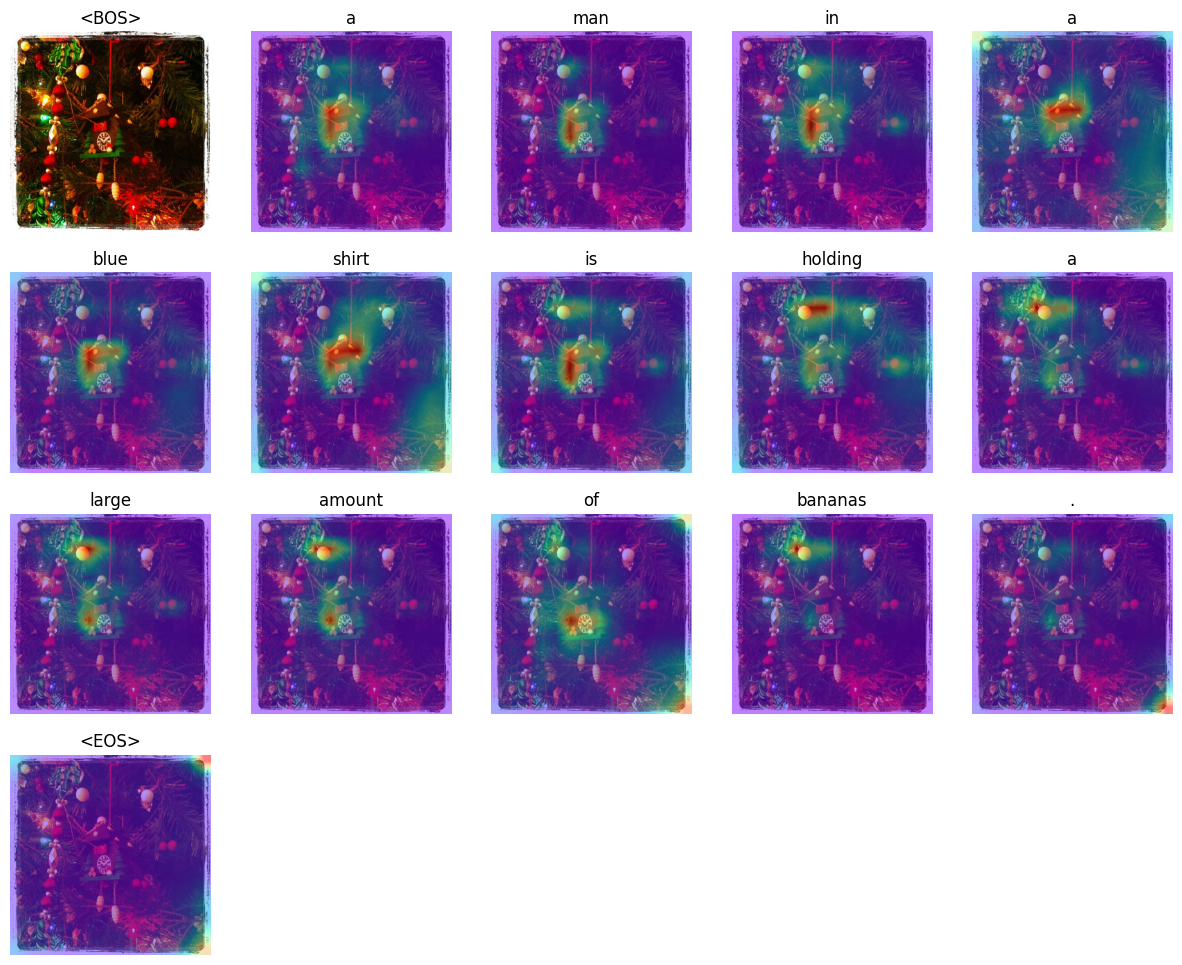

In [109]:
plt.figure(figsize=(col*3,row*3))
plt.subplot(row,col,1)
plt.title('<BOS>')
plt.axis('off')
plt.imshow(img)
for i in range(num_pair-1):
    plt.subplot(row,col,i+2)
    plt.title(text[i])
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(attn[i][0], alpha=0.5, cmap='rainbow')
plt.show()

In [ ]:
json_object = json.dumps(result_dict, indent=4)
with open("p2_output.json", "w") as outfile:
    outfile.write(json_object)

In [14]:
result_dict

{'000000000368': 'A man is playing frisbee in a field.',
 '000000000620': 'A man in a white shirt is standing in front of a building.',
 '000000001548': 'A man riding a wave on a surfboard in the snow.',
 '000000001999': 'A cat is sitting on a wooden bench.',
 '000000002982': 'A large clock tower with a clock on it.',
 '000000003461': 'A man is riding a skateboard on a street.',
 '000000003771': 'A dog is running in the grass.',
 '000000003999': 'A cat sitting on top of a wooden table.',
 '000000004956': 'A black dog is standing on a rock.',
 '000000005418': 'A giraffe standing in a field with a tree in the background.',
 '000000005434': 'A large clock on a pole in a room.',
 '000000005757': 'A train is parked on the tracks in front of a building.',
 '000000005811': 'A red bus is parked on the side of a street.',
 '000000006393': 'A bathroom with a toilet and a toilet with a toilet.',
 '000000006789': 'A large plane is on a runway in the water.',
 '000000007201': 'A man is riding a wav

In [15]:
len(result_dict)

1789